In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import json
import pprint

import networkx as nx
#import nxviz as nv  
#from nxviz import annotate

## 1.Data Processing 

### Load Cleaned Data

In [2]:
with open('networkdata/reddit_reply_to_t3_1i0nukq.json') as f:
    data = json.load(f)

### Load Node Bot Prob

In [3]:
bot_df = pd.read_csv('reddit_averaged_bot_prob.csv')

In [4]:
bot_df[:10]

author_fullname  botprobability  thr_50  thr_60  thr_70  thr_80  thr_90
0       t2_1001os        0.752688    True    True    True   False   False
1       t2_1001ql        0.752943    True    True    True   False   False
2       t2_1001qx        0.419376   False   False   False   False   False
3   t2_1007qfi3ai        0.086045   False   False   False   False   False
4       t2_100an3        0.752943    True    True    True   False   False
5       t2_100kw1        0.743840    True    True    True   False   False
6       t2_100o38        0.415059   False   False   False   False   False
7       t2_100qos        0.419610   False   False   False   False   False
8       t2_100wqb        0.419610   False   False   False   False   False
9   t2_1013avwpi9        0.419610   False   False   False   False   False

In [5]:
# map author to bot detection results under different thresholds

thr_50 = dict()
thr_60 = dict()
thr_70 = dict()
thr_80 = dict()
thr_90 = dict()
for index, row in bot_df.iterrows():
    thr_50[row['author_fullname']] = row['thr_50']
    thr_60[row['author_fullname']] = row['thr_60']
    thr_70[row['author_fullname']] = row['thr_70']
    thr_80[row['author_fullname']] = row['thr_80']
    thr_90[row['author_fullname']] = row['thr_90']

### Construct Edge List

In [6]:
# map each user id to their parent user id(the user), indicating the reply relation

edge_list = []
for key, values in data.items():
    iter_lst = [(key, val) for val in values]
    edge_list.extend(iter_lst)
edge_list[:10]

[('t2_9a7co', 't2_9a7co'),
 ('t2_o1jtvc6rk', 't2_o1jtvc6rk'),
 ('t2_o1jtvc6rk', 't2_5uj11eb9'),
 ('t2_o1jtvc6rk', 't2_1eb6ss9z6j'),
 ('t2_o1jtvc6rk', 't2_64ix18fn'),
 ('t2_o1jtvc6rk', 't2_vlafa4rvv'),
 ('t2_o1jtvc6rk', 't2_64ix18fn'),
 ('t2_o1jtvc6rk', 't2_64ix18fn'),
 ('t2_o1jtvc6rk', 't2_64ix18fn'),
 ('t2_o1jtvc6rk', 't2_64ix18fn')]

In [7]:
user_lst = list(data.keys())

In [8]:
len(user_lst)

1598

In [9]:
len(edge_list)

2241

In [10]:
# add weight (reply times) to the edge list
weight_list = []
for x in set(edge_list):
    tpl = tuple(list(x) + [edge_list.count(x)])
    weight_list.append(tpl)
weight_list[:10]

[('t2_9tzs3yd0', 't2_17zwjzbcq5', 1),
 ('t2_129ptznhoh', 't2_mia8t', 1),
 ('t2_djl7i7oz4', 't2_beft1', 1),
 ('t2_gagymmo1', 't2_o1jtvc6rk', 1),
 ('t2_qum7c9kiy', 't2_qum7c9kiy', 1),
 ('t2_1b7evt4tnk', 't2_1b7evt4tnk', 1),
 ('t2_ec39o', 't2_etysz', 1),
 ('t2_6dr4hy4k', 't2_o1jtvc6rk', 1),
 ('t2_vzxv4lzqi', 't2_vzxv4lzqi', 1),
 ('t2_17f4c9aq74', 't2_w439gawq5', 1)]

We can define the following function that reads in json file to reply relationship dictionary individual post and returns list of nodes and list of weighted edges:

In [11]:
def compute_node_edge(post_id):
    """
    Computes the user nodes and weighted edges for a given Reddit post."
    """

    with open(f'networkdata/reddit_reply_to_{post_id}.json') as f:
        reply_dict = json.load(f)

    user_lst = list(reply_dict.keys())
    weight_list = []
    edge_list = []

    for key, values in reply_dict.items():
        iter_lst = [(key, val) for val in values]
        edge_list.extend(iter_lst)

    for x in set(edge_list):
        tpl = tuple(list(x) + [edge_list.count(x)])
        weight_list.append(tpl)

    return user_lst, weight_list

we use the top 11 (with highest comment numbers) posts to build newtorks for each

In [12]:
posts = ['t3_1hwsk85', 't3_1hxstm9', 't3_1hy9y05', 't3_1hyw7g6', 't3_1hz6ake', 't3_1i0kavt', 
         't3_1i0nukq', 't3_1i3cse3', 't3_1i16xr6', 't3_1i0788c', 't3_1iazjin']

In [13]:
#build edge list for each post

post_node_edge_dict = dict()
for post_id in posts:
    post_node_edge_dict[post_id] = {}
    post_node_edge_dict[post_id]['user'], post_node_edge_dict[post_id]['edge'] = compute_node_edge(post_id)

We test if the function works as expected:

In [14]:
post_node_edge_dict['t3_1i0nukq']['user'][:5]

['t2_9a7co', 't2_o1jtvc6rk', 't2_8kmztost', 't2_prtspyjr', 't2_od2zf4y0e']

In [15]:
post_node_edge_dict['t3_1i0nukq']['edge'][:5]

[('t2_9tzs3yd0', 't2_17zwjzbcq5', 1),
 ('t2_129ptznhoh', 't2_mia8t', 1),
 ('t2_djl7i7oz4', 't2_beft1', 1),
 ('t2_gagymmo1', 't2_o1jtvc6rk', 1),
 ('t2_qum7c9kiy', 't2_qum7c9kiy', 1)]

Great! Now we can move on to visualizations!

## 2. Network Visualize Tryouts

In [16]:
user_lst = post_node_edge_dict['t3_1i0nukq']['user']
weight_list = post_node_edge_dict['t3_1i0nukq']['edge']

In [17]:
def add_bot_attr(graph, threshold):
    """
    Assigns a 'botornot' attribute to each node in the graph based on a given threshold dictionary.
    """

    filtered = dict()
    for node in graph.nodes():
        val = threshold.get(node, False)
        if val:
            filtered[node] = 'bot'
        else:
            filtered[node] = 'human'
    nx.set_node_attributes(graph, filtered, 'botornot')

In [18]:
# Create a directed graph
G1 = nx.DiGraph()
# Add nodes from the user list
G1.add_nodes_from(user_lst)
# Add weighted edges from the weight list
G1.add_weighted_edges_from(weight_list)
# Add weighted edges from the weight list
add_bot_attr(G1, thr_70)

In [19]:
G1.nodes['t2_5x71m57p']['botornot']

'human'

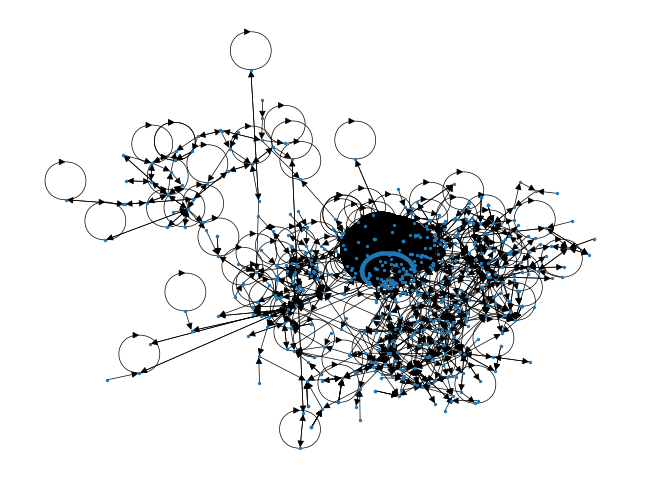

<Figure size 640x480 with 0 Axes>

In [20]:
#visualize the newtork with basic settings

pos = nx.kamada_kawai_layout(G1)
nx.draw(G1, pos, node_size = 2, width = 0.5)
plt.figure()
plt.show()

We can calculate some basic measures:

In [21]:
#calculates the clustering coefficient for each node
print(nx.clustering(G1))

{'t2_9a7co': 0.00909090909090909, 't2_o1jtvc6rk': 0.00044242893485233934, 't2_8kmztost': 0, 't2_prtspyjr': 0, 't2_od2zf4y0e': 0.003676470588235294, 't2_59fn4lsf': 0.02702702702702703, 't2_371x7bqn': 0, 't2_e3hu1js0': 0.03409090909090909, 't2_116bx9614x': 0, 't2_4dfhg': 0, 't2_fo1g3b0k': 0.03333333333333333, 't2_7sd48mkay': 0, 't2_11dj8d': 0, 't2_2u42pgmd': 0, 't2_6gyep': 0, 't2_11z3apb1a8': 0, 't2_12rrca38kt': 0, 't2_5udfp4z76': 0, 't2_79vbz': 0, 't2_6pbjd6qz': 0, 't2_1dumqp8nkz': 0, 't2_etwdz': 0, 't2_abrgj4lm': 0, 't2_mj9owlba': 0, 't2_176do4': 0, 't2_n2zus1uh': 0, 't2_13b40e': 0, 't2_13oxro': 0, 't2_116gof0a': 0, 't2_rib17jx3': 0, 't2_2eesorat': 0, 't2_1cmnyntzje': 0, 't2_2pswxl9n': 0, 't2_1fmd2aj7ey': 0, 't2_1975kpnbqj': 0, 't2_t7bh4': 0, 't2_3o69tu7l': 0, 't2_1aau9evwgw': 0, 't2_17f4c9aq74': 0, 't2_18pfn343z4': 0.011029411764705883, 't2_colk0rt': 0, 't2_d5a2v18': 0, 't2_i2xcbmie': 0, 't2_jp4xxyk1': 0, 't2_hcqot3sg': 0, 't2_w79k9vubv': 0, 't2_egkh1jo9': 0, 't2_2bz30iij': 0, 't2_776

In [22]:
#calculates the reciprocity of a graph
print(nx.reciprocity(G1))

0.15760598503740647


In [23]:
#calculates the assortativity for the graph
nx.attribute_assortativity_coefficient(G1, 'botornot')

0.554580335189641

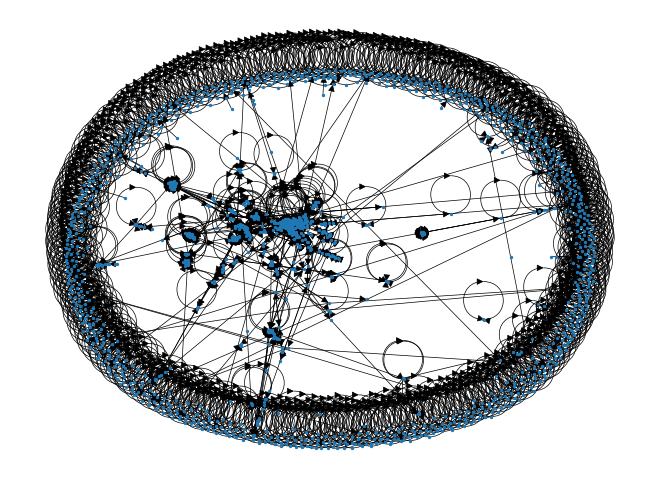

<Figure size 640x480 with 0 Axes>

In [24]:
# try different visualization layout
pos = nx.spring_layout(G1, iterations=100)
nx.draw(G1, pos, node_size = 2, width = 0.5)
plt.figure()
plt.show()

In [25]:
G1.out_degree

OutDegreeView({'t2_9a7co': 1, 't2_o1jtvc6rk': 5, 't2_8kmztost': 6, 't2_prtspyjr': 3, 't2_od2zf4y0e': 5, 't2_59fn4lsf': 5, 't2_371x7bqn': 1, 't2_e3hu1js0': 2, 't2_116bx9614x': 4, 't2_4dfhg': 2, 't2_fo1g3b0k': 1, 't2_7sd48mkay': 3, 't2_11dj8d': 1, 't2_2u42pgmd': 1, 't2_6gyep': 1, 't2_11z3apb1a8': 1, 't2_12rrca38kt': 1, 't2_5udfp4z76': 1, 't2_79vbz': 1, 't2_6pbjd6qz': 1, 't2_1dumqp8nkz': 1, 't2_etwdz': 1, 't2_abrgj4lm': 1, 't2_mj9owlba': 1, 't2_176do4': 2, 't2_n2zus1uh': 3, 't2_13b40e': 1, 't2_13oxro': 1, 't2_116gof0a': 1, 't2_rib17jx3': 1, 't2_2eesorat': 1, 't2_1cmnyntzje': 1, 't2_2pswxl9n': 1, 't2_1fmd2aj7ey': 1, 't2_1975kpnbqj': 1, 't2_t7bh4': 1, 't2_3o69tu7l': 1, 't2_1aau9evwgw': 1, 't2_17f4c9aq74': 2, 't2_18pfn343z4': 3, 't2_colk0rt': 1, 't2_d5a2v18': 1, 't2_i2xcbmie': 1, 't2_jp4xxyk1': 1, 't2_hcqot3sg': 1, 't2_w79k9vubv': 1, 't2_egkh1jo9': 1, 't2_2bz30iij': 1, 't2_776mi': 1, 't2_a1miposa': 1, 't2_vjybb3bv': 1, 't2_79dsd': 1, 't2_1f3nvmbc98': 2, 't2_o487gsll8': 1, 't2_5h7me': 2, 't2_

In [26]:
betweenness_dict = nx.betweenness_centrality(G1, normalized=True, weight= None , endpoints=False, seed=0)

In [27]:
from collections import Counter

# Finding 10 highest betweenness centrality
k = Counter(betweenness_dict)
high = k.most_common(10) 
 
print("Initial Dictionary:")
print(betweenness_dict, "\n")
 
print("Dictionary with 10 highest values:")
print("Keys: Values")
 
for i in high:
    print(i[0]," :",i[1]," ", G1.nodes[i[0]]['botornot'])

Initial Dictionary:
{'t2_9a7co': 0.0, 't2_o1jtvc6rk': 0.009088340701393334, 't2_8kmztost': 0.0036108849273865343, 't2_prtspyjr': 0.0012223717342357346, 't2_od2zf4y0e': 0.0011293076897154629, 't2_59fn4lsf': 0.00045571993169295054, 't2_371x7bqn': 0.0, 't2_e3hu1js0': 0.00041457582779977787, 't2_116bx9614x': 0.0018346351850269944, 't2_4dfhg': 0.00019416098551492433, 't2_fo1g3b0k': 0.0, 't2_7sd48mkay': 4.114410389317266e-05, 't2_11dj8d': 0.0, 't2_2u42pgmd': 0.0, 't2_6gyep': 0.0, 't2_11z3apb1a8': 0.0, 't2_12rrca38kt': 0.0, 't2_5udfp4z76': 0.0, 't2_79vbz': 0.0, 't2_6pbjd6qz': 0.0, 't2_1dumqp8nkz': 0.0, 't2_etwdz': 0.0, 't2_abrgj4lm': 0.0, 't2_mj9owlba': 0.0, 't2_176do4': 0.0, 't2_n2zus1uh': 3.918486085064063e-07, 't2_13b40e': 0.0, 't2_13oxro': 0.0, 't2_116gof0a': 0.0, 't2_rib17jx3': 0.0, 't2_2eesorat': 0.0, 't2_1cmnyntzje': 0.0, 't2_2pswxl9n': 0.0, 't2_1fmd2aj7ey': 0.0, 't2_1975kpnbqj': 0.0, 't2_t7bh4': 0.0, 't2_3o69tu7l': 0.0, 't2_1aau9evwgw': 0.0, 't2_17f4c9aq74': 1.5673944340256252e-06, 't

In [28]:
def top_betweenness(graph):
    """
    calculates and prints the top 10 nodes with the highest betweenness centrality in a given graph."
    """
     
    betweenness_dict = nx.betweenness_centrality(graph, normalized=True, weight= None, endpoints=False, seed=10000001)
    k = Counter(betweenness_dict)
    high = k.most_common(10) 
    print("Initial Dictionary:")
    print(betweenness_dict, "\n")
 
    print("Dictionary with 10 highest values:")
    print("Keys: Values")
 
    for i in high:
        print(i[0]," :",i[1]," ", graph.nodes[i[0]]['botornot'])

## 3. Network Visualize Function Definition

In [29]:
from collections import defaultdict

In [30]:
def build_graph(post_id, dictionary, bot_classification):
    """Builds a directed graph from the given dataset."""
    user_lst = dictionary[post_id]['user']
    weight_list = dictionary[post_id]['edge']

    G = nx.DiGraph()
    G.add_nodes_from(user_lst)
    G.add_weighted_edges_from(weight_list)  # Create a directed graph

    add_bot_attr(G, bot_classification)  # Assign bot attributes
    
    return G

In [31]:
# Adjust for self-loops  
# Since I previously used self-loops to represent first-level comments (the comments that reply directly to the post),  
# these replies only have an out-degree and should not be counted as having an in-degree. 


def handle_self_loops(G):
    """Adjusts in-degree calculations to remove self-loop contributions."""
    in_degrees = defaultdict(int)
    out_degrees = dict(G.out_degree(weight="weight"))  # Standard out-degree calculation
    
    for node in G.nodes():
        in_degree = G.in_degree(node, weight="weight")  # Standard in-degree calculation

        # Adjust for self-loops
        if G.has_edge(node, node):  
            self_loop_weight = G[node][node]["weight"]
            in_degree -= self_loop_weight  # Remove self-loop contribution
    
        in_degrees[node] = max(in_degree, 0)

    G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])  # Remove self-loops
    
    return in_degrees, out_degrees

In [32]:
def visualize_graph(G, node_sizes, post_id, min_degree, bot_classification, degree_type):
    """Visualizes the directed graph with assigned colors and layout."""
    plt.figure(figsize=(14, 14))

    # Generate layout
    pos = nx.kamada_kawai_layout(G, scale=10)  # Layout for better spacing

    # Assign colors based on bot classification
    node_colors = ["Orange" if bot_classification.get(node, False) else "Blue" for node in G.nodes()]

    # Draw graph elements
    nx.draw_networkx_edges(G, pos=pos, edge_color="darkgrey", width=0.5, alpha=0.6, arrows=True)
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=[node_sizes[node] for node in G.nodes()], alpha=0.8)

    # Add legend
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Not Bot'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Bot')],
        loc='upper right', fontsize=12
    )

    # Dynamic title based on degree type
    plt.title(f"Bot Network for {post_id} ({degree_type.capitalize()}-degree, Min {min_degree})", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # Save with dynamic filename
    plt.savefig(f'networkviz/plot_{post_id}_{degree_type}_mindegree{min_degree}.png', dpi=300, bbox_inches='tight')

    return plt

In [33]:
def plot_network_degree(post_id, dictionary, bot_classification, degree_type="out", min_degree=1, seed=10000001):
    """Builds, processes, and visualizes the bot network with specified degree type."""
    np.random.seed(seed)

    # Step 1: Build Graph
    G = build_graph(post_id, dictionary, bot_classification)

    # Step 2: Handle self-loops
    in_degrees, out_degrees = handle_self_loops(G)

    # Step 3: Compute total degree for node size 
    total_degrees = {node: in_degrees.get(node, 0) + out_degrees.get(node, 0) for node in G.nodes()}

    # Step 4: Select degree type for filtering
    if degree_type == "out":
        selected_degrees = out_degrees
    elif degree_type == "in":
        selected_degrees = in_degrees
    elif degree_type == "total":
        selected_degrees = total_degrees

    # Step 5: Filter nodes by selected degree type 
    nodes_to_remove = [node for node, degree in selected_degrees.items() if degree < min_degree]
    G.remove_nodes_from(nodes_to_remove)

    # Step 6: Normalize node sizes based on total degree
    max_total_degree = max(total_degrees.values(), default=1)
    min_size = 200  # Minimum node size for visibility
    node_sizes = {node: max(min_size, (selected_degrees.get(node, 0) / max_total_degree) * 800) for node in G.nodes()}

    # Step 7: Visualize Graph (layout and colors are handled inside visualize_graph)
    plt = visualize_graph(G, node_sizes, post_id, min_degree, bot_classification, degree_type)
    
    return G, plt


Initial Dictionary:
{'t2_adxr5': 0.0013197586726998493, 't2_keblrri9t': 0.0, 't2_67wqo': 0.0, 't2_4wbuk': 0.0, 't2_9450jcss': 0.0, 't2_7auzcfic': 0.0, 't2_bwa6vw5i': 0.0, 't2_7x56c9im': 0.0, 't2_c8qzk': 0.0, 't2_lz4ripwsr': 0.0, 't2_aoaof092': 0.0, 't2_4bvy7ob6': 0.0007541478129713424, 't2_ql7hqb7c': 0.0, 't2_5rji2ist8': 0.0, 't2_3ti8a': 0.0, 't2_bno90': 0.010558069381598794, 't2_8in5e': 0.001885369532428356, 't2_egs9n': 0.0003770739064856712, 't2_2br3hl0n': 0.0, 't2_9rytu': 0.0, 't2_66tna': 0.0, 't2_93aqu': 0.0024509803921568627, 't2_8vtkt4o': 0.0007541478129713424, 't2_spd5cigjv': 0.0, 't2_cyjzy': 0.0, 't2_9vlir': 0.0, 't2_b5jn1': 0.0007541478129713424, 't2_6tmz7': 0.001885369532428356, 't2_8cwz2': 0.0, 't2_qp7al': 0.0, 't2_4d2nq': 0.0, 't2_9c1piux3': 0.0, 't2_13tggbemg0': 0.003770739064856712, 't2_7pegy': 0.0, 't2_th209': 0.0, 't2_ebf3z': 0.0, 't2_agygp': 0.0, 't2_9h3y4': 0.0, 't2_6wu8f': 0.0, 't2_5accwk4j': 0.0, 't2_exae5': 0.0, 't2_14hrpiia': 0.0, 't2_58pfp': 0.0, 't2_dc9x3': 0.0,

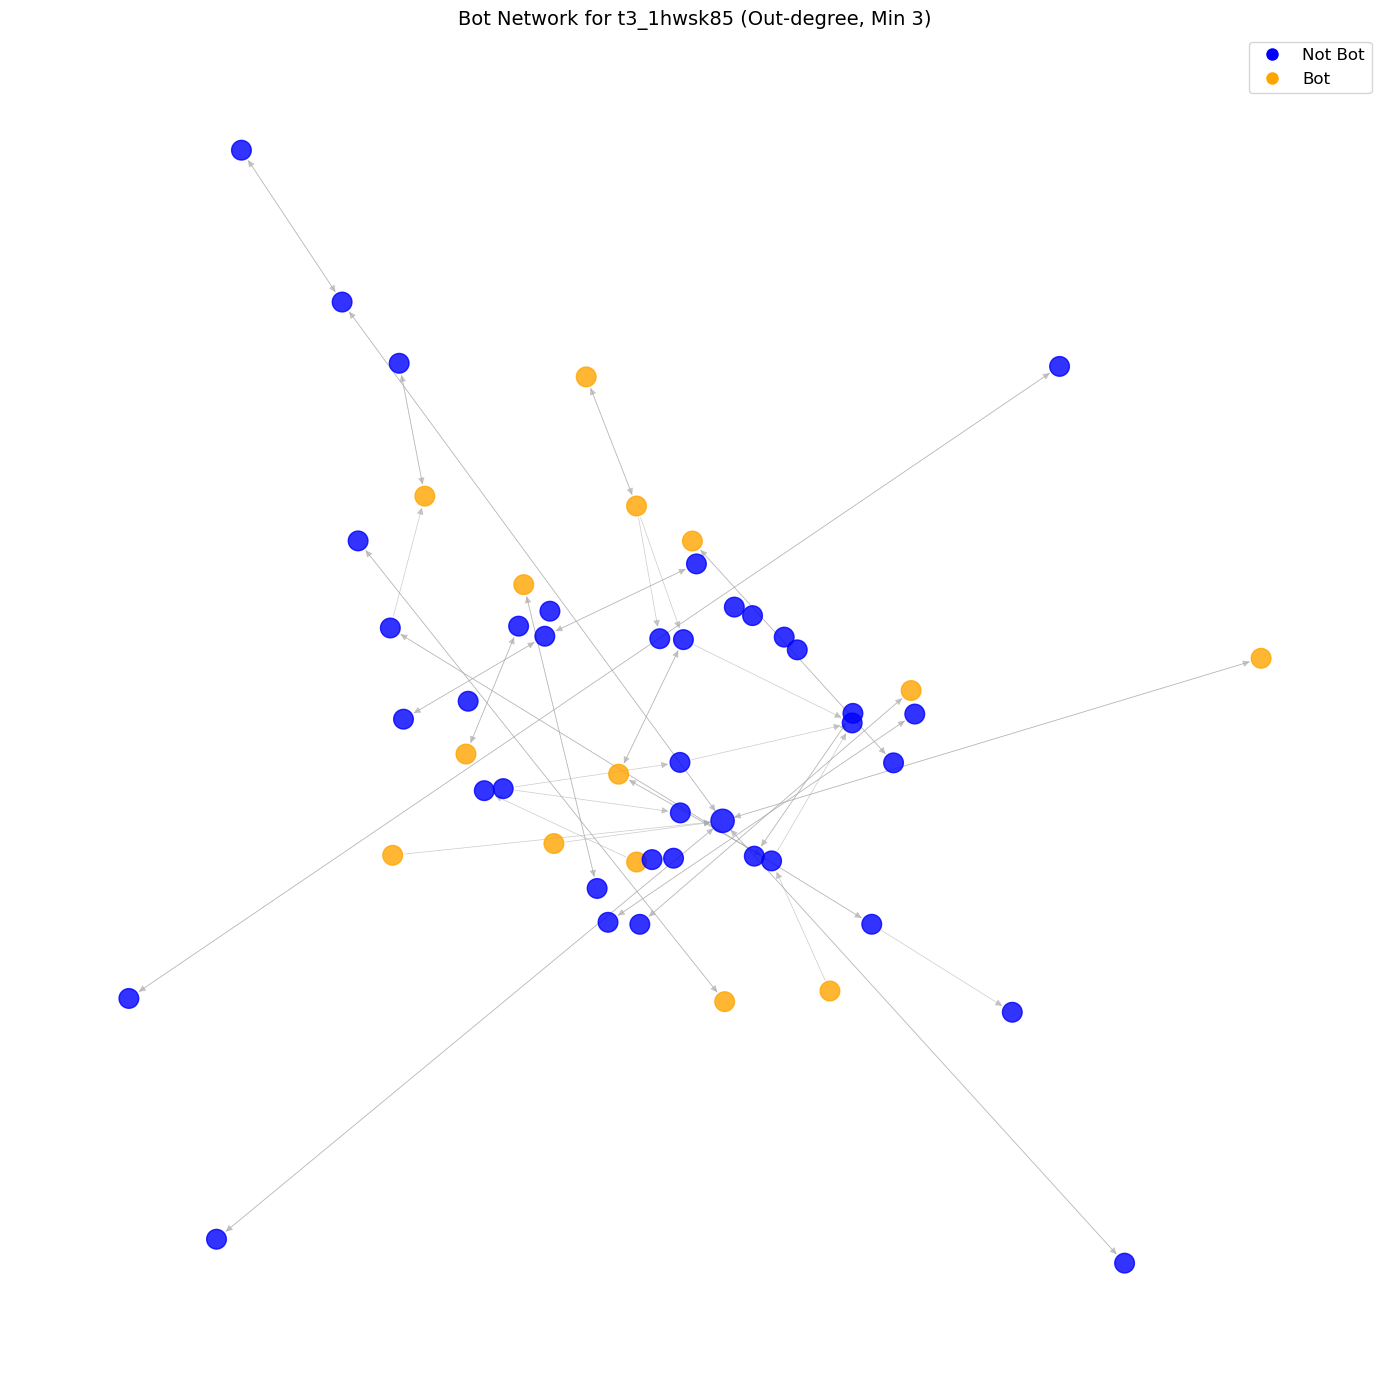

In [34]:
#check if the function works well

G, plot = plot_network_degree('t3_1hwsk85', post_node_edge_dict, thr_70, min_degree = 3)
top_betweenness(G)
plot.show()

## 4.Plot Sample Post Networks 

### Using Outdegree

Initial Dictionary:
{'t2_adxr5': 0.0013197586726998493, 't2_keblrri9t': 0.0, 't2_67wqo': 0.0, 't2_4wbuk': 0.0, 't2_9450jcss': 0.0, 't2_7auzcfic': 0.0, 't2_bwa6vw5i': 0.0, 't2_7x56c9im': 0.0, 't2_c8qzk': 0.0, 't2_lz4ripwsr': 0.0, 't2_aoaof092': 0.0, 't2_4bvy7ob6': 0.0007541478129713424, 't2_ql7hqb7c': 0.0, 't2_5rji2ist8': 0.0, 't2_3ti8a': 0.0, 't2_bno90': 0.010558069381598794, 't2_8in5e': 0.001885369532428356, 't2_egs9n': 0.0003770739064856712, 't2_2br3hl0n': 0.0, 't2_9rytu': 0.0, 't2_66tna': 0.0, 't2_93aqu': 0.0024509803921568627, 't2_8vtkt4o': 0.0007541478129713424, 't2_spd5cigjv': 0.0, 't2_cyjzy': 0.0, 't2_9vlir': 0.0, 't2_b5jn1': 0.0007541478129713424, 't2_6tmz7': 0.001885369532428356, 't2_8cwz2': 0.0, 't2_qp7al': 0.0, 't2_4d2nq': 0.0, 't2_9c1piux3': 0.0, 't2_13tggbemg0': 0.003770739064856712, 't2_7pegy': 0.0, 't2_th209': 0.0, 't2_ebf3z': 0.0, 't2_agygp': 0.0, 't2_9h3y4': 0.0, 't2_6wu8f': 0.0, 't2_5accwk4j': 0.0, 't2_exae5': 0.0, 't2_14hrpiia': 0.0, 't2_58pfp': 0.0, 't2_dc9x3': 0.0,

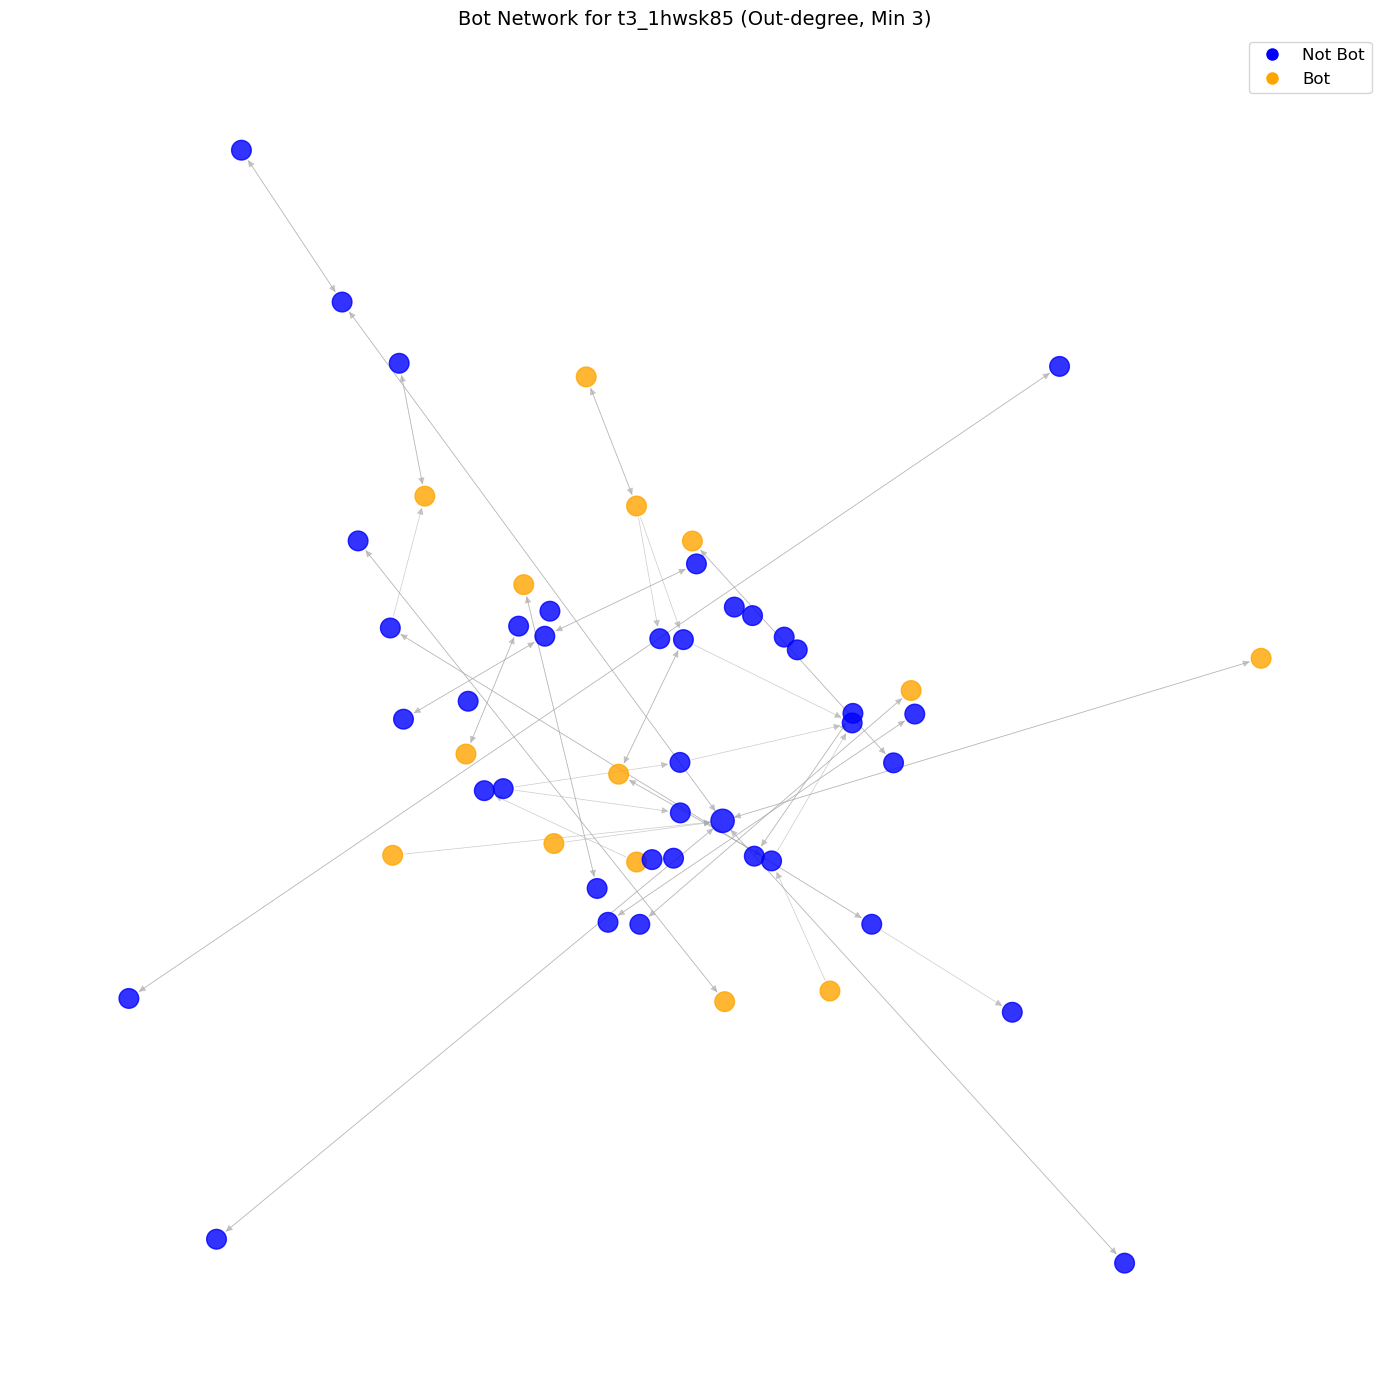

Initial Dictionary:
{'t2_by2pkeg5': 0.024369747899159664, 't2_76bjyurw': 0.0, 't2_158fcprtpm': 0.0, 't2_17alfddkwx': 0.0, 't2_8l0g7jqf': 0.0058823529411764705, 't2_k51bnotc': 0.05042016806722689, 't2_navwx': 0.0016806722689075631, 't2_5orwrgxy': 0.0, 't2_39zsy1nh': 0.0, 't2_12kwn5r226': 0.033613445378151266, 't2_54win': 0.0, 't2_rjhap3jtt': 0.0, 't2_shau5s28': 0.010084033613445379, 't2_e4dih': 0.0, 't2_hj7xazqd': 0.0067226890756302525, 't2_usfvb9x4': 0.0, 't2_j05obvqz': 0.005042016806722689, 't2_4mtdh': 0.009243697478991597, 't2_9vvpj': 0.034453781512605045, 't2_66zdrq9e': 0.022689075630252103, 't2_2vfqry6a': 0.0, 't2_by859': 0.0016806722689075631, 't2_a4rwqr88': 0.0, 't2_150xgyj68b': 0.0, 't2_1p7gdjqs': 0.0, 't2_5qaho': 0.0, 't2_7o0p56pc': 0.0, 't2_nejmd': 0.010084033613445379, 't2_8vt92qrs': 0.025210084033613446, 't2_bg6tj': 0.0, 't2_4o1fy': 0.0, 't2_78r2m': 0.0, 't2_3flzpg0p': 0.0, 't2_ehncr5el': 0.0, 't2_67r0e': 0.028571428571428574, 't2_3ujrkdf': 0.0} 

Dictionary with 10 highest 

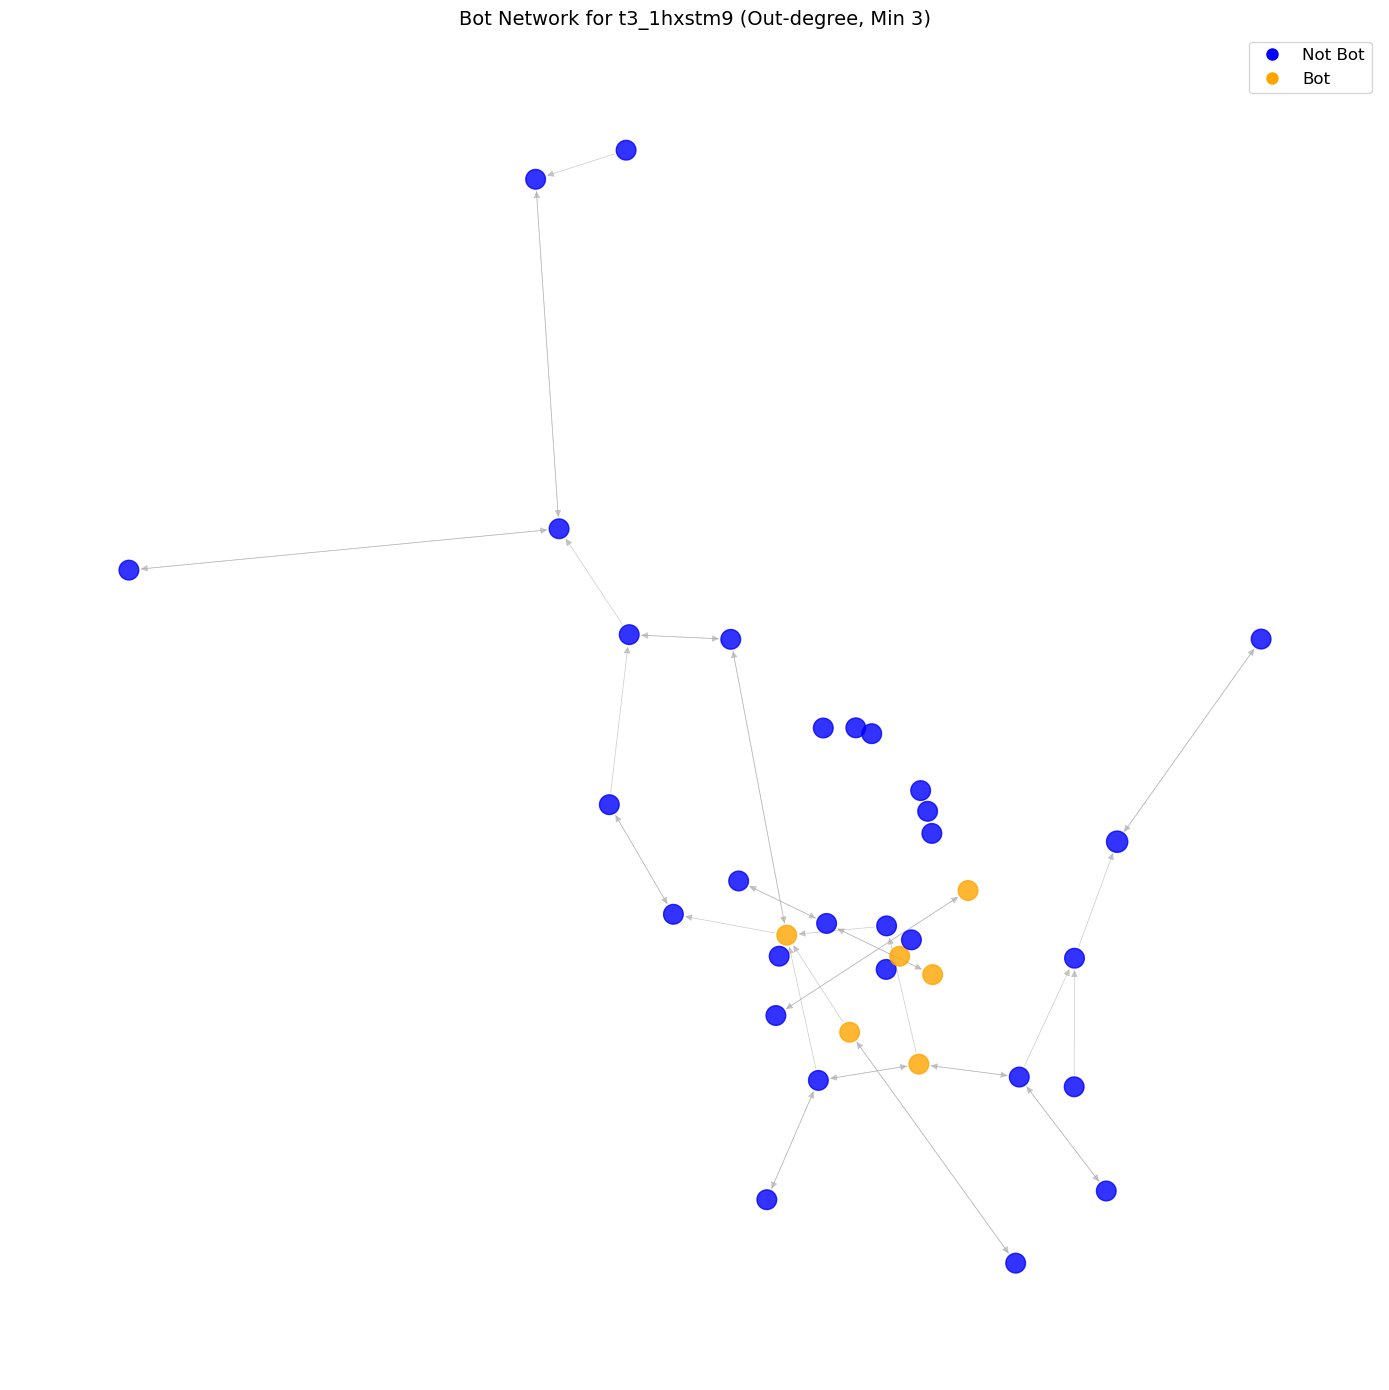

Initial Dictionary:
{'t2_32gkguod': 0.0, 't2_5h7n767h': 0.0, 't2_tkfvnsmlc': 0.0, 't2_oxvof62q': 0.0, 't2_2o0twc1y': 0.0, 't2_13f7blo': 0.0, 't2_89nj2zyv': 0.0, 't2_49r1wxydc': 0.0, 't2_1banhkxbgq': 0.0, 't2_ts3xkfio1': 0.0, 't2_1epclhfffo': 1.0, 't2_1dyh3sfq6v': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_1epclhfffo  : 1.0   human
t2_32gkguod  : 0.0   human
t2_5h7n767h  : 0.0   human
t2_tkfvnsmlc  : 0.0   human
t2_oxvof62q  : 0.0   human
t2_2o0twc1y  : 0.0   human
t2_13f7blo  : 0.0   human
t2_89nj2zyv  : 0.0   human
t2_49r1wxydc  : 0.0   human
t2_1banhkxbgq  : 0.0   bot


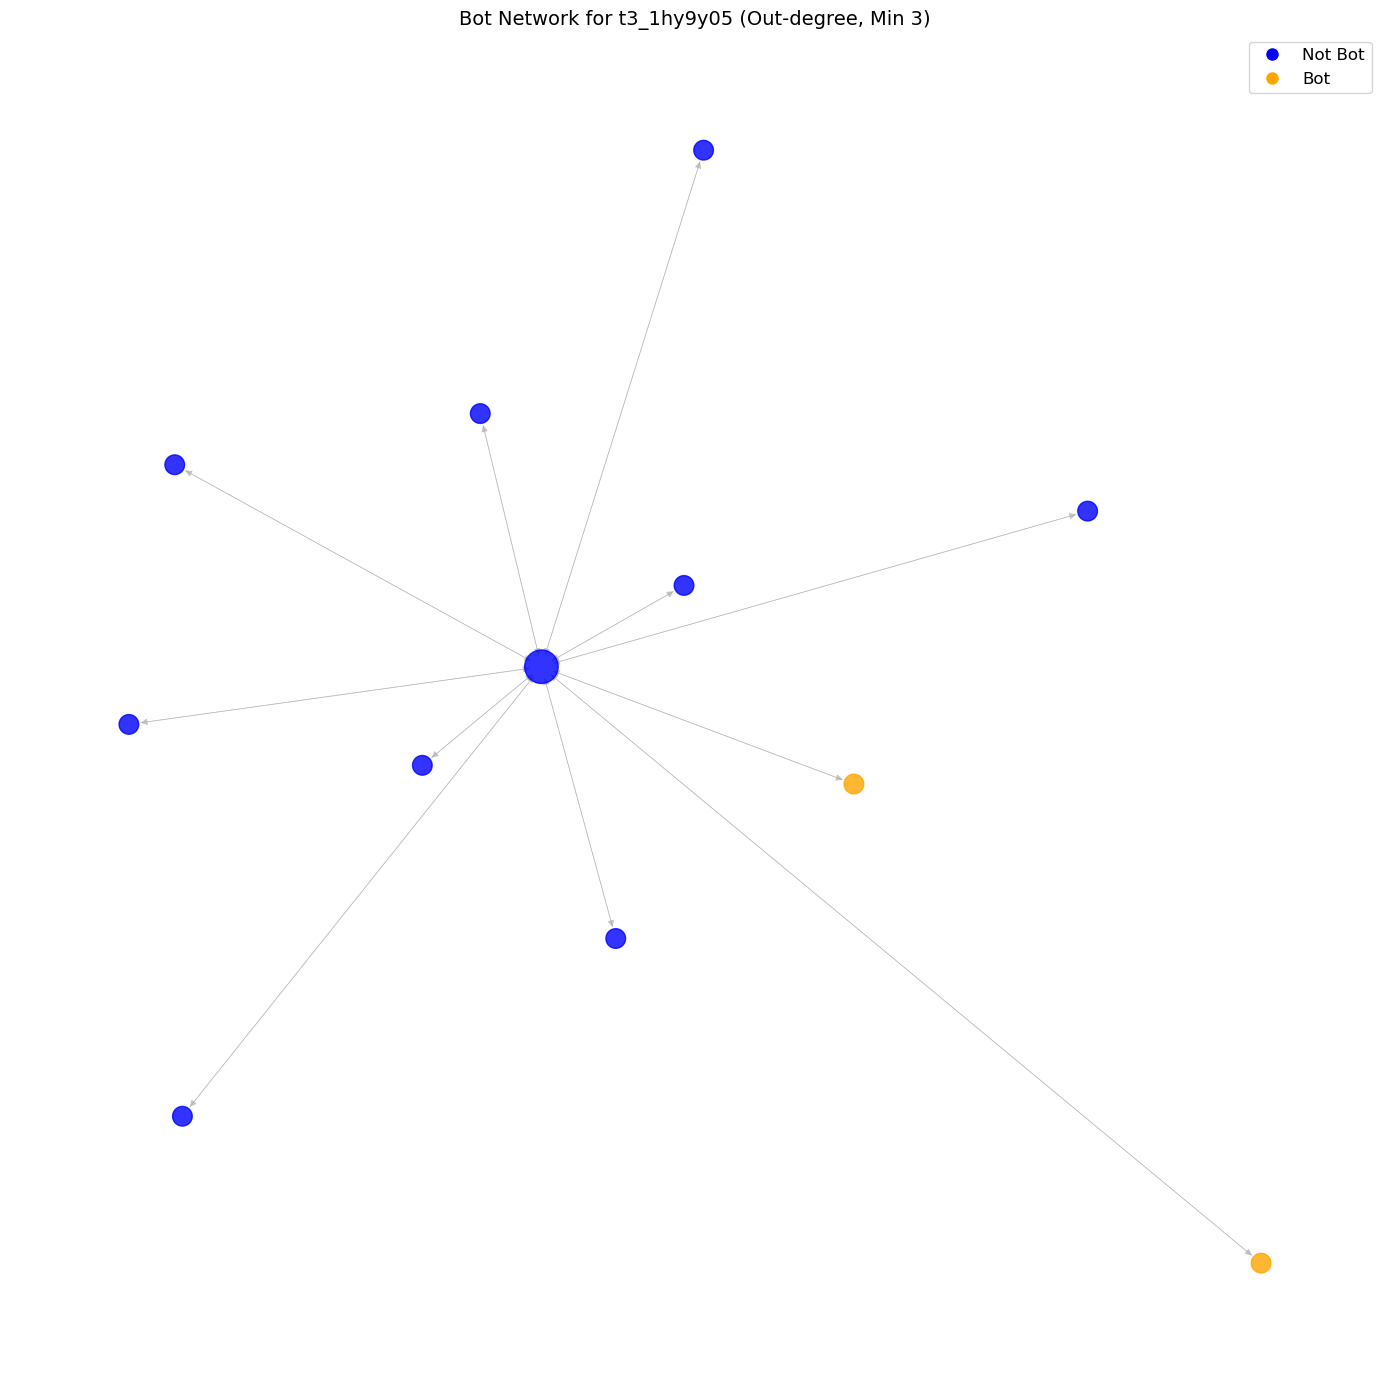

Initial Dictionary:
{'t2_ecc7w': 0.09217719431760527, 't2_9q1uyk0x': 0.11027080162354133, 't2_767ka': 0.02105530187721968, 't2_rekwy': 0.010464231354642313, 't2_hn17g': 0.02619228817858955, 't2_l4k8xo8q': 0.0, 't2_p7mnzeamj': 0.0, 't2_k9kk5': 0.0, 't2_qfdyi': 0.0, 't2_gn65nija': 0.0, 't2_3718c': 0.0, 't2_114bhb': 0.0, 't2_qg7iec8r': 0.0, 't2_4r7pz': 0.1558187468290208, 't2_a8hy2szz': 0.018645357686453576, 't2_g0rtv': 0.01445966514459665, 't2_trqpd': 0.0632166412988331, 't2_ojxfx': 0.03674530695078639, 't2_elee5': 0.19058219178082186, 't2_sk4kqgj3': 0.013622526636225265, 't2_jmi14an': 0.0, 't2_35umm': 0.0, 't2_ikq8r': 0.022203196347031967, 't2_9jteq': 0.0, 't2_9xogj': 0.03675164890918316, 't2_ihdrn': 0.011780187721968543, 't2_113fhr': 0.03446854388635209, 't2_cag3a': 0.24905187721968547, 't2_8x1m3ey5': 0.042935058346017255, 't2_lrytuy0bv': 0.0, 't2_53bke': 0.0, 't2_bf20u': 0.12685185185185183, 't2_du3j2': 0.0, 't2_8ipwp': 0.0, 't2_dguxi': 0.00076103500761035, 't2_nmo2u': 0.0, 't2_3xd0yz

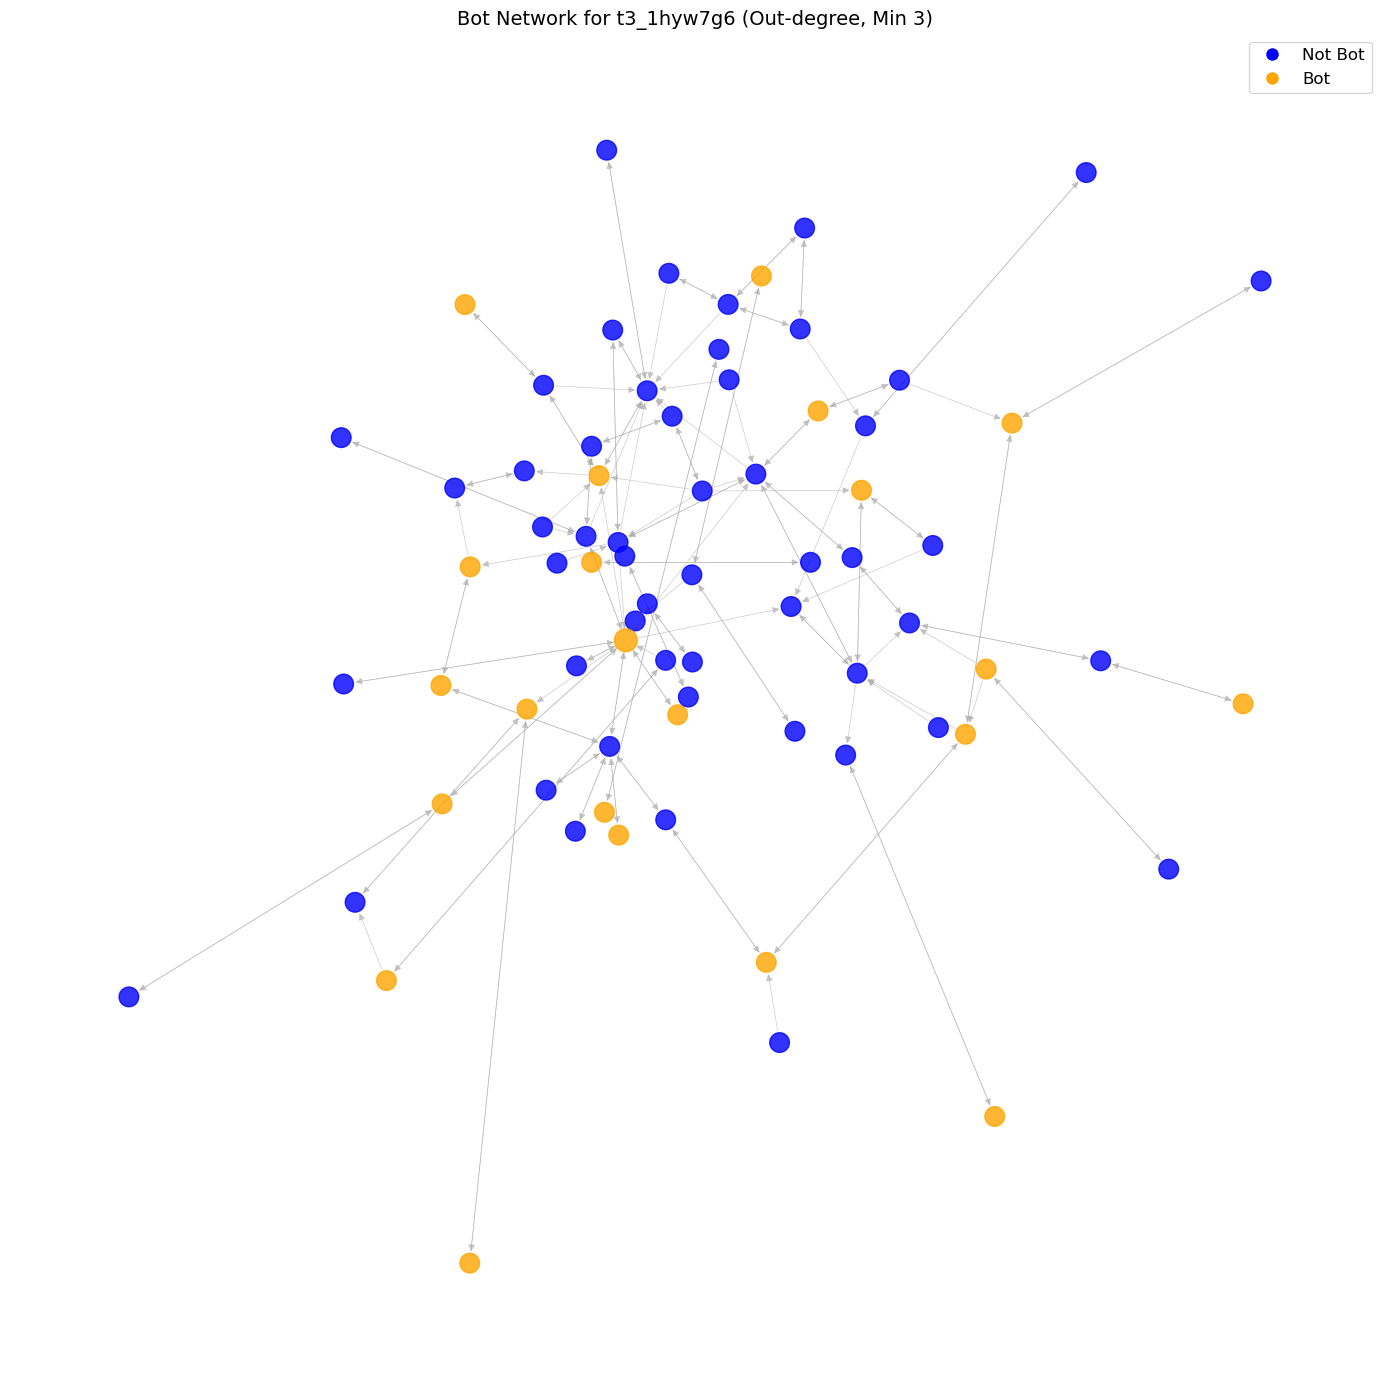

Initial Dictionary:
{'t2_drjxotfm4': 0.0, 't2_ego4s': 0.0, 't2_lf58eu5l': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_drjxotfm4  : 0.0   human
t2_ego4s  : 0.0   human
t2_lf58eu5l  : 0.0   human


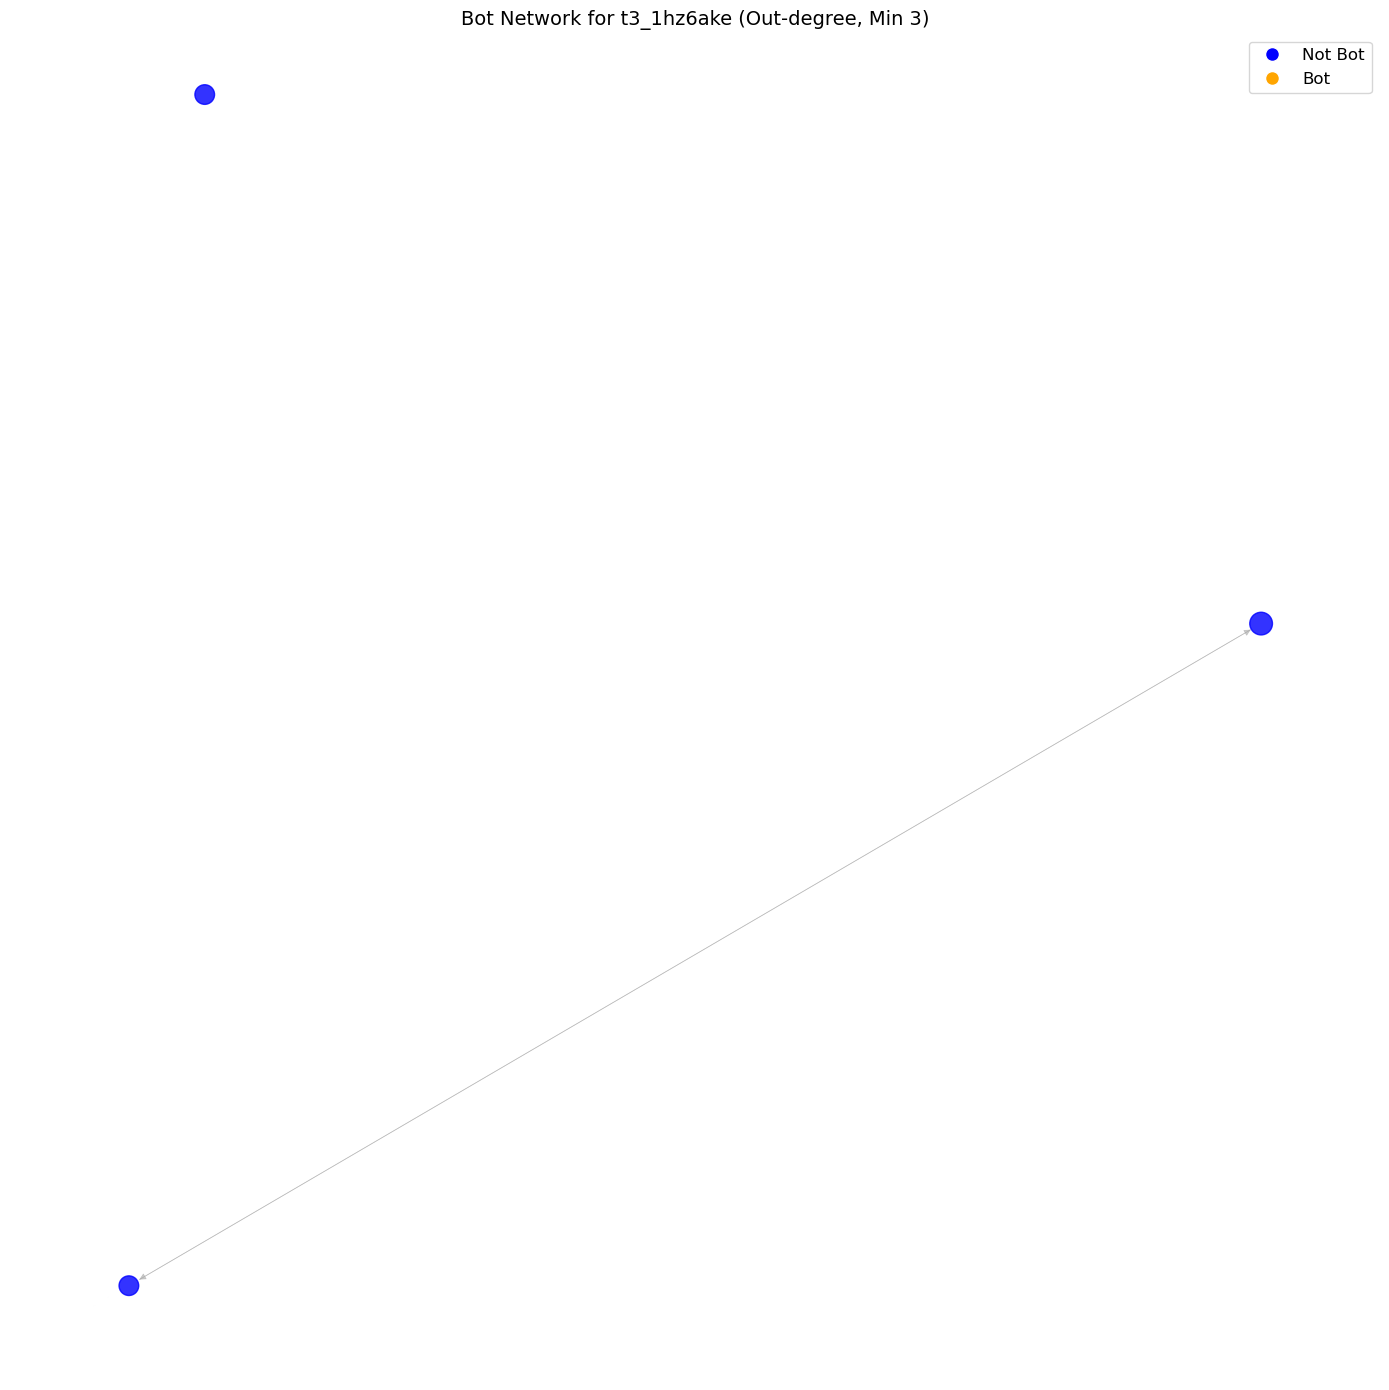

Initial Dictionary:
{'t2_2hm6l94u': 0.10526315789473684, 't2_ijns0q0bv': 0.06477732793522267, 't2_r4zx1zd1': 0.27125506072874495, 't2_40u7q': 0.044534412955465584, 't2_hyr5mz8kr': 0.0, 't2_q6m1fcsv5': 0.0, 't2_5gf92jwj': 0.0, 't2_9gv15v8v': 0.1680161943319838, 't2_14m542msld': 0.0, 't2_3rva17ms': 0.0, 't2_awk13': 0.0, 't2_k36l1ydf': 0.07827260458839407, 't2_tb0leam22': 0.010796221322537112, 't2_wbfb7': 0.0, 't2_o5w2bxob1': 0.10121457489878542, 't2_1fjwneinop': 0.09716599190283401, 't2_rg4zxpty': 0.018893387314439944, 't2_6bcto': 0.05668016194331984, 't2_831d5we0': 0.01720647773279352, 't2_wjwunnej3': 0.02294197031039136, 't2_7g9k4kmrc': 0.0, 't2_a4x9zk6cx': 0.08299595141700404, 't2_d49cj6qd': 0.0, 't2_brjfsxlpn': 0.17543859649122806, 't2_49iv': 0.0, 't2_1k6jxow': 0.0, 't2_11cvygh5xm': 0.0, 't2_1awdfidkpt': 0.0, 't2_8fr47': 0.0, 't2_3f8oc2ax': 0.0, 't2_1cwefj7dvn': 0.032388663967611336, 't2_e3ucao016': 0.0, 't2_7q5cf': 0.0, 't2_2tdczgrk': 0.08636977058029689, 't2_7mjcj3pj': 0.0, 't2_yzz

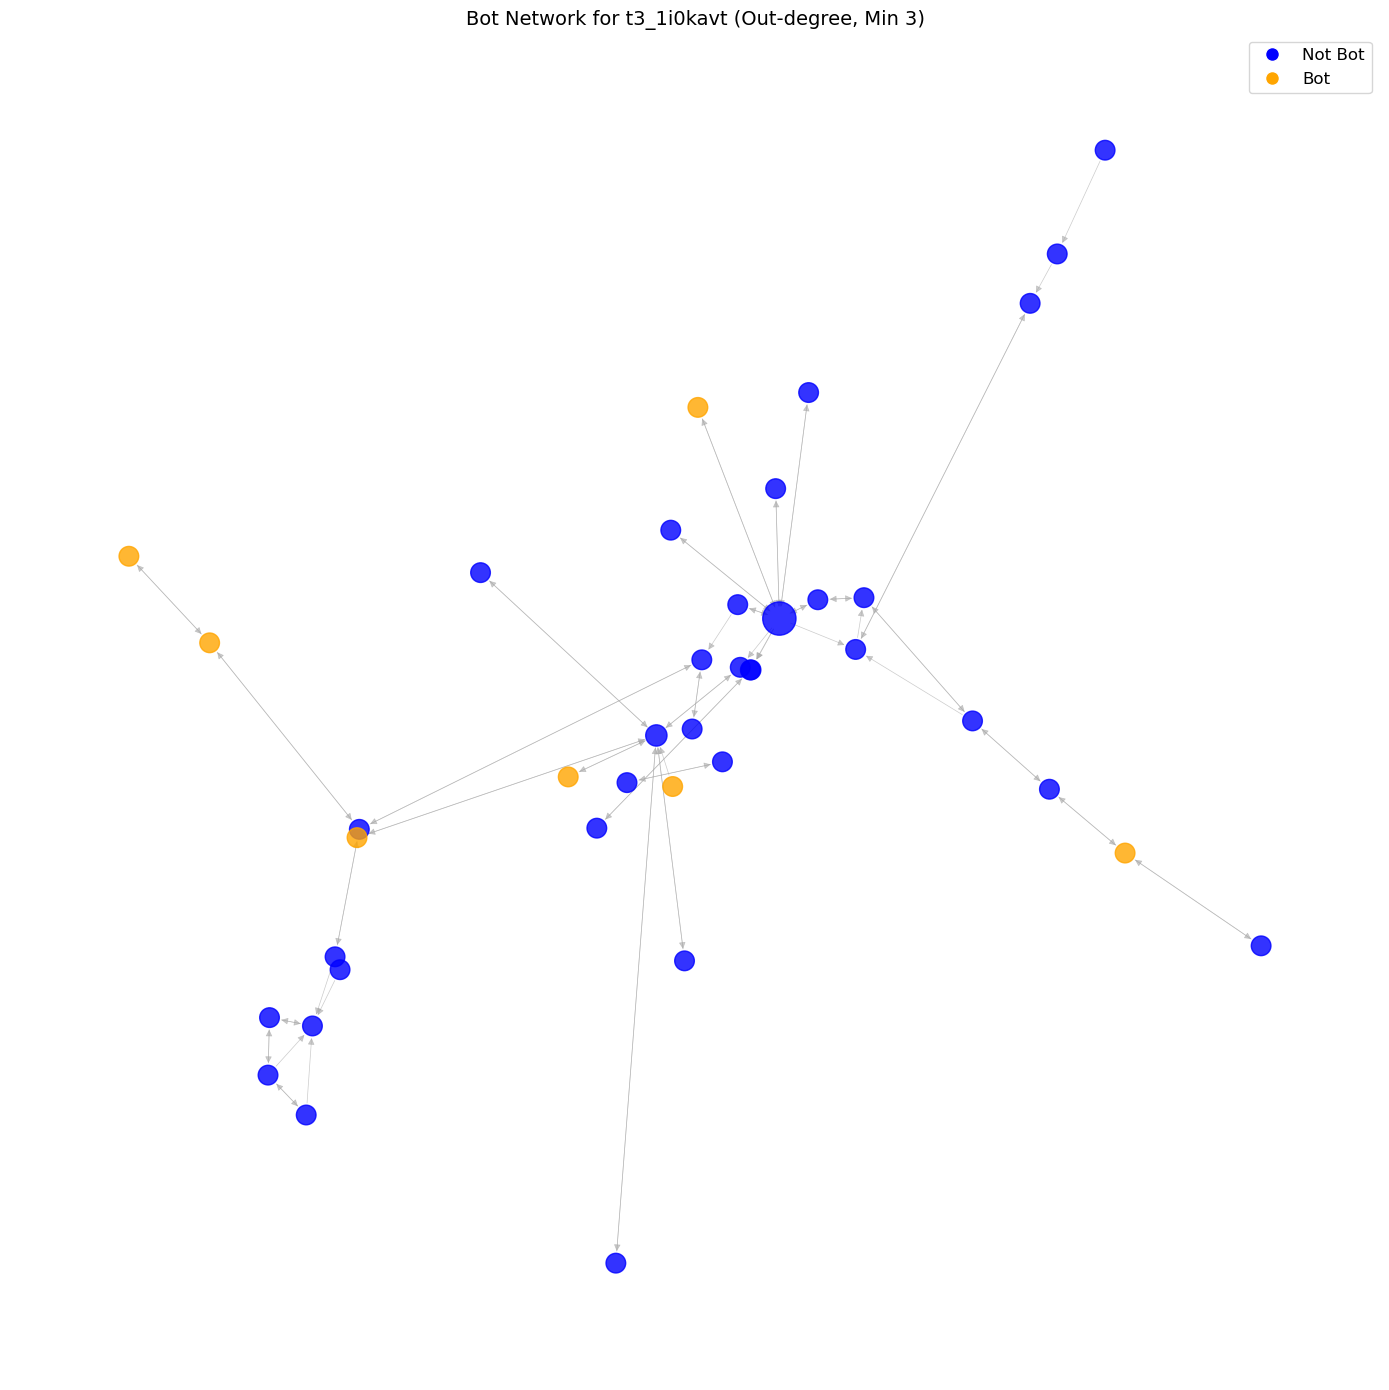

Initial Dictionary:
{'t2_o1jtvc6rk': 0.004131680661068906, 't2_8kmztost': 0.013794482207117154, 't2_prtspyjr': 0.0, 't2_od2zf4y0e': 0.0, 't2_59fn4lsf': 0.0008663201386112222, 't2_116bx9614x': 0.0032653605224576836, 't2_4dfhg': 0.0, 't2_7sd48mkay': 0.0, 't2_n2zus1uh': 0.0, 't2_18pfn343z4': 0.0014660802345728375, 't2_95ph63qo': 6.66400106624017e-05, 't2_vn4n524': 0.0, 't2_67h9ybx6': 0.0021324803411968546, 't2_tfnzr8xu5': 0.0, 't2_y3zv6rsps': 0.0, 't2_8rjfdrn6': 0.0, 't2_afwuz': 0.0, 't2_fo9mq1t': 0.00039984006397441024, 't2_129ptznhoh': 0.0006664001066240171, 't2_1ad0imzay5': 0.0, 't2_g6gw1wvg': 0.0, 't2_3shbajc0': 0.0, 't2_1d9jq67d89': 0.0, 't2_pnbsk': 0.0, 't2_amh5wz86n': 0.0, 't2_thl1uatp': 0.0, 't2_1ag3x8m622': 0.0, 't2_9nacpkwk': 0.0, 't2_11igl47xal': 0.0, 't2_y1mpov2um': 0.0, 't2_23wsw6l1': 0.0, 't2_1cx1swqlr2': 0.0, 't2_7yacuo17': 3.332000533120085e-05, 't2_9lrla7ff': 0.002765560442489671, 't2_cxy1er0t': 0.0, 't2_wsctldqgc': 0.0, 't2_a2h8txk4': 0.0, 't2_186ve8csp9': 0.0, 't2_34pwa

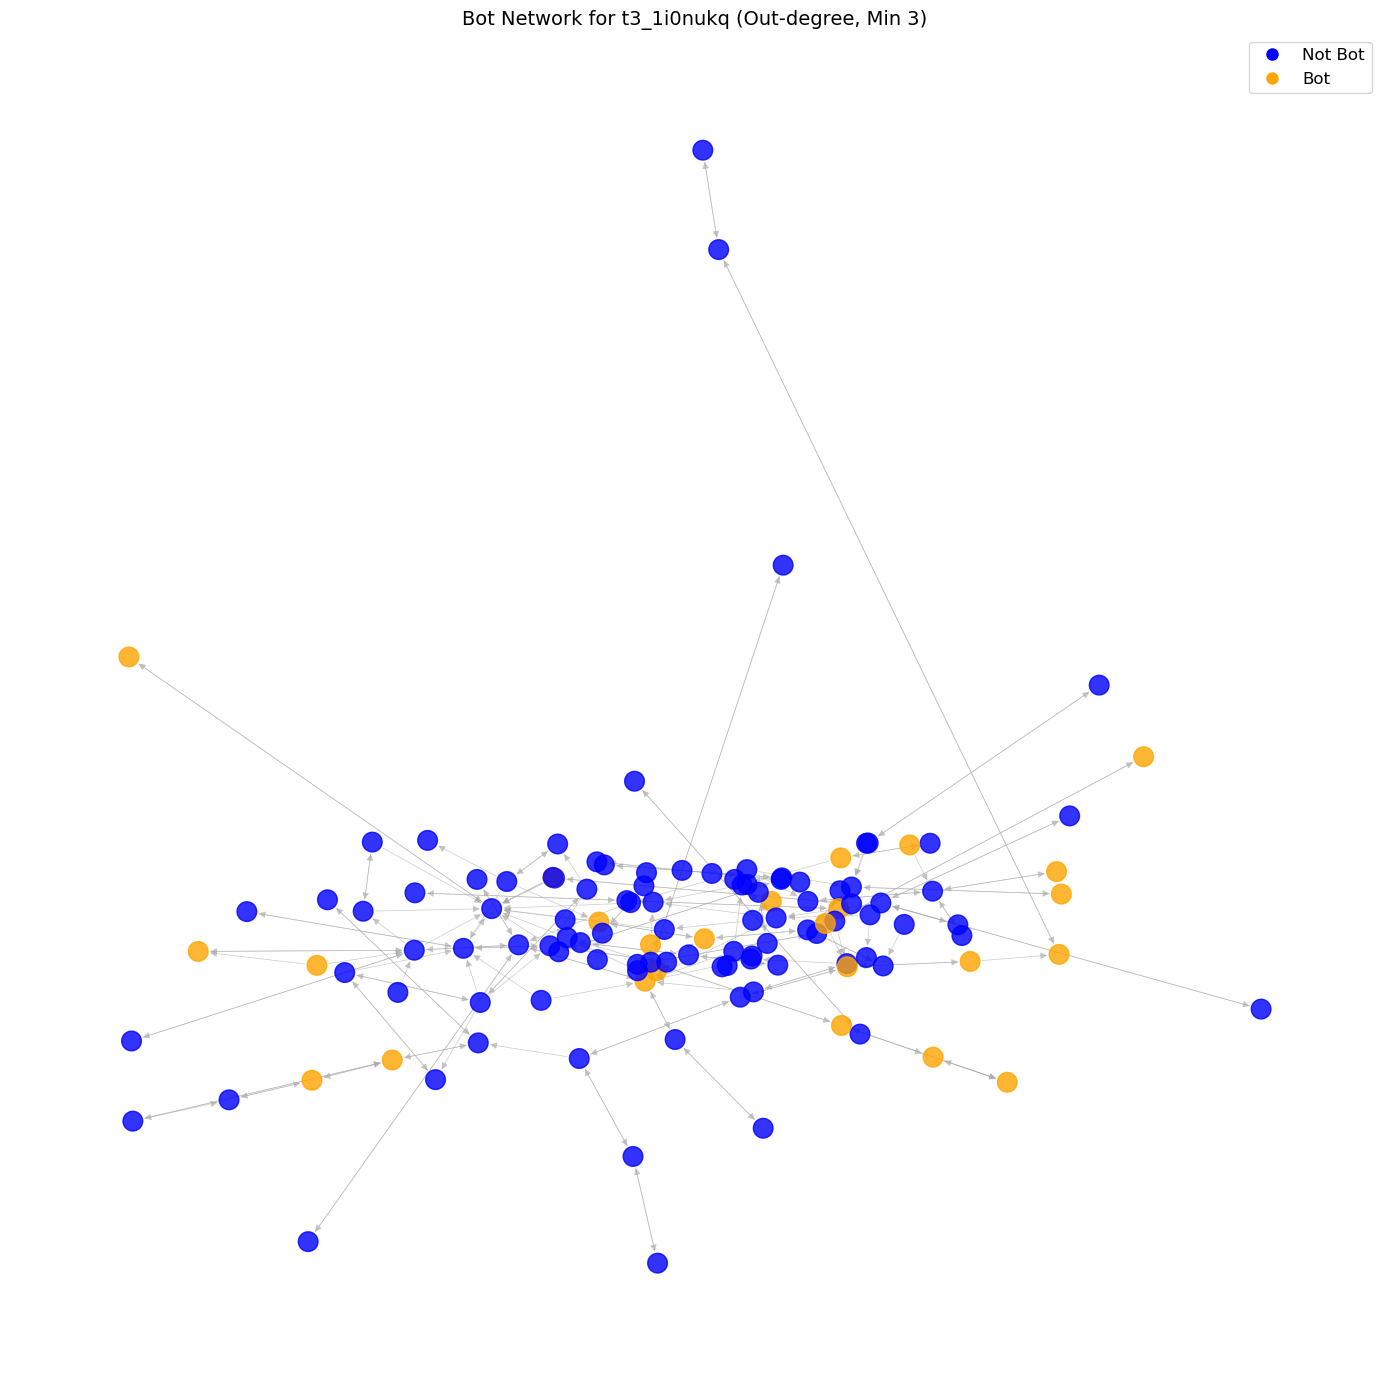

Initial Dictionary:
{'t2_9uty86gt': 0.0, 't2_ykxsgeko1': 0.0, 't2_8nsw3umv': 0.0, 't2_3cvd5cm3': 0.0, 't2_31nm3': 0.0, 't2_v369lq2ht': 0.0, 't2_xthom': 0.1893939393939394, 't2_54x3au7f': 0.0, 't2_4eopssp4': 0.0, 't2_12r7awdlwt': 0.0, 't2_elqjxo7cg': 0.0, 't2_ls2jm5s0': 0.0, 't2_1cwoaroqv9': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_xthom  : 0.1893939393939394   human
t2_9uty86gt  : 0.0   human
t2_ykxsgeko1  : 0.0   human
t2_8nsw3umv  : 0.0   human
t2_3cvd5cm3  : 0.0   human
t2_31nm3  : 0.0   bot
t2_v369lq2ht  : 0.0   human
t2_54x3au7f  : 0.0   human
t2_4eopssp4  : 0.0   human
t2_12r7awdlwt  : 0.0   human


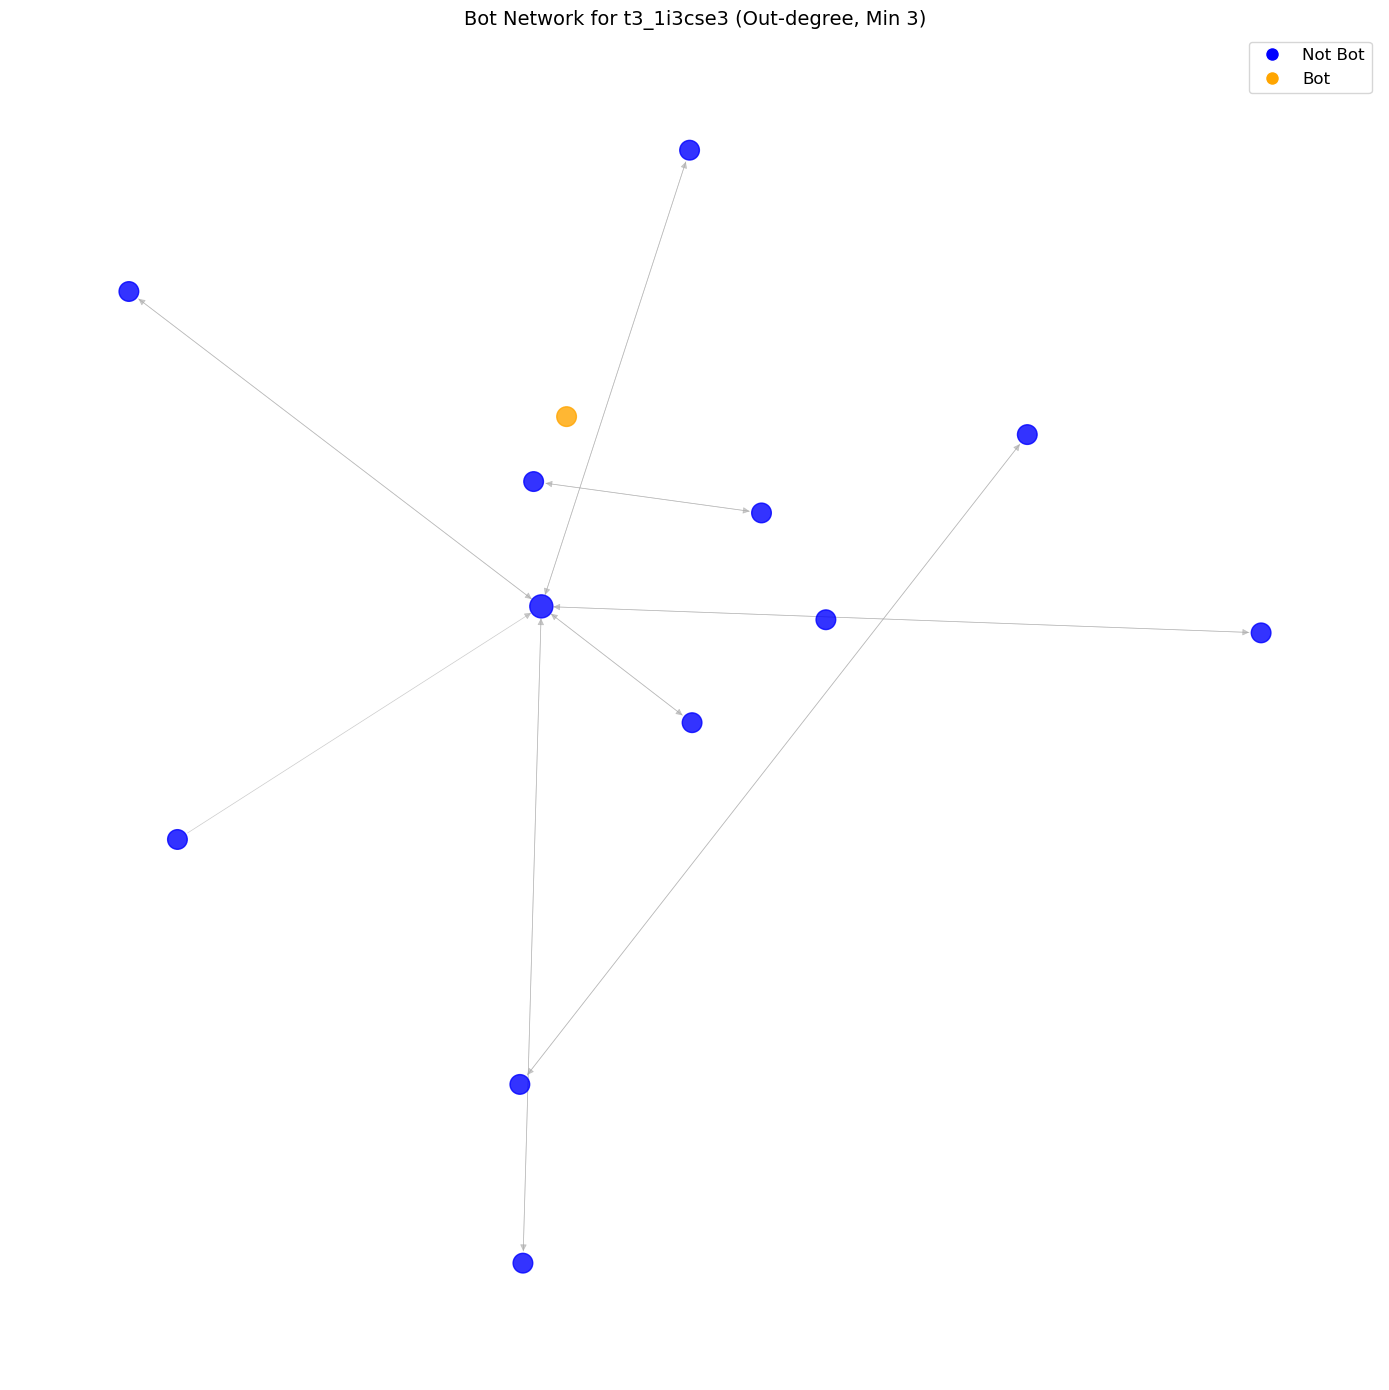

Initial Dictionary:
{'t2_6ulap': 0.0, 't2_1fwpskfj3y': 0.0, 't2_vlayp58o': 0.015151515151515152, 't2_5rnlo': 0.012987012987012988, 't2_vn4n524': 0.0, 't2_1ljx6geo': 0.0, 't2_tj33gfvh': 0.012987012987012988, 't2_2z43dwgj': 0.0, 't2_8l5oztgr': 0.0, 't2_aojxxp4jk': 0.0, 't2_2md6etu3': 0.0, 't2_j9m0g71m': 0.012987012987012988, 't2_qkfuh': 0.0, 't2_94jte': 0.0, 't2_9elrjr80a': 0.0, 't2_3zjumcm': 0.0, 't2_ae0yxhyg': 0.0, 't2_2wlwjxrr': 0.0, 't2_4adljrxl': 0.015151515151515152, 't2_k8a2ewca3': 0.0, 't2_pezmqpovi': 0.0, 't2_52gktofq': 0.0, 't2_vzxwynqkh': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_vlayp58o  : 0.015151515151515152   human
t2_4adljrxl  : 0.015151515151515152   human
t2_5rnlo  : 0.012987012987012988   human
t2_tj33gfvh  : 0.012987012987012988   human
t2_j9m0g71m  : 0.012987012987012988   human
t2_6ulap  : 0.0   human
t2_1fwpskfj3y  : 0.0   human
t2_vn4n524  : 0.0   human
t2_1ljx6geo  : 0.0   human
t2_2z43dwgj  : 0.0   human


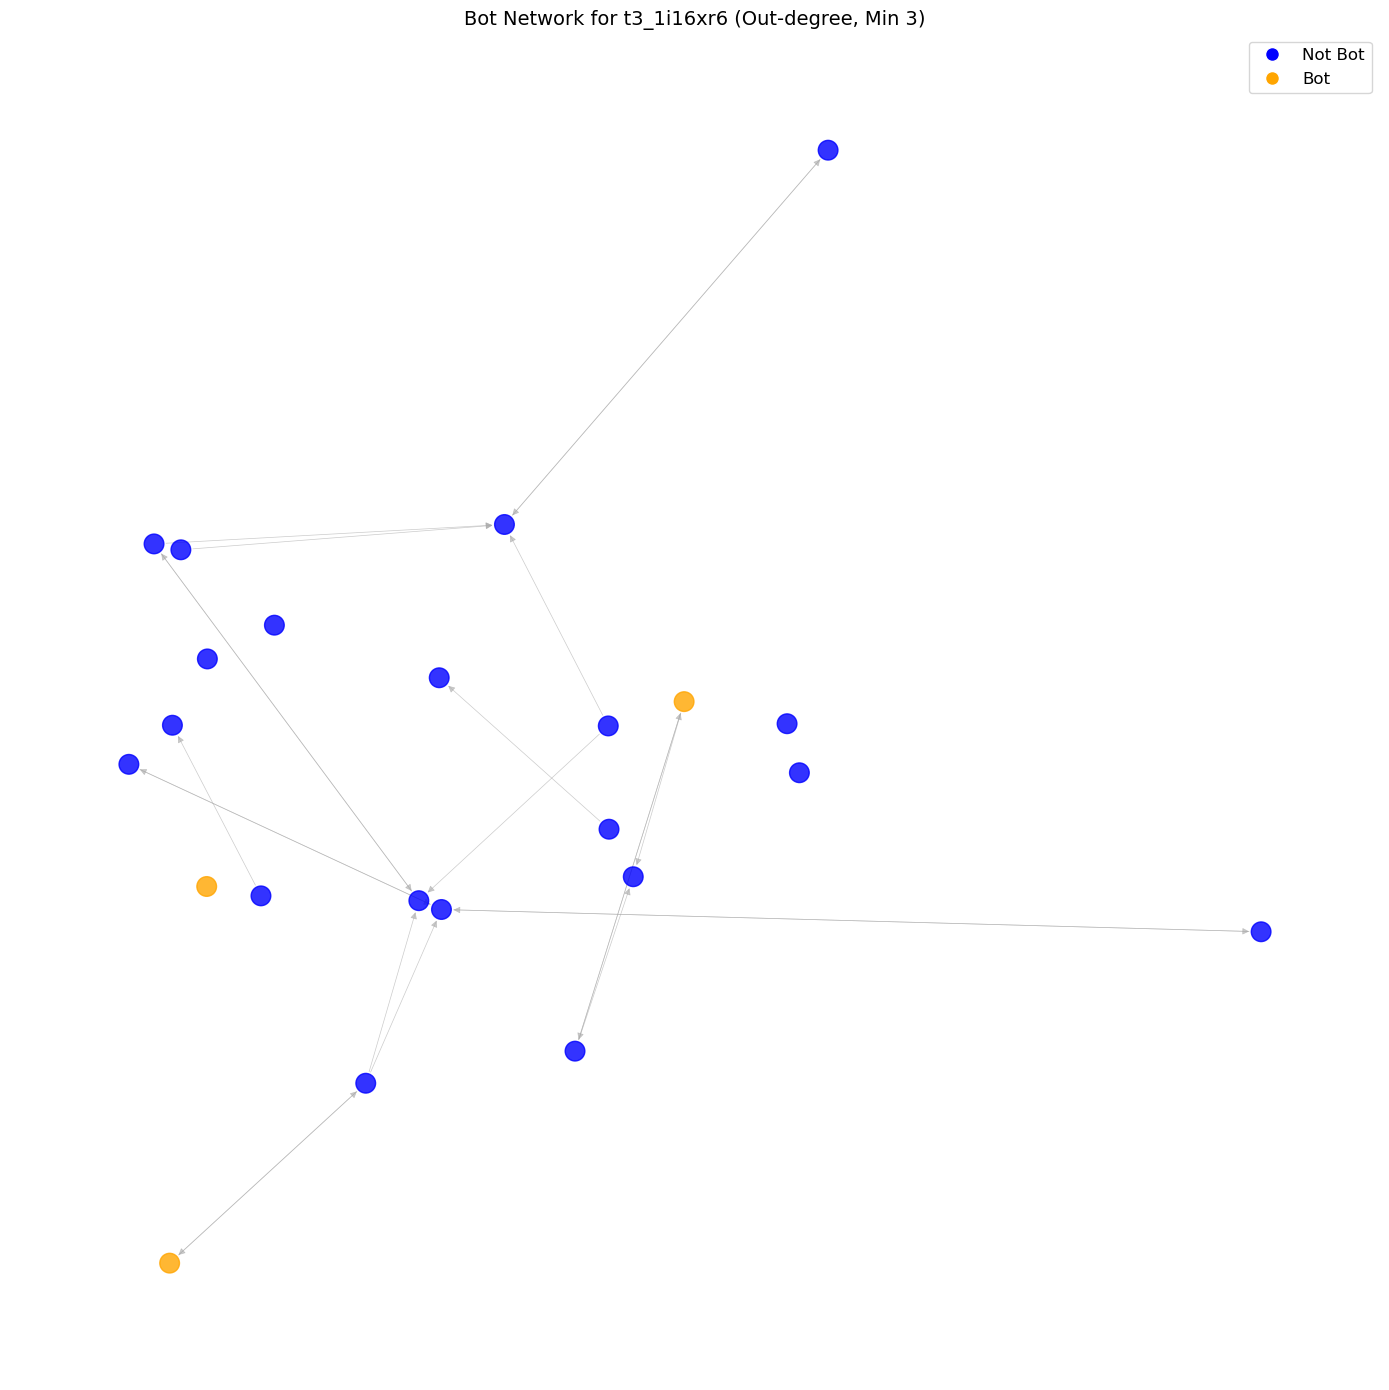

Initial Dictionary:
{'t2_g1wkr9ko': 0.006387921022067363, 't2_tp9fy': 0.017421602787456445, 't2_alv7u7l0t': 0.0, 't2_qcbf1af59': 0.0, 't2_1nz7g7rq': 0.0, 't2_86n4bwo0': 0.0, 't2_giu07df5': 0.018583042973286876, 't2_kwbjdmb': 0.0, 't2_r6n1nyol': 0.0, 't2_v0yfjlo0': 0.0005807200929152149, 't2_wb682': 0.0, 't2_qg9ep': 0.0, 't2_15tmeo': 0.012775842044134726, 't2_uublqu5p': 0.0, 't2_gn5lu599d': 0.0, 't2_8096b': 0.0, 't2_15dotc': 0.0, 't2_139kwlu0qz': 0.0, 't2_9ljhf8jkx': 0.009872241579558653, 't2_6cvu7': 0.0, 't2_1ahncy8klp': 0.015098722415795587, 't2_1b22e2n6sq': 0.007549361207897794, 't2_7xrls': 0.006387921022067363, 't2_pticjc49': 0.0, 't2_1eldusvom3': 0.0, 't2_qk7cf14q': 0.04065040650406504, 't2_wd13k': 0.0, 't2_12cqit': 0.0, 't2_ue0gk': 0.0, 't2_pyl4s9o': 0.0, 't2_1eor2qrg7g': 0.0017421602787456446, 't2_3u8o3ofr': 0.0, 't2_4kbqcotb': 0.0, 't2_l3mfs': 0.0, 't2_n14lks7l': 0.0, 't2_ncohuuhxn': 0.004065040650406504, 't2_oswvl': 0.0, 't2_ftorw2r8': 0.0, 't2_9f0t22rx': 0.0, 't2_6jcbb': 0.0, 

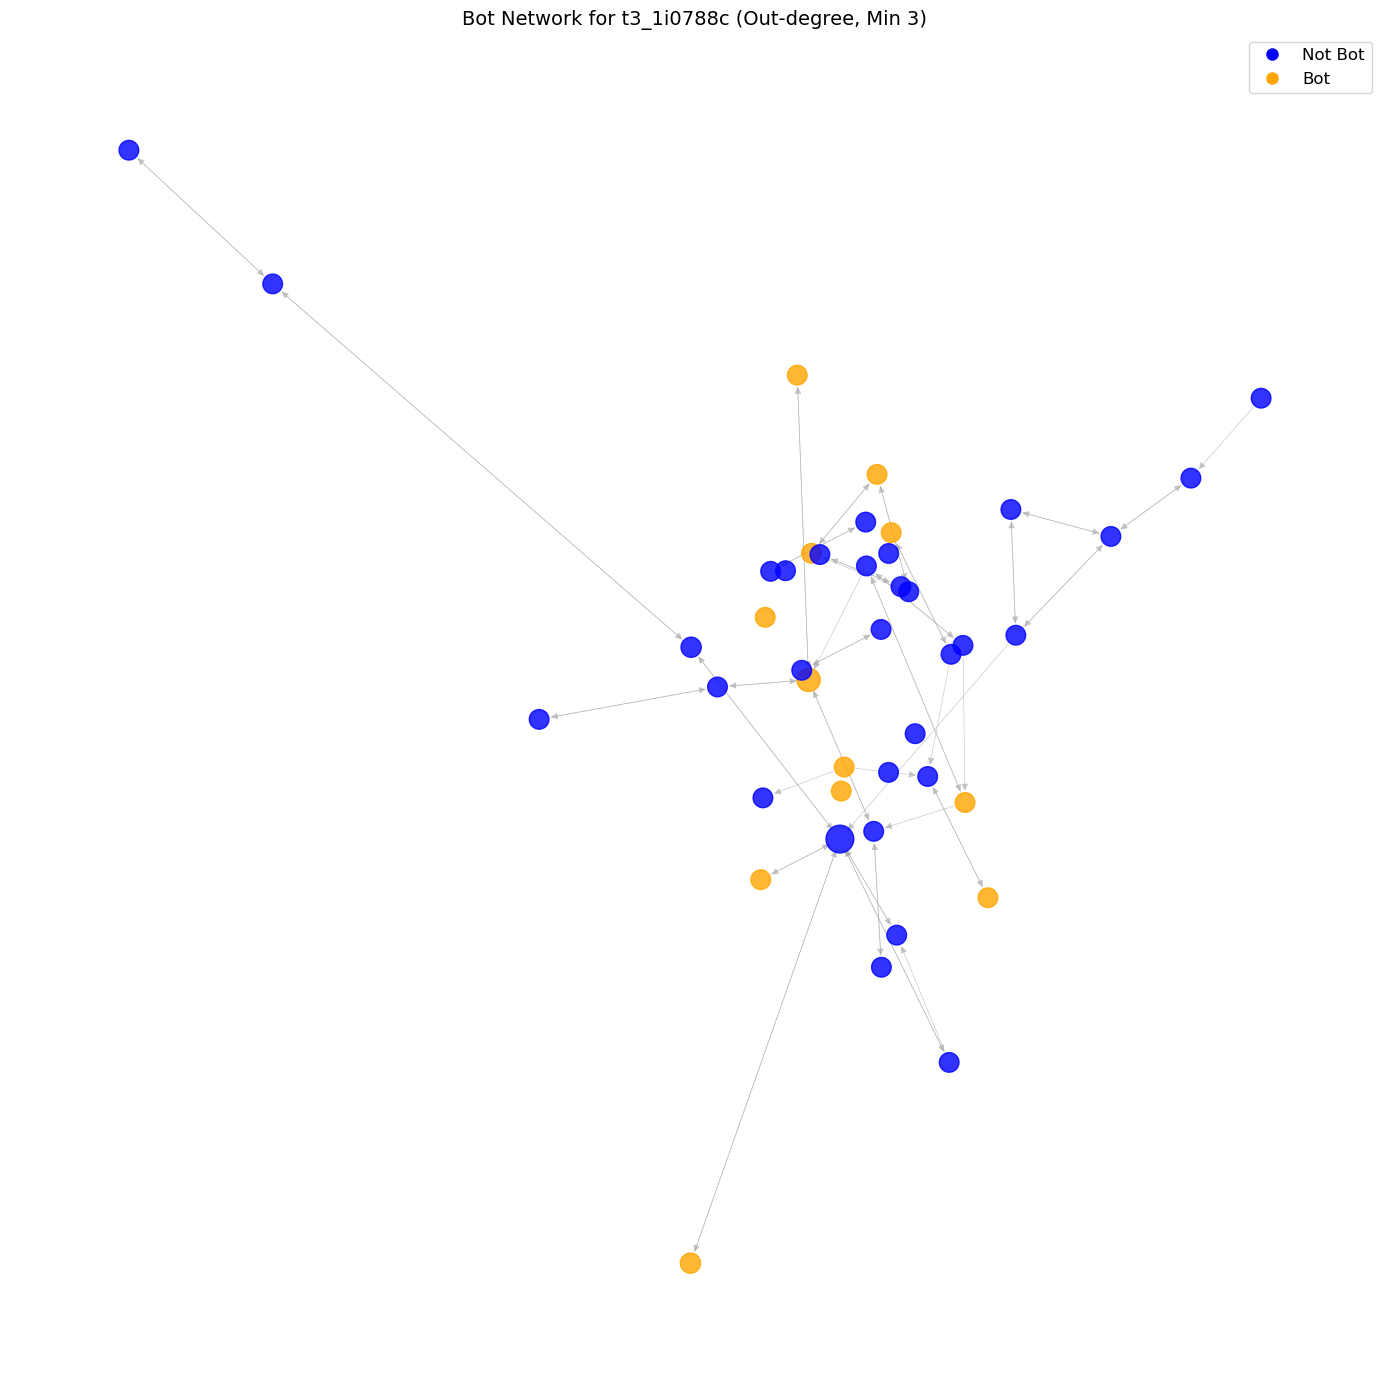

Initial Dictionary:
{'t2_mm7m0ccve': 0.00015055706112616682, 't2_29iwtb62': 0.0, 't2_nhku54oy5': 0.0006022282445046673, 't2_4140kyai': 0.05461457392351701, 't2_et93i6rsc': 0.0, 't2_5etovt5jw': 0.006323396567299007, 't2_mzow4uf8': 0.0, 't2_ygnrp69ts': 0.0, 't2_q82wibl1': 0.0, 't2_vr3pgnhx': 0.0, 't2_2frt7jv9': 0.0004516711833785005, 't2_84vc0uib': 0.0, 't2_7gztzgdq': 0.0004516711833785005, 't2_xszl2xe8a': 0.0, 't2_8d5mpkik': 0.0, 't2_7uqaw4t4': 0.0, 't2_4exb0m5g': 0.0, 't2_85z04kuoa': 0.0, 't2_3jwrn': 0.0, 't2_kiz9c0x8q': 0.0, 't2_d28i12dy8': 0.00331225534477567, 't2_hihf392kq': 0.0006022282445046673, 't2_1hl98tzaiu': 0.004930743751881963, 't2_dhs5poc3': 0.0, 't2_wd33n': 0.0, 't2_575hwg3g': 0.0, 't2_bt9tauvca': 0.0, 't2_lrocyhsff': 0.0, 't2_zwka19qoc': 0.0, 't2_jcx8jw7': 0.0, 't2_1huueya9ul': 0.0, 't2_3uefgags': 0.0, 't2_b4m446a': 0.0, 't2_1ahncy8klp': 0.0, 't2_11yzwu': 0.0, 't2_14jdz579e4': 0.0031616982836495033, 't2_6j5nghdv': 0.0, 't2_1gvozskix8': 0.0, 't2_ydtsayo28': 0.0, 't2_19rlsh

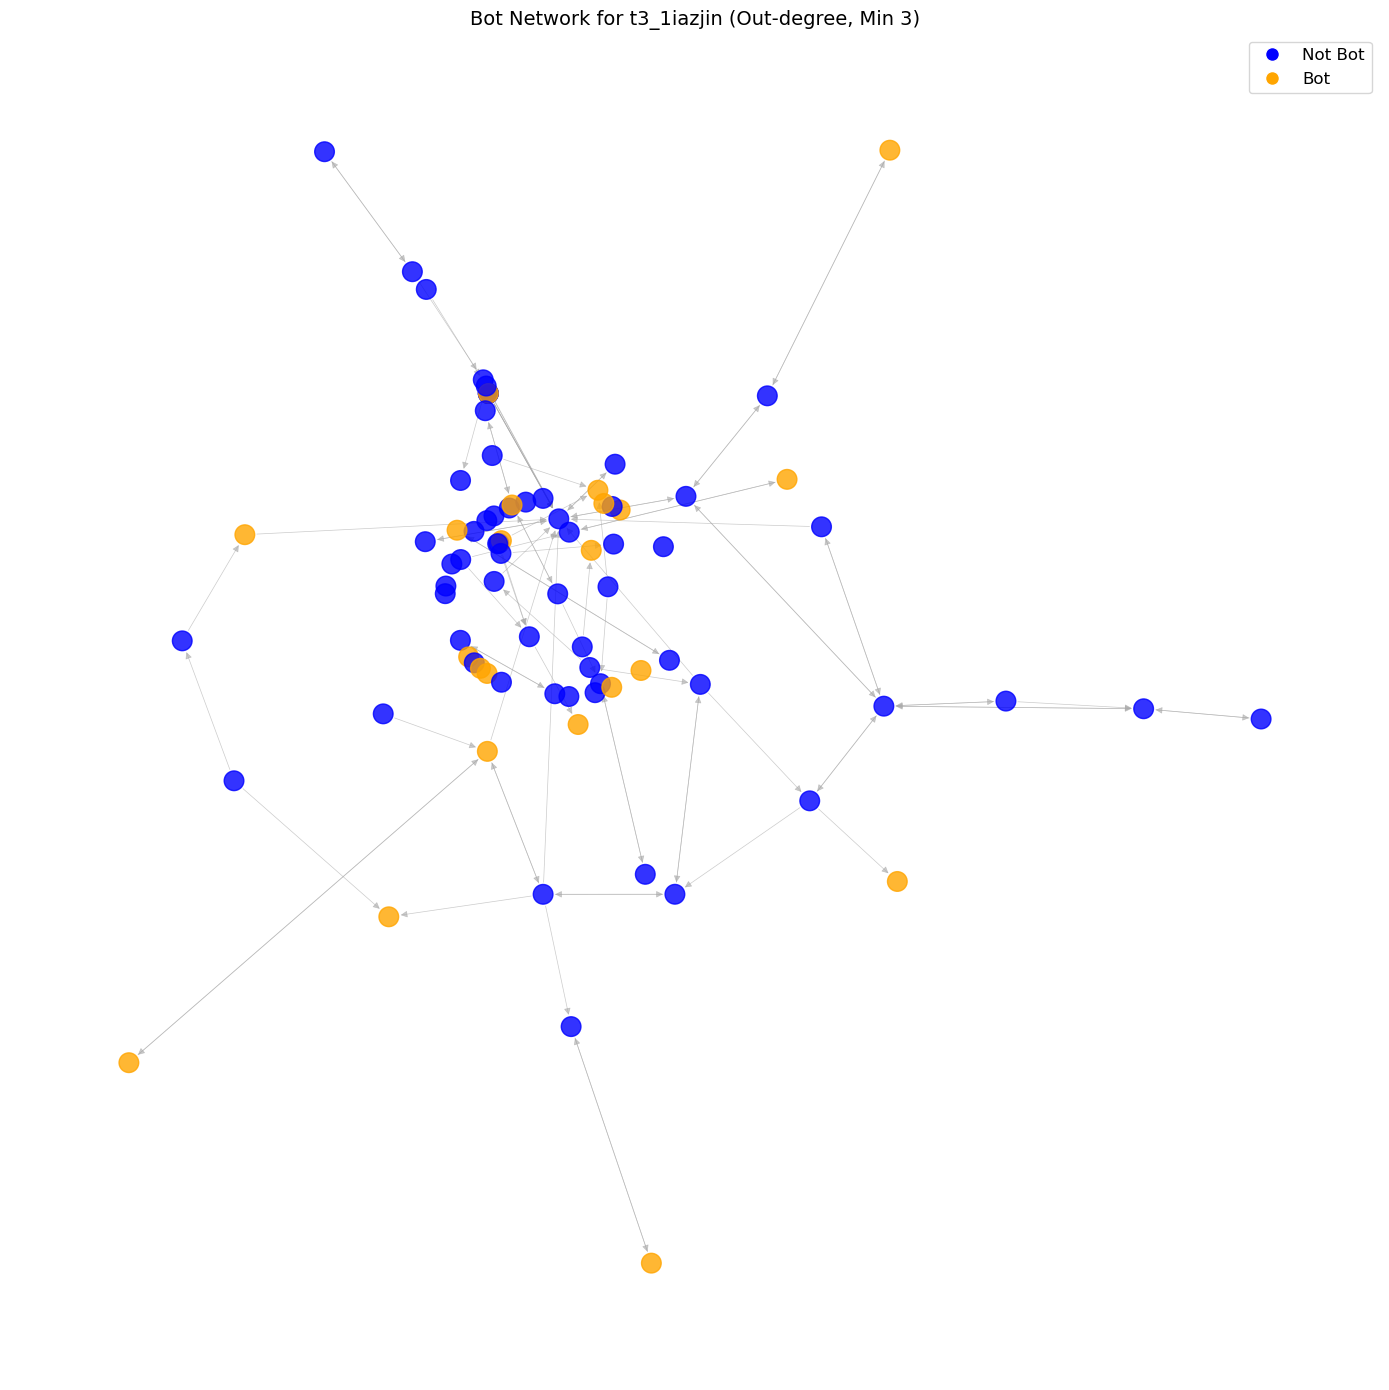

In [35]:
for post in posts: # loop through all 11 posts
    G, plot = plot_network_degree(post, post_node_edge_dict, thr_70, min_degree = 3)
    top_betweenness(G)
    plot.show()

### Using Indegree

Initial Dictionary:
{'t2_12i5fn4j0r': 0.0, 't2_vubljqn9': 0.0, 't2_adxr5': 0.007039337474120083, 't2_ojs8w74': 0.0, 't2_4dfhg': 0.006625258799171843, 't2_keblrri9t': 0.0, 't2_67wqo': 0.006625258799171843, 't2_4wbuk': 0.0, 't2_xkmak': 0.0, 't2_u3kqaqz1': 0.0, 't2_3m0ag9v5': 0.0, 't2_9450jcss': 0.0, 't2_167b1szk0w': 0.0, 't2_6bcb2': 0.0023809523809523807, 't2_c8qzk': 0.0, 't2_aoaof092': 0.0, 't2_4bvy7ob6': 0.0038302277432712213, 't2_ql7hqb7c': 0.0, 't2_absgv': 0.0, 't2_5qpqw': 0.0008281573498964803, 't2_5rji2ist8': 0.008385093167701863, 't2_2i8x35z0': 0.0, 't2_bno90': 0.017080745341614908, 't2_8in5e': 0.008695652173913044, 't2_egs9n': 0.0010351966873706005, 't2_4twue': 0.0, 't2_9rytu': 0.00020703933747412008, 't2_2vt4a4vf': 0.0033126293995859213, 't2_eqek25kcg': 0.0014492753623188406, 't2_66tna': 0.0, 't2_93aqu': 0.01956521739130435, 't2_se4sn': 0.0010351966873706005, 't2_7lib5': 0.0, 't2_7v20osyw': 0.0, 't2_8vtkt4o': 0.00020703933747412008, 't2_cyjzy': 0.0, 't2_9vlir': 0.000414078674948

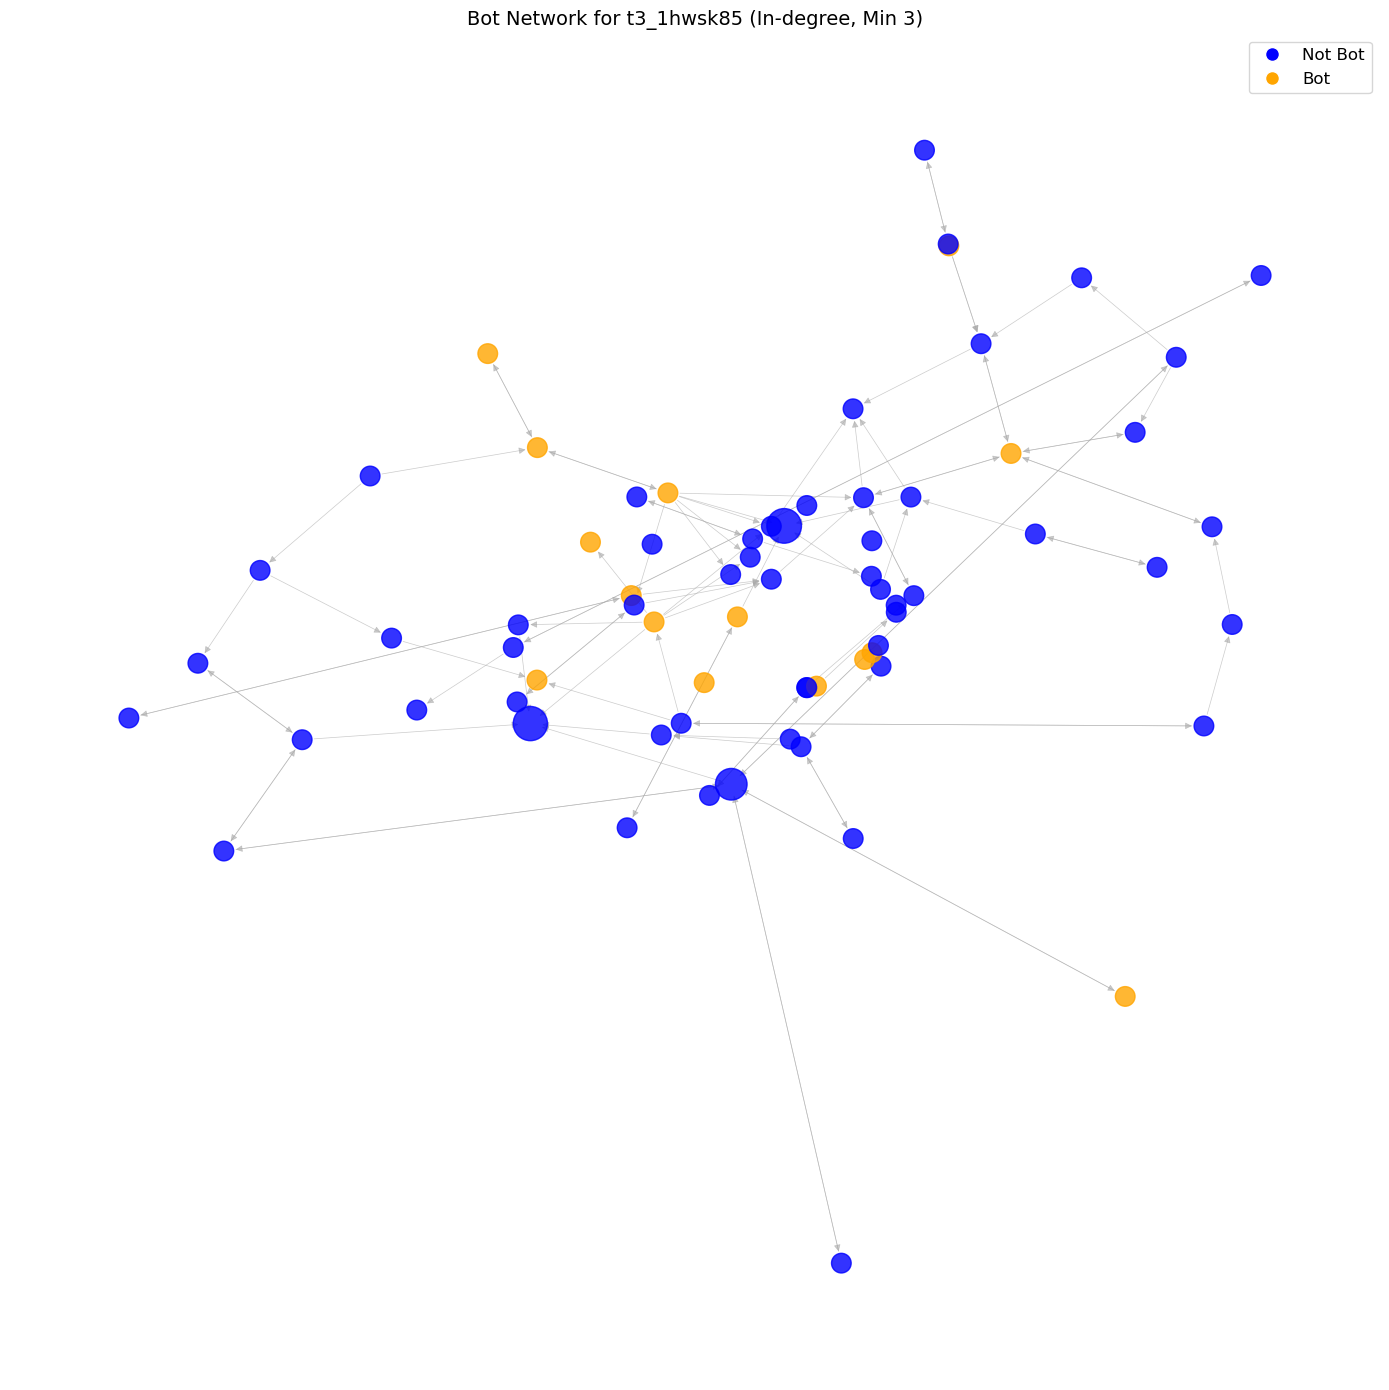

Initial Dictionary:
{'t2_13ukpn': 0.0, 't2_im1ux': 0.0, 't2_121wgh': 0.0, 't2_1ucdyz24': 0.012373737373737374, 't2_gurm88im9': 0.0, 't2_68petbf': 0.0, 't2_by2pkeg5': 0.03358585858585859, 't2_mk4ltkhj': 0.0, 't2_8l0g7jqf': 0.00404040404040404, 't2_k51bnotc': 0.05244107744107744, 't2_navwx': 0.011868686868686869, 't2_5orwrgxy': 0.002525252525252525, 't2_ctj1o': 0.00505050505050505, 't2_q3kxp': 0.00404040404040404, 't2_39zsy1nh': 0.023737373737373738, 't2_12kwn5r226': 0.026515151515151516, 't2_shau5s28': 0.011111111111111112, 't2_hj7xazqd': 0.0, 't2_3wch9jej': 0.028282828282828285, 't2_dkhiquer6': 0.00202020202020202, 't2_yyafc1xkc': 0.0, 't2_6nh7k': 0.00101010101010101, 't2_uvc0rlgf': 0.0, 't2_7368ijb0': 0.00404040404040404, 't2_4mtdh': 0.0, 't2_9vvpj': 0.02727272727272727, 't2_gdzkjzf5': 0.008249158249158249, 't2_nvbb3634': 0.0, 't2_52fxikxe': 0.005892255892255892, 't2_by859': 0.0, 't2_76j1r': 0.0, 't2_15pzmo': 0.0, 't2_idhn4wf': 0.000505050505050505, 't2_2s59qw80': 0.0, 't2_72ugq78o': 

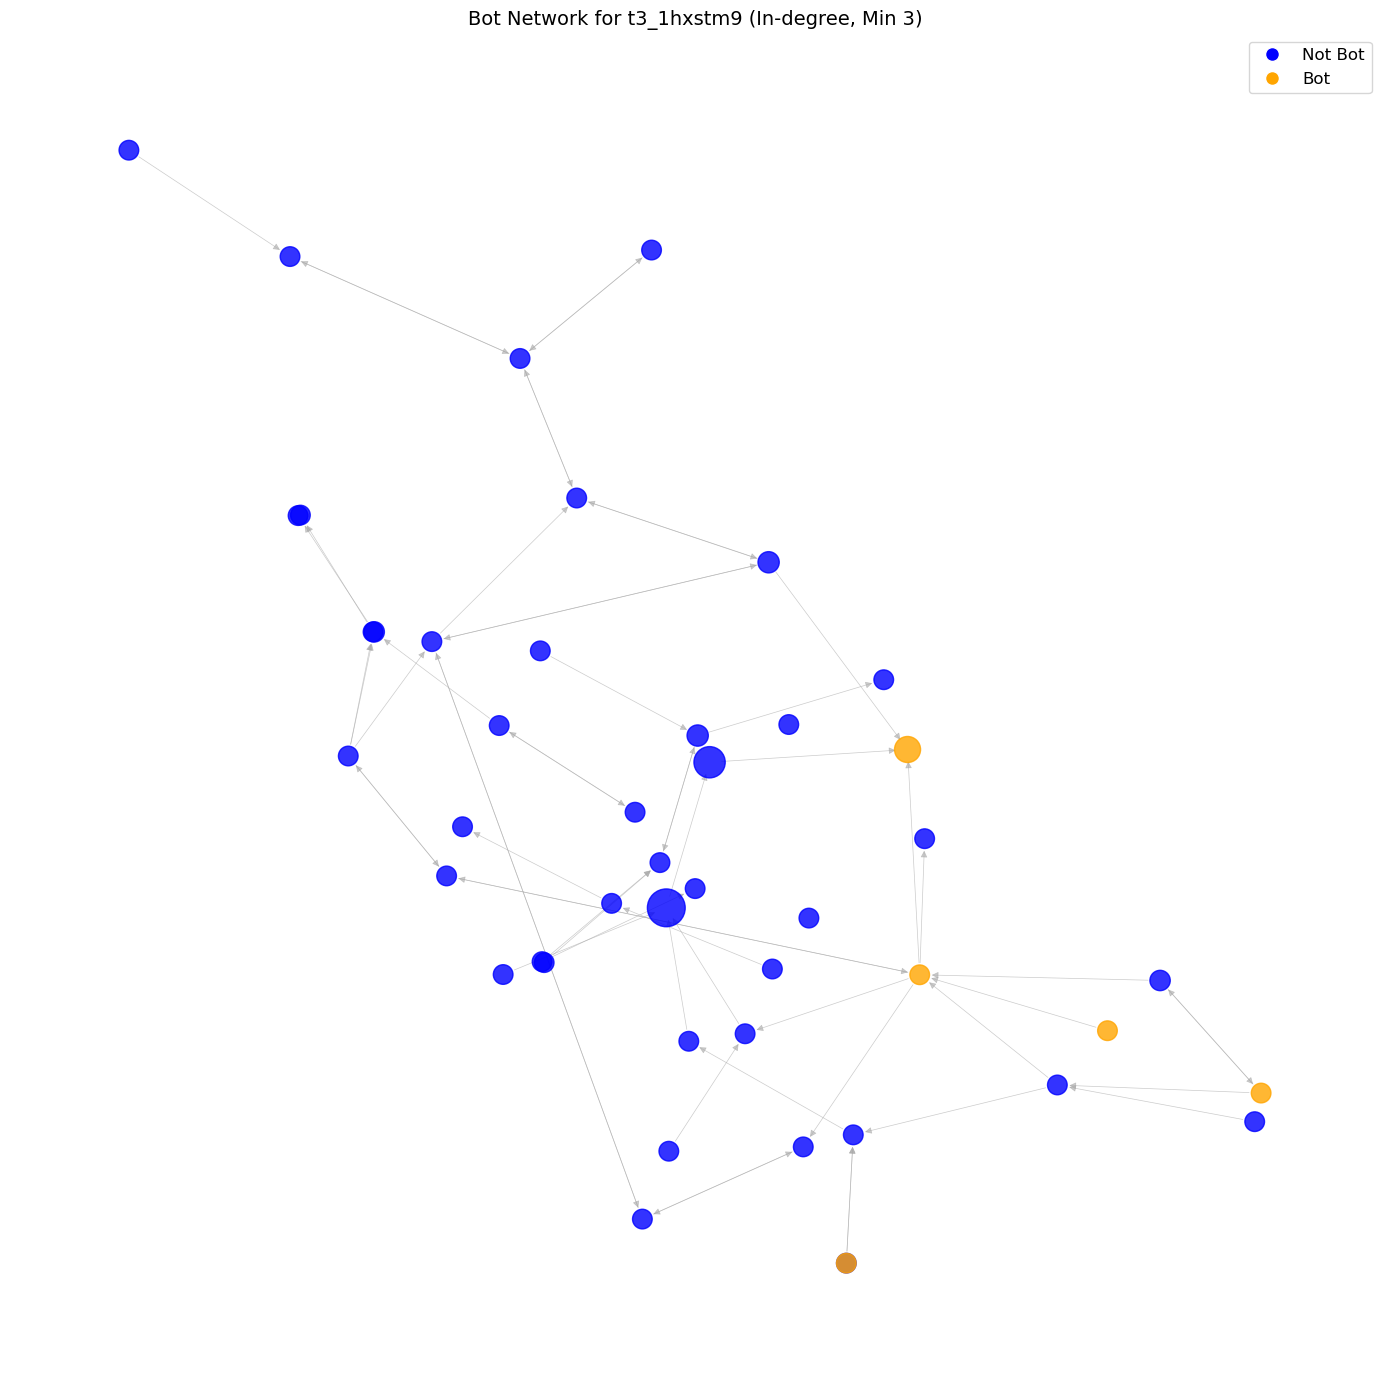

Initial Dictionary:
{'t2_lst66ur1': 0.0, 't2_32gkguod': 0.0, 't2_5h7n767h': 0.0, 't2_tkfvnsmlc': 0.0, 't2_13f7blo': 0.0, 't2_ts3xkfio1': 0.0, 't2_1epclhfffo': 0.8571428571428571, 't2_1dyh3sfq6v': 0.0, 't2_6f54jnmo': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_1epclhfffo  : 0.8571428571428571   human
t2_lst66ur1  : 0.0   human
t2_32gkguod  : 0.0   human
t2_5h7n767h  : 0.0   human
t2_tkfvnsmlc  : 0.0   human
t2_13f7blo  : 0.0   human
t2_ts3xkfio1  : 0.0   human
t2_1dyh3sfq6v  : 0.0   bot
t2_6f54jnmo  : 0.0   human


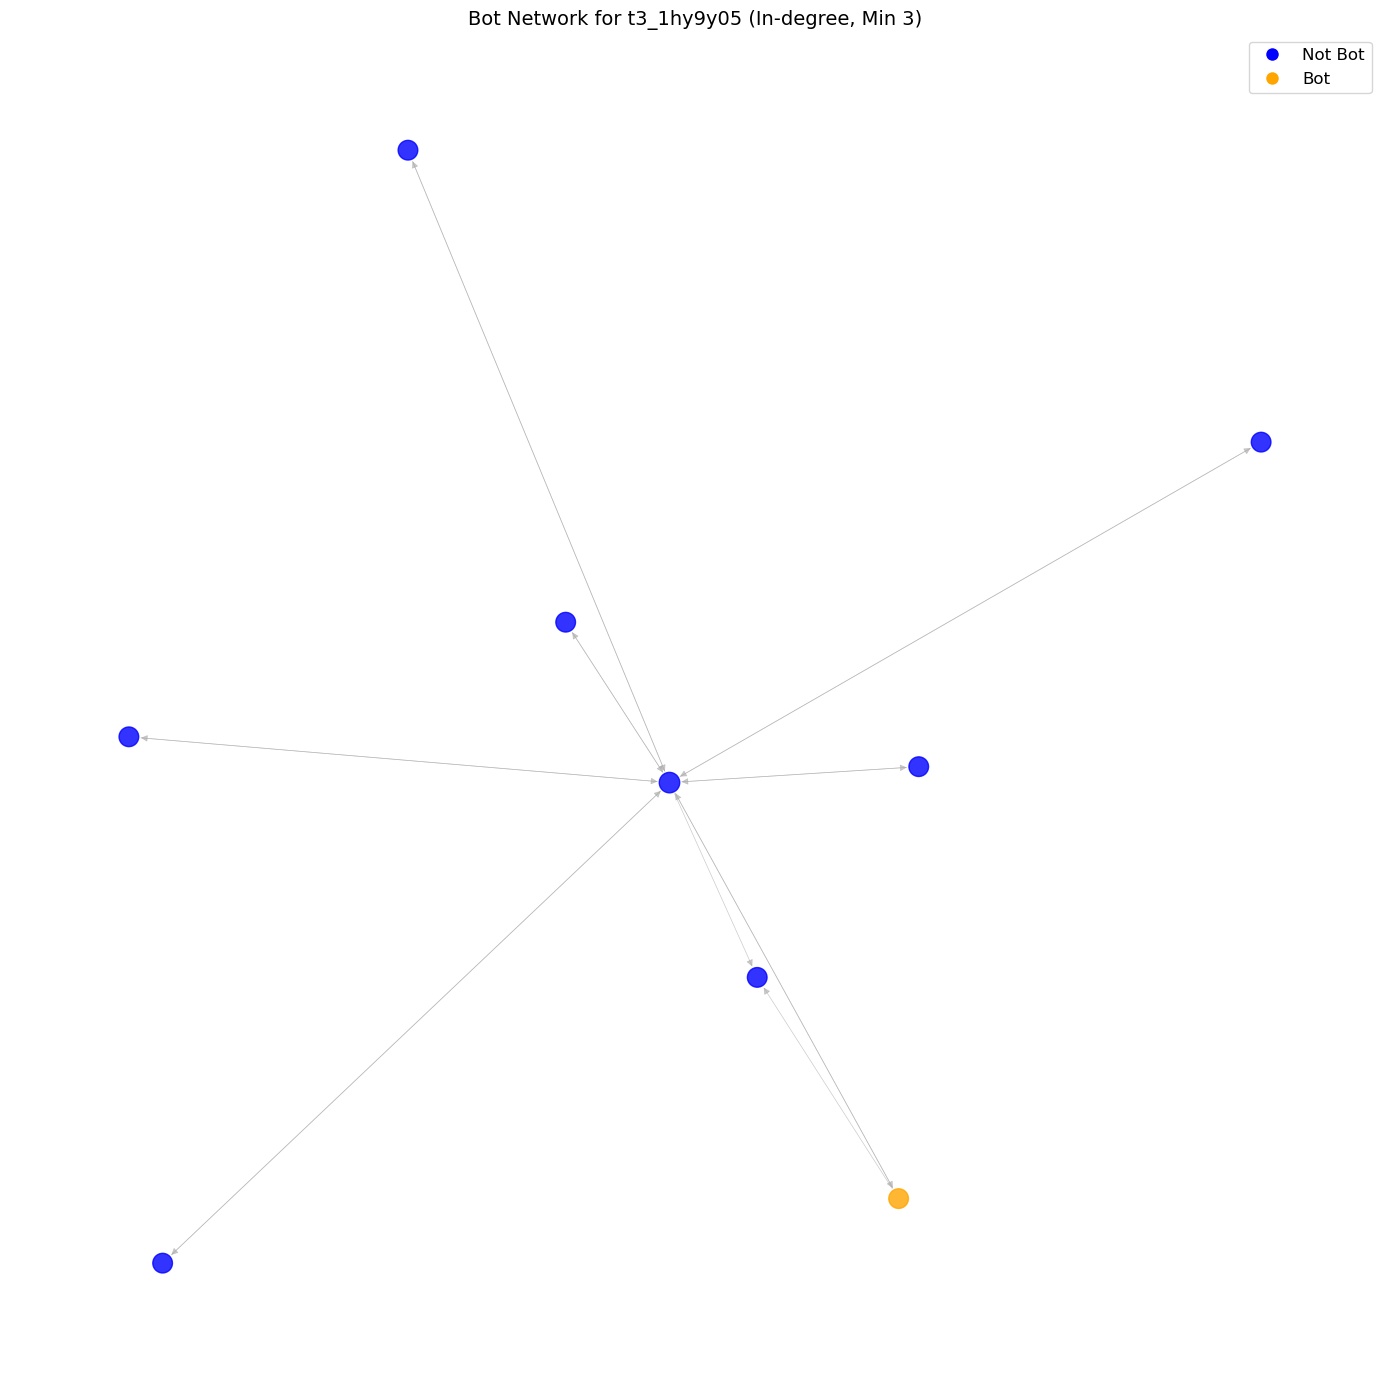

Initial Dictionary:
{'t2_ecc7w': 0.10572118702553486, 't2_1l0vba': 0.0, 't2_12qxit': 0.0, 't2_3v43v': 0.0, 't2_9q1uyk0x': 0.14699792960662525, 't2_avixr': 0.0, 't2_rekwy': 0.011180124223602485, 't2_hn17g': 0.020289855072463767, 't2_l4k8xo8q': 0.0, 't2_y7fx6': 0.0009316770186335404, 't2_p7mnzeamj': 0.0, 't2_gn65nija': 0.0, 't2_3718c': 0.010973084886128364, 't2_114bhb': 0.0, 't2_qg7iec8r': 0.0, 't2_4r7pz': 0.1805106970324362, 't2_a8hy2szz': 0.0, 't2_g0rtv': 0.009937888198757764, 't2_trqpd': 0.0436128364389234, 't2_snaps': 0.03809523809523809, 't2_ojxfx': 0.05054175293305728, 't2_elee5': 0.1842270531400966, 't2_ikq8r': 0.03573153899240856, 't2_9jteq': 0.0, 't2_9xogj': 0.013612836438923396, 't2_ihdrn': 0.013768115942028985, 't2_113fhr': 0.06438923395445134, 't2_e5kuh': 0.009316770186335404, 't2_cag3a': 0.2639337474120083, 't2_8x1m3ey5': 0.06490683229813665, 't2_lrytuy0bv': 0.0, 't2_bf20u': 0.17375776397515524, 't2_du3j2': 0.0, 't2_dguxi': 0.00041407867494824016, 't2_oueof': 0.0, 't2_c93ad'

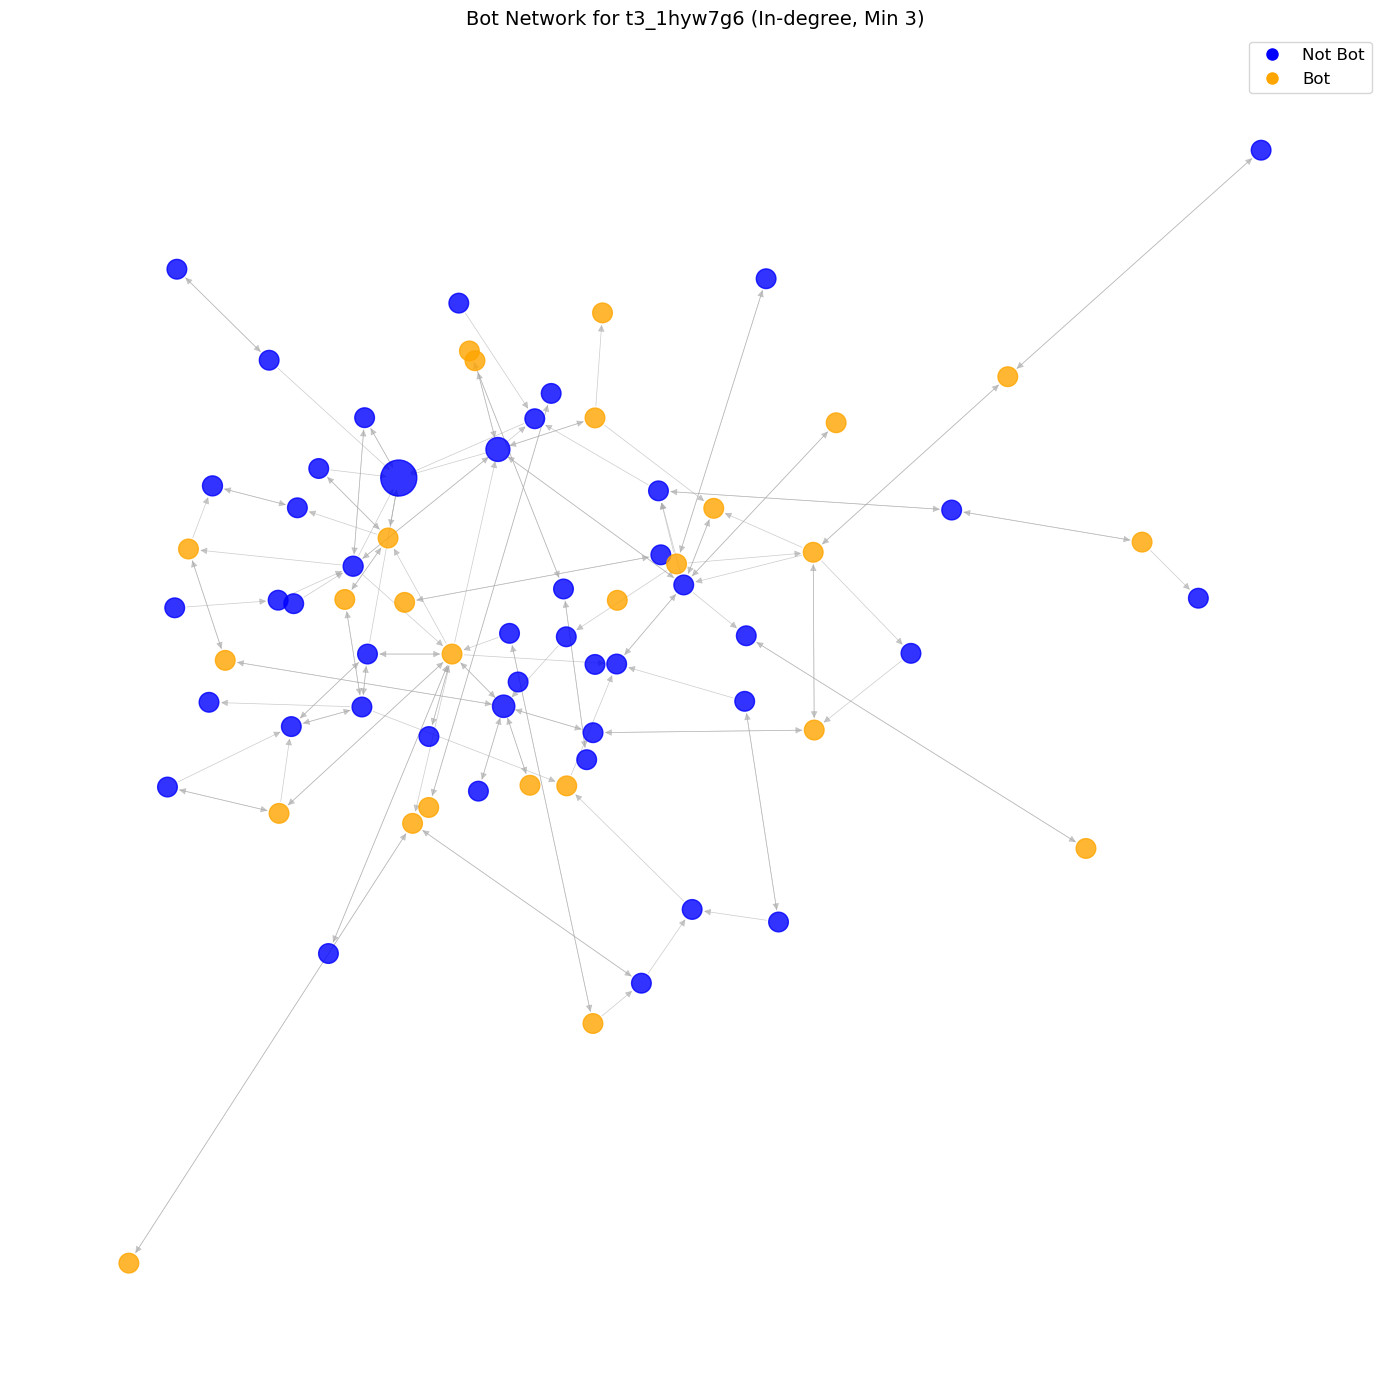

Initial Dictionary:
{'t2_plvww': 0.0, 't2_6ukxd': 0.0, 't2_7wmiopsf4': 0.0, 't2_f8v6n0zj': 0.0, 't2_15s5hcu81d': 0.0, 't2_m2a6mv0p': 0.0, 't2_4m8s2t37': 0.0, 't2_vkqcq6c2': 0.0, 't2_st01pgrii': 0.0, 't2_1bq06wodv4': 0.0, 't2_1hmea6vy': 0.01282051282051282, 't2_drjxotfm4': 0.01282051282051282, 't2_lf58eu5l': 0.0, 't2_e8igtvtx': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_1hmea6vy  : 0.01282051282051282   human
t2_drjxotfm4  : 0.01282051282051282   human
t2_plvww  : 0.0   human
t2_6ukxd  : 0.0   human
t2_7wmiopsf4  : 0.0   human
t2_f8v6n0zj  : 0.0   human
t2_15s5hcu81d  : 0.0   human
t2_m2a6mv0p  : 0.0   human
t2_4m8s2t37  : 0.0   bot
t2_vkqcq6c2  : 0.0   bot


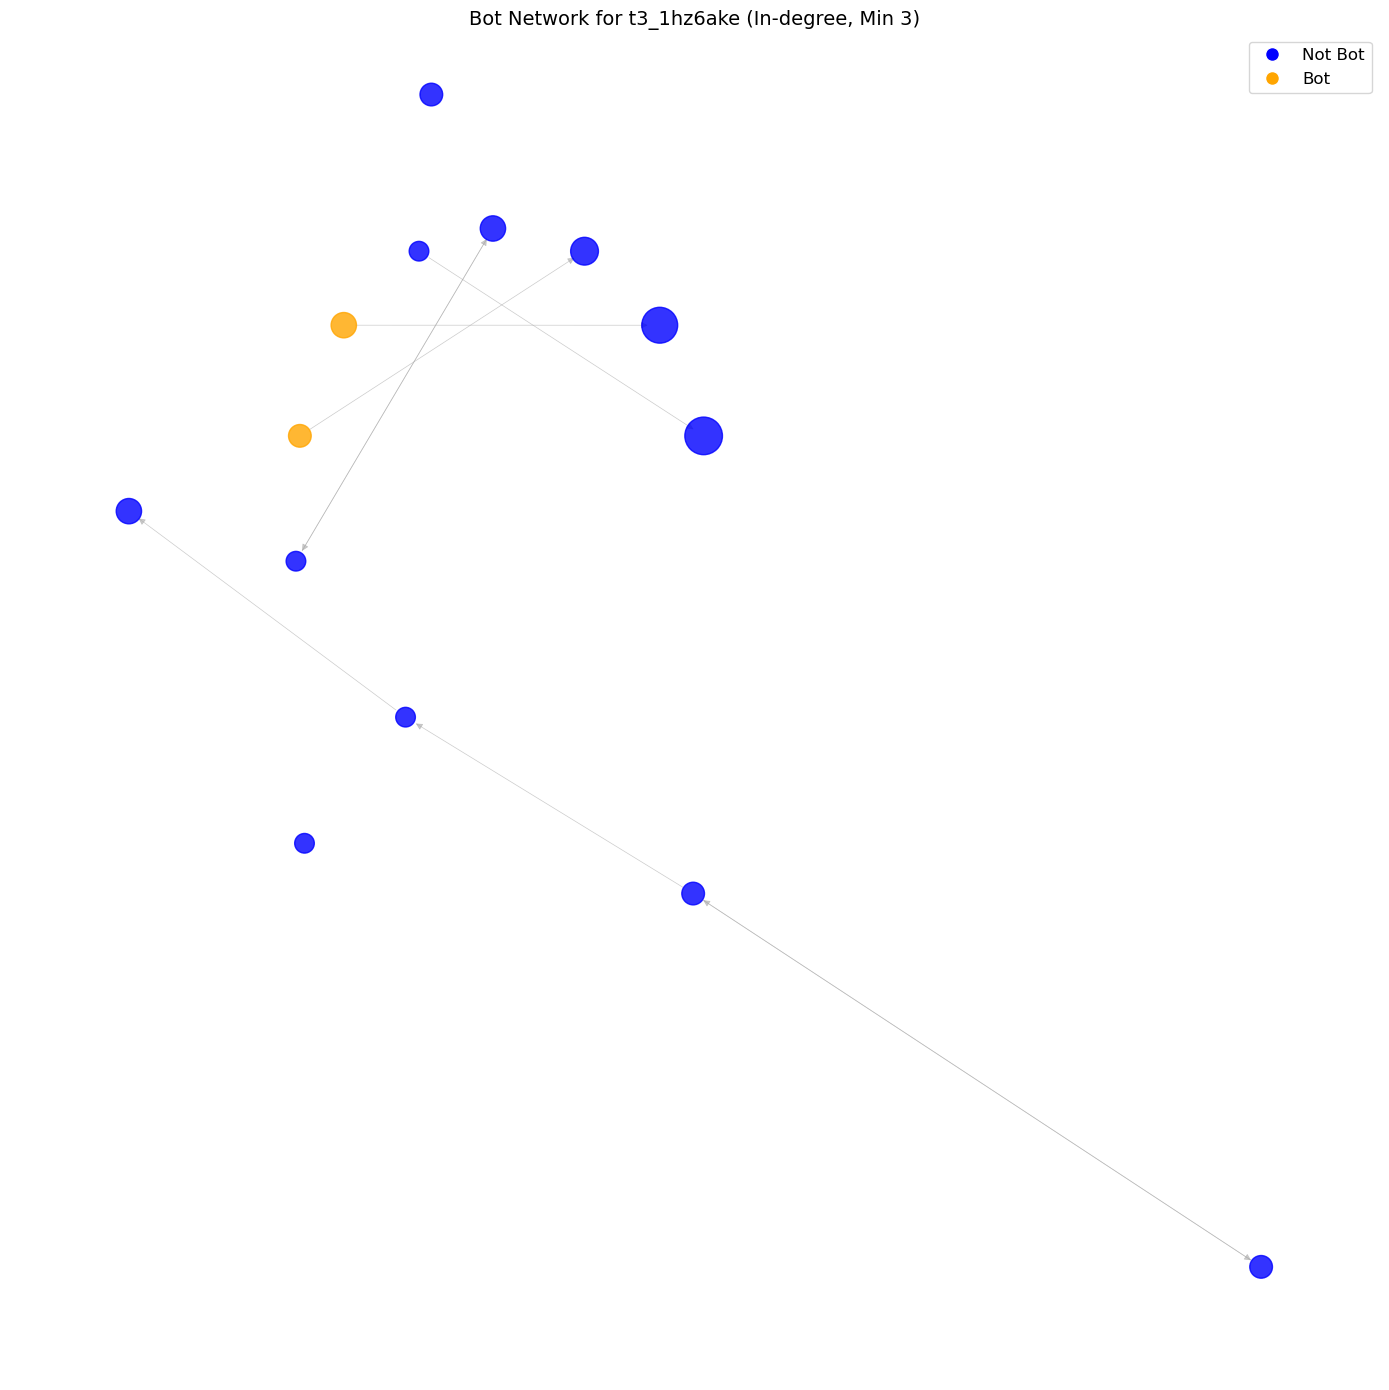

Initial Dictionary:
{'t2_2hm6l94u': 0.1217391304347826, 't2_11lqath1sd': 0.0, 't2_6jjfisov': 0.0, 't2_mrac3': 0.0, 't2_ijns0q0bv': 0.033816425120772944, 't2_r4zx1zd1': 0.19855072463768114, 't2_ovfjc': 0.0, 't2_40u7q': 0.0, 't2_hyr5mz8kr': 0.0, 't2_ki4a6': 0.0, 't2_4om8rmo': 0.0, 't2_5gf92jwj': 0.0, 't2_xjabn': 0.050241545893719805, 't2_1d3nnfsf': 0.1106280193236715, 't2_elvszk': 0.0, 't2_9gv15v8v': 0.14106280193236714, 't2_b2js3nmeo': 0.0, 't2_3rva17ms': 0.005797101449275362, 't2_awk13': 0.0, 't2_k36l1ydf': 0.03671497584541063, 't2_tb0leam22': 0.050241545893719805, 't2_r3tzl': 0.10966183574879226, 't2_dijcchf9': 0.0, 't2_wbfb7': 0.0, 't2_1fjwneinop': 0.121256038647343, 't2_rg4zxpty': 0.04565217391304348, 't2_6bcto': 0.05289855072463768, 't2_831d5we0': 0.00821256038647343, 't2_a4x9zk6cx': 0.029468599033816423, 't2_d49cj6qd': 0.11256038647342995, 't2_9o8uo1o1': 0.0, 't2_brjfsxlpn': 0.11690821256038647, 't2_1k6jxow': 0.0, 't2_11cvygh5xm': 0.0, 't2_1awdfidkpt': 0.0, 't2_8fr47': 0.0, 't2_3f

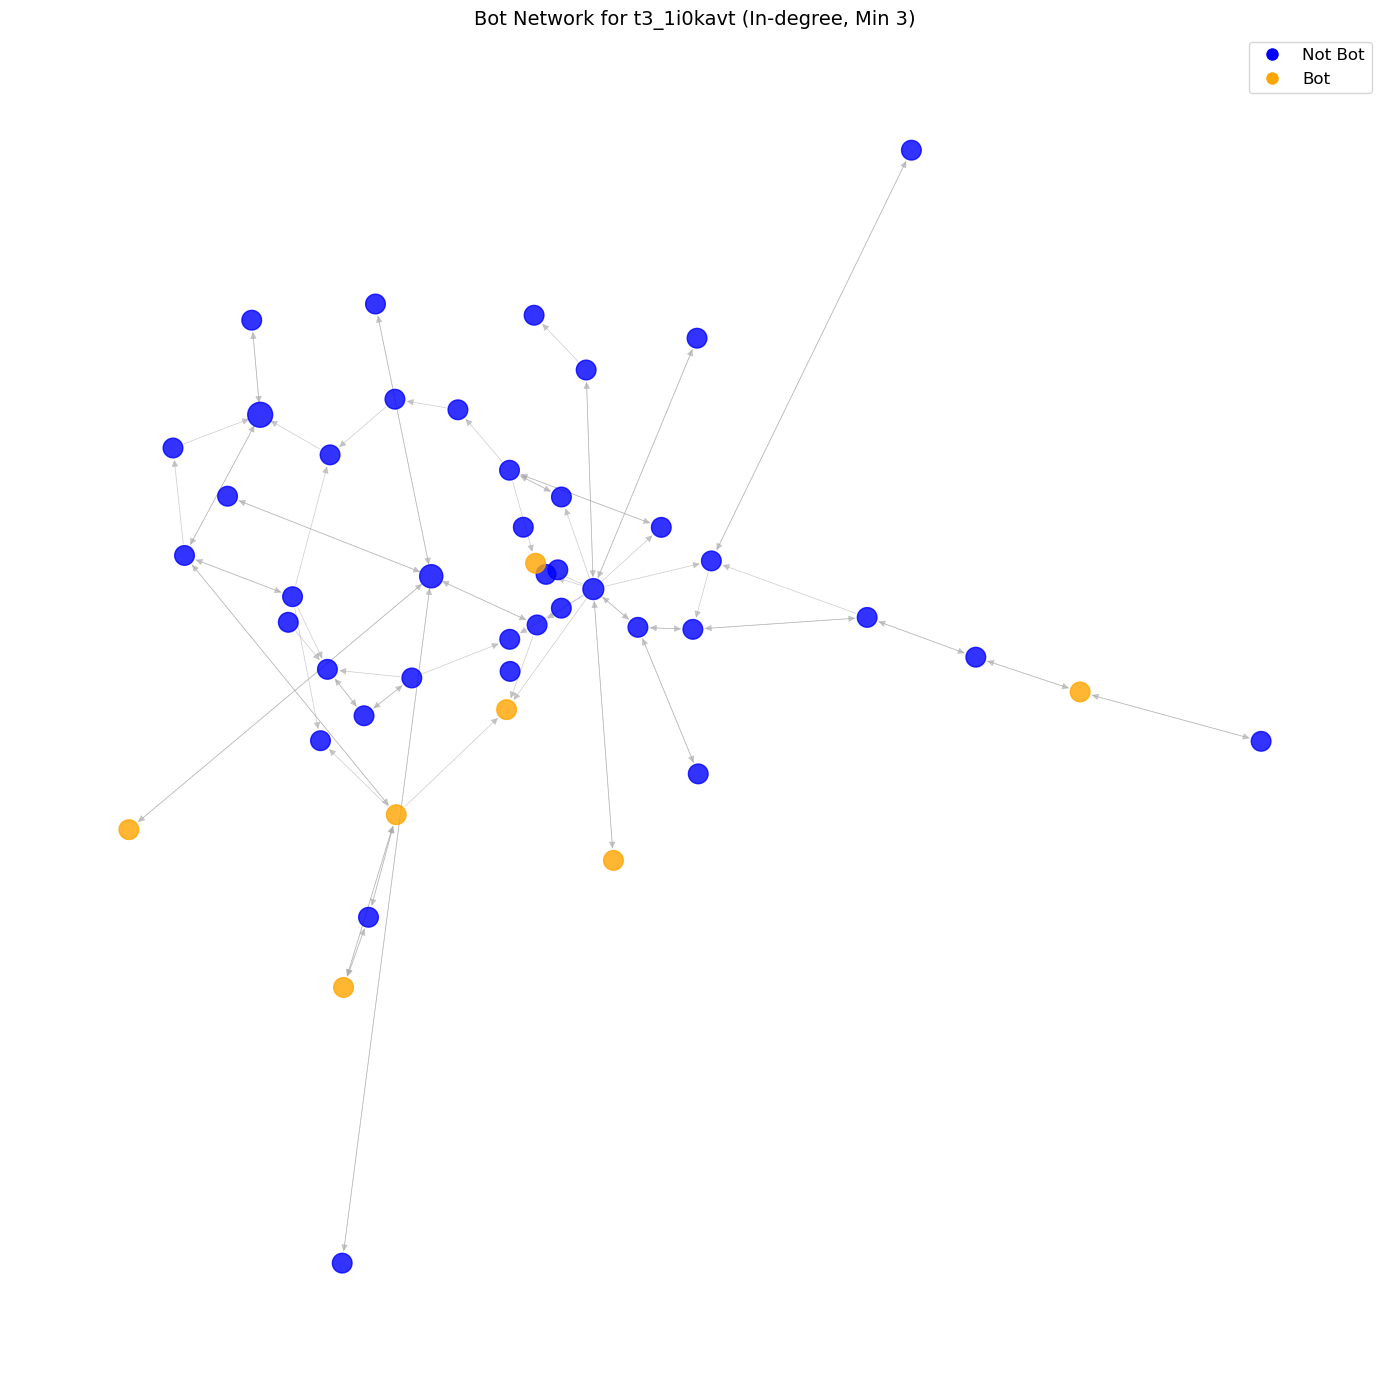

Initial Dictionary:
{'t2_9a7co': 0.0, 't2_o1jtvc6rk': 0.004551820728291316, 't2_8kmztost': 0.0109593837535014, 't2_prtspyjr': 0.0015406162464985994, 't2_od2zf4y0e': 0.0014705882352941176, 't2_59fn4lsf': 0.0007703081232492997, 't2_371x7bqn': 0.0, 't2_e3hu1js0': 0.0, 't2_116bx9614x': 0.004096638655462184, 't2_4dfhg': 0.0, 't2_fo1g3b0k': 0.0, 't2_7sd48mkay': 0.0, 't2_2u42pgmd': 0.0, 't2_17f4c9aq74': 0.0, 't2_18pfn343z4': 0.0018907563025210082, 't2_5h7me': 0.0, 't2_95ph63qo': 0.0, 't2_b6m9o7sip': 0.0, 't2_67h9ybx6': 0.0038515406162464984, 't2_y3zv6rsps': 0.0, 't2_8rjfdrn6': 0.0, 't2_fo9mq1t': 0.00021008403361344536, 't2_129ptznhoh': 0.0, 't2_fcykodeu': 0.00021008403361344536, 't2_1d9jq67d89': 0.0, 't2_1ag3x8m622': 0.0, 't2_7yacuo17': 3.5014005602240894e-05, 't2_9lrla7ff': 0.0024859943977591035, 't2_cxy1er0t': 0.0, 't2_a2h8txk4': 0.0, 't2_68yxeh75': 0.0014005602240896356, 't2_4i4ma': 0.0, 't2_10v8a7': 0.0, 't2_14oh5t4oww': 0.0, 't2_9dirjmk5': 0.0, 't2_a2pgvw41': 0.00014005602240896358, 't2_

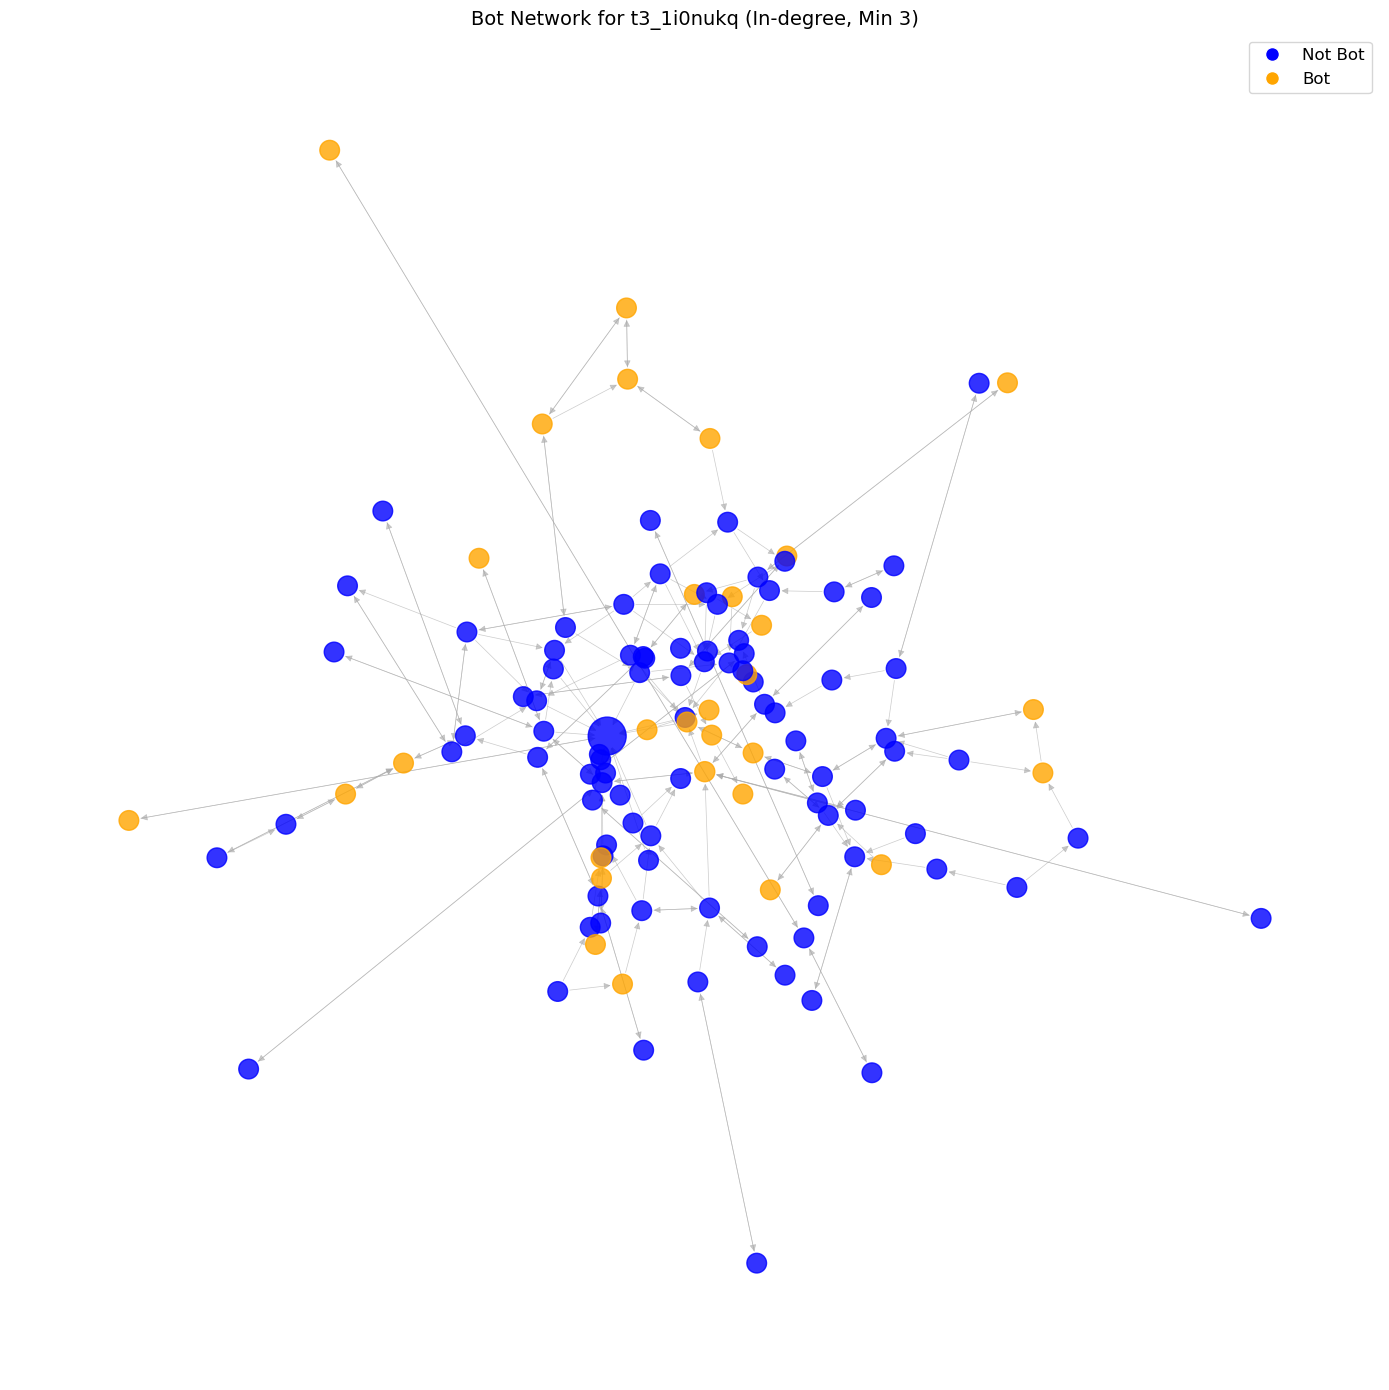

Initial Dictionary:
{'t2_1h42onjnug': 0.0, 't2_dr7y0h07': 0.0, 't2_4ldtogws': 0.0, 't2_9uty86gt': 0.0, 't2_8670sjn7k': 0.0, 't2_ykxsgeko1': 0.0, 't2_vdflmzxvk': 0.007352941176470588, 't2_3cvd5cm3': 0.011029411764705881, 't2_zz7py6crl': 0.0, 't2_kjr85zcqy': 0.011029411764705881, 't2_xthom': 0.029411764705882353, 't2_wj2tpwrhc': 0.0, 't2_i6ye1drf': 0.007352941176470588, 't2_54x3au7f': 0.0, 't2_qmtmjq8y': 0.0, 't2_elqjxo7cg': 0.0, 't2_ls2jm5s0': 0.0, 't2_1cwoaroqv9': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_xthom  : 0.029411764705882353   human
t2_3cvd5cm3  : 0.011029411764705881   human
t2_kjr85zcqy  : 0.011029411764705881   human
t2_vdflmzxvk  : 0.007352941176470588   human
t2_i6ye1drf  : 0.007352941176470588   human
t2_1h42onjnug  : 0.0   bot
t2_dr7y0h07  : 0.0   human
t2_4ldtogws  : 0.0   human
t2_9uty86gt  : 0.0   human
t2_8670sjn7k  : 0.0   human


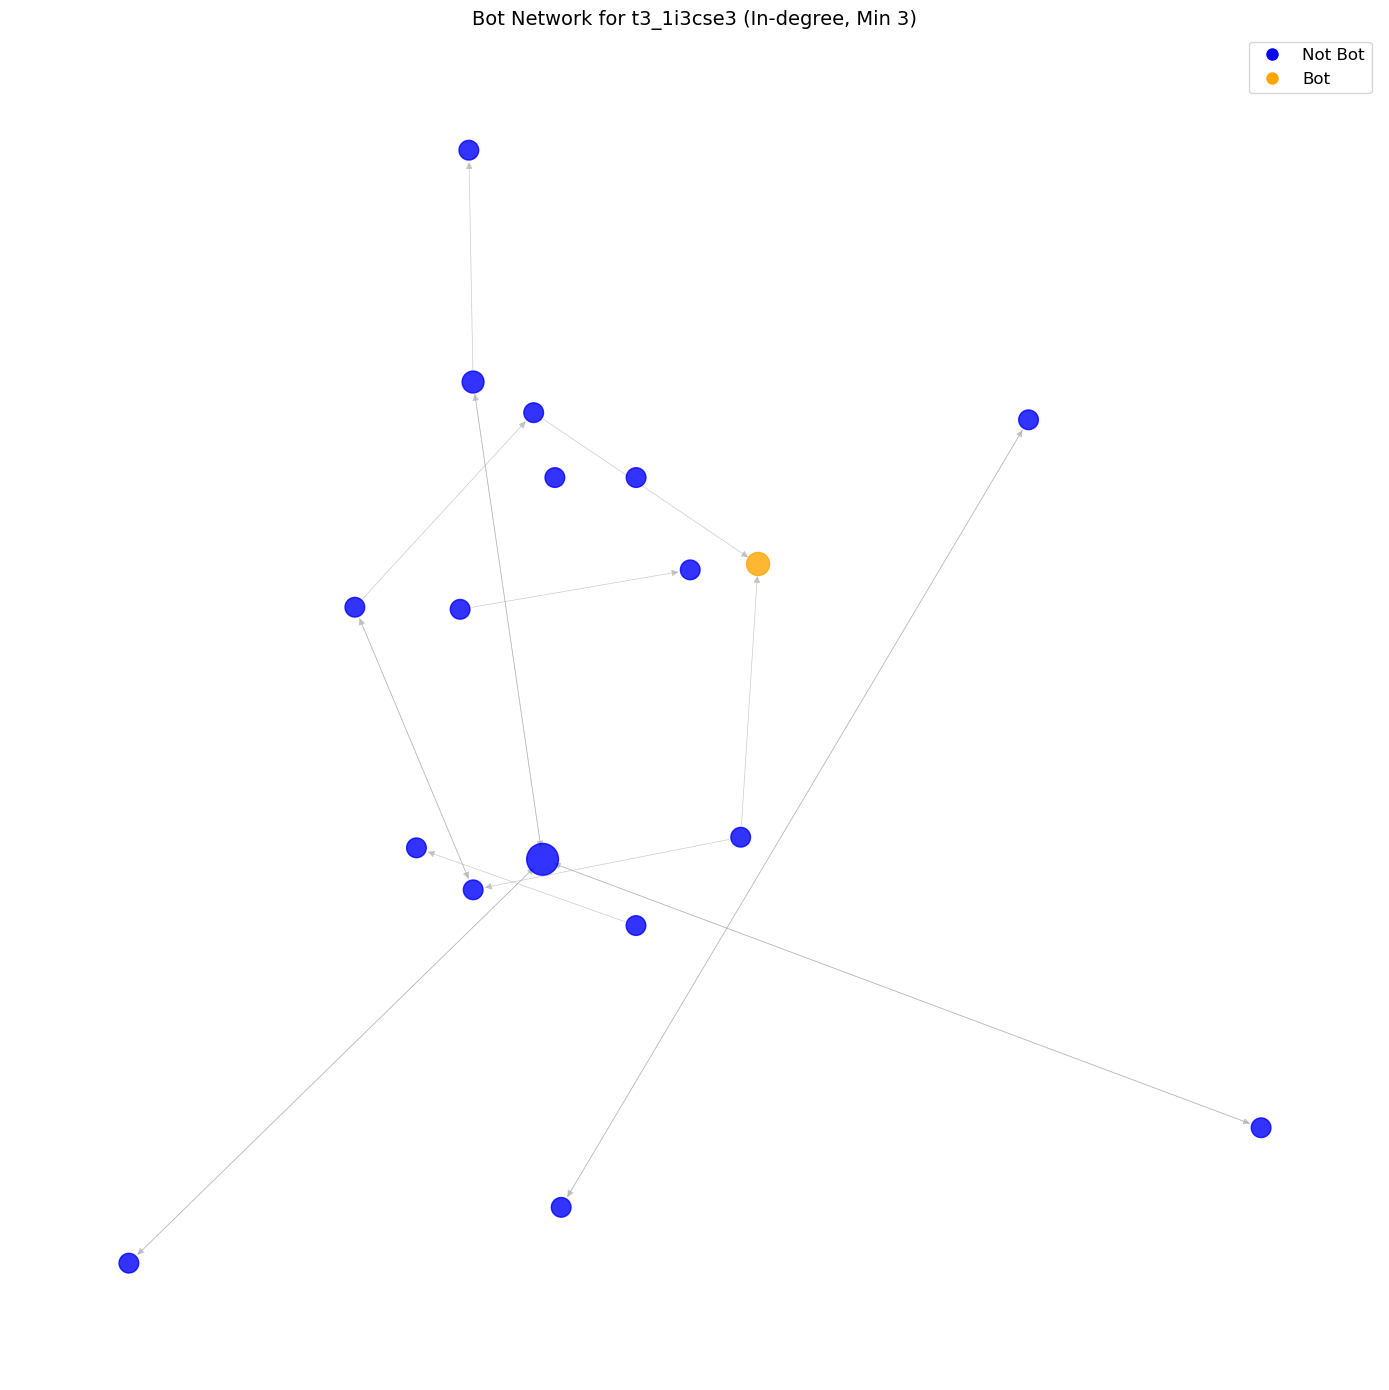

Initial Dictionary:
{'t2_h9aqbsp1': 0.0, 't2_6ulap': 0.0, 't2_1fwpskfj3y': 0.0, 't2_7emuegbu': 0.0, 't2_obz7t6y7': 0.0, 't2_vlayp58o': 0.013257575757575758, 't2_5s58msd': 0.0, 't2_5rnlo': 0.0, 't2_n3q0vl0s': 0.0, 't2_1f2goz6': 0.0, 't2_a93pu': 0.001893939393939394, 't2_oahgo7ga': 0.01893939393939394, 't2_9ow0iuoh': 0.0, 't2_2qghqjiy': 0.0, 't2_kqts1h4l': 0.0, 't2_dn20dl20': 0.0, 't2_14nsg93yu8': 0.001893939393939394, 't2_gz1ngbm3': 0.0, 't2_tj33gfvh': 0.01231060606060606, 't2_lcr8as6': 0.000946969696969697, 't2_v8n37ug': 0.0, 't2_2z43dwgj': 0.01231060606060606, 't2_8l5oztgr': 0.0, 't2_2md6etu3': 0.001893939393939394, 't2_7zrf4uln': 0.0, 't2_j9m0g71m': 0.007575757575757576, 't2_qkfuh': 0.036931818181818184, 't2_9elrjr80a': 0.0, 't2_ae0yxhyg': 0.001893939393939394, 't2_2wlwjxrr': 0.0, 't2_4adljrxl': 0.02840909090909091, 't2_5qxkikko': 0.0, 't2_claifzxs': 0.0, 't2_52gktofq': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_qkfuh  : 0.036931818181818184   bot
t2_4adljrxl  : 0.0284

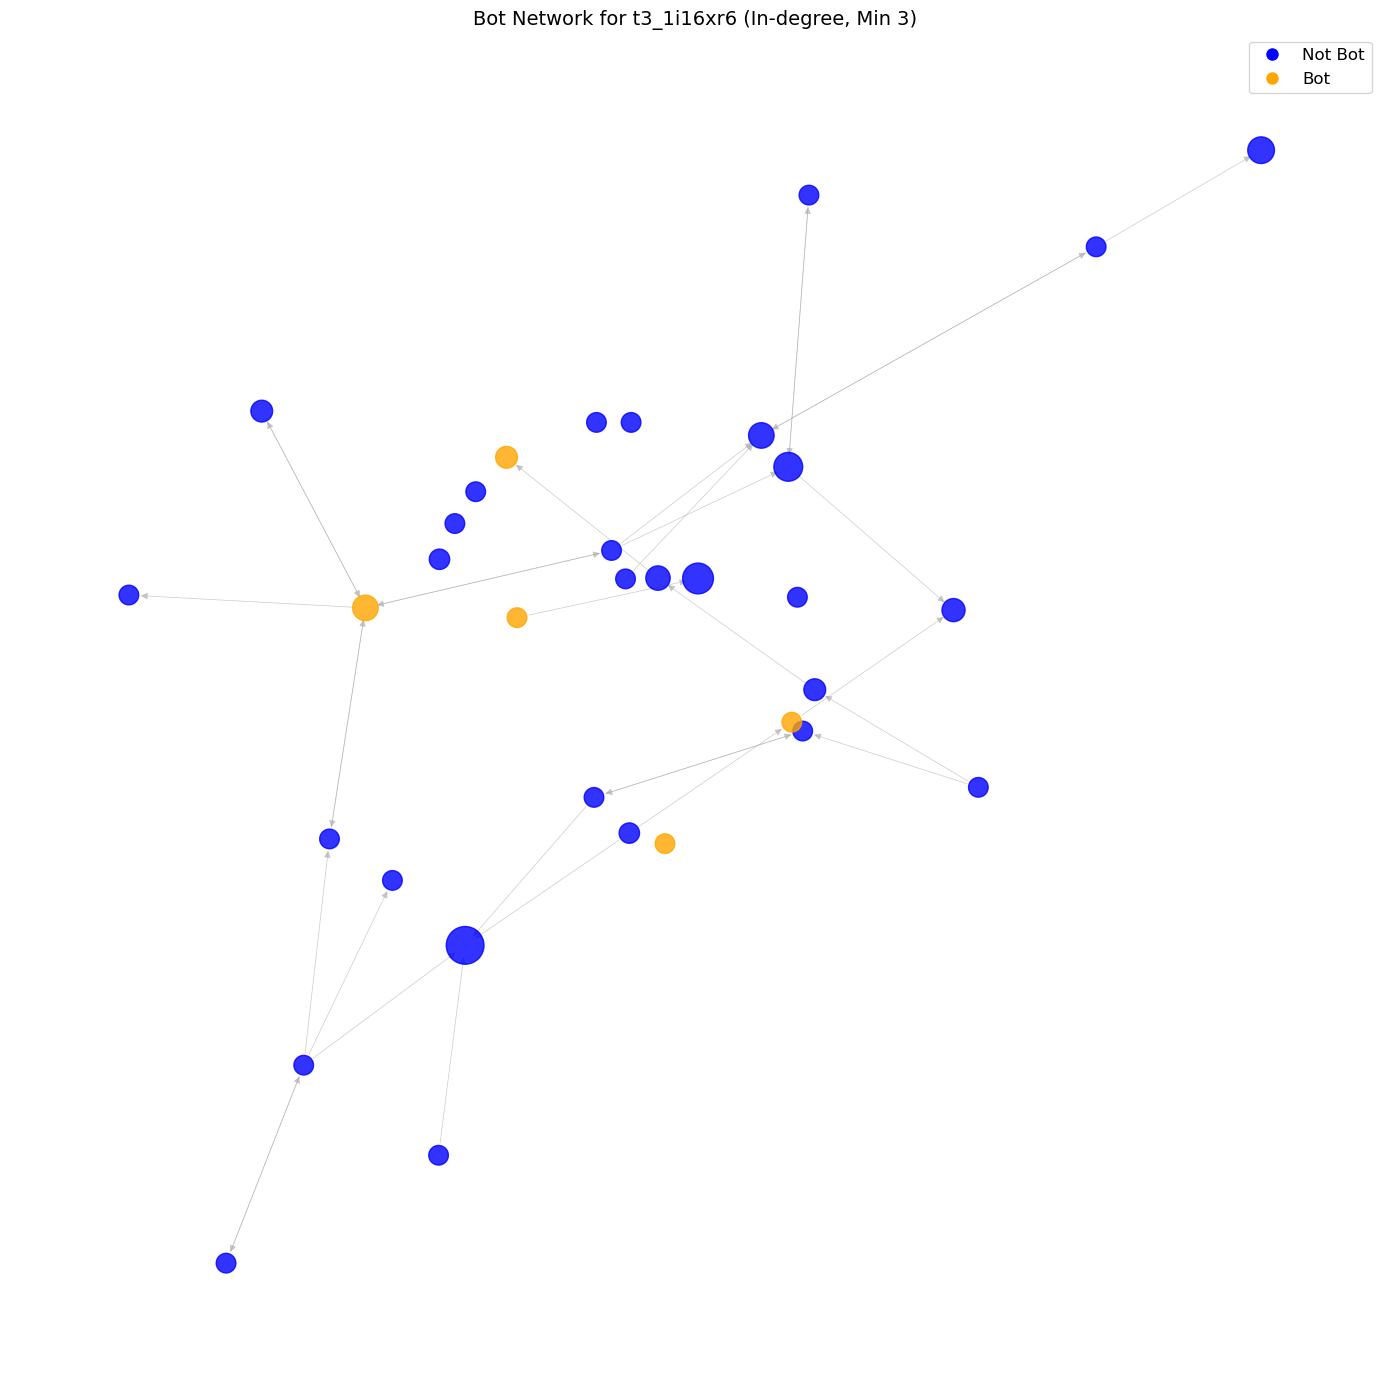

Initial Dictionary:
{'t2_wkhi0': 0.0, 't2_50qwilia': 0.0, 't2_g1wkr9ko': 0.026623376623376622, 't2_8srss1tc': 0.0, 't2_7ux5p': 0.0, 't2_68mk8': 0.0, 't2_rtcbcez3': 0.0, 't2_qpcs3vvhd': 0.000974025974025974, 't2_tp9fy': 0.03116883116883117, 't2_lfhd09gr': 0.0, 't2_rfpnw99': 0.005194805194805195, 't2_alv7u7l0t': 0.0, 't2_giu07df5': 0.04448051948051948, 't2_uooembys': 0.0, 't2_fefk65ma': 0.0, 't2_v0yfjlo0': 0.01818181818181818, 't2_wb682': 0.0, 't2_qg9ep': 0.0, 't2_78tsy': 0.0, 't2_15tmeo': 0.04318181818181818, 't2_b0kgn': 0.023376623376623377, 't2_rmqj0u6p': 0.0025974025974025974, 't2_gn5lu599d': 0.011363636363636364, 't2_8cgvst07': 0.0, 't2_5sj9fl8h': 0.0003246753246753247, 't2_139kwlu0qz': 0.01525974025974026, 't2_9ljhf8jkx': 0.023701298701298702, 't2_6cvu7': 0.0, 't2_1ahncy8klp': 0.01726190476190476, 't2_1b22e2n6sq': 0.006547619047619047, 't2_7xrls': 0.011363636363636364, 't2_q7t673nh': 0.026298701298701297, 't2_3td0i6fn': 0.006818181818181818, 't2_1eldusvom3': 0.0, 't2_qk7cf14q': 0.0

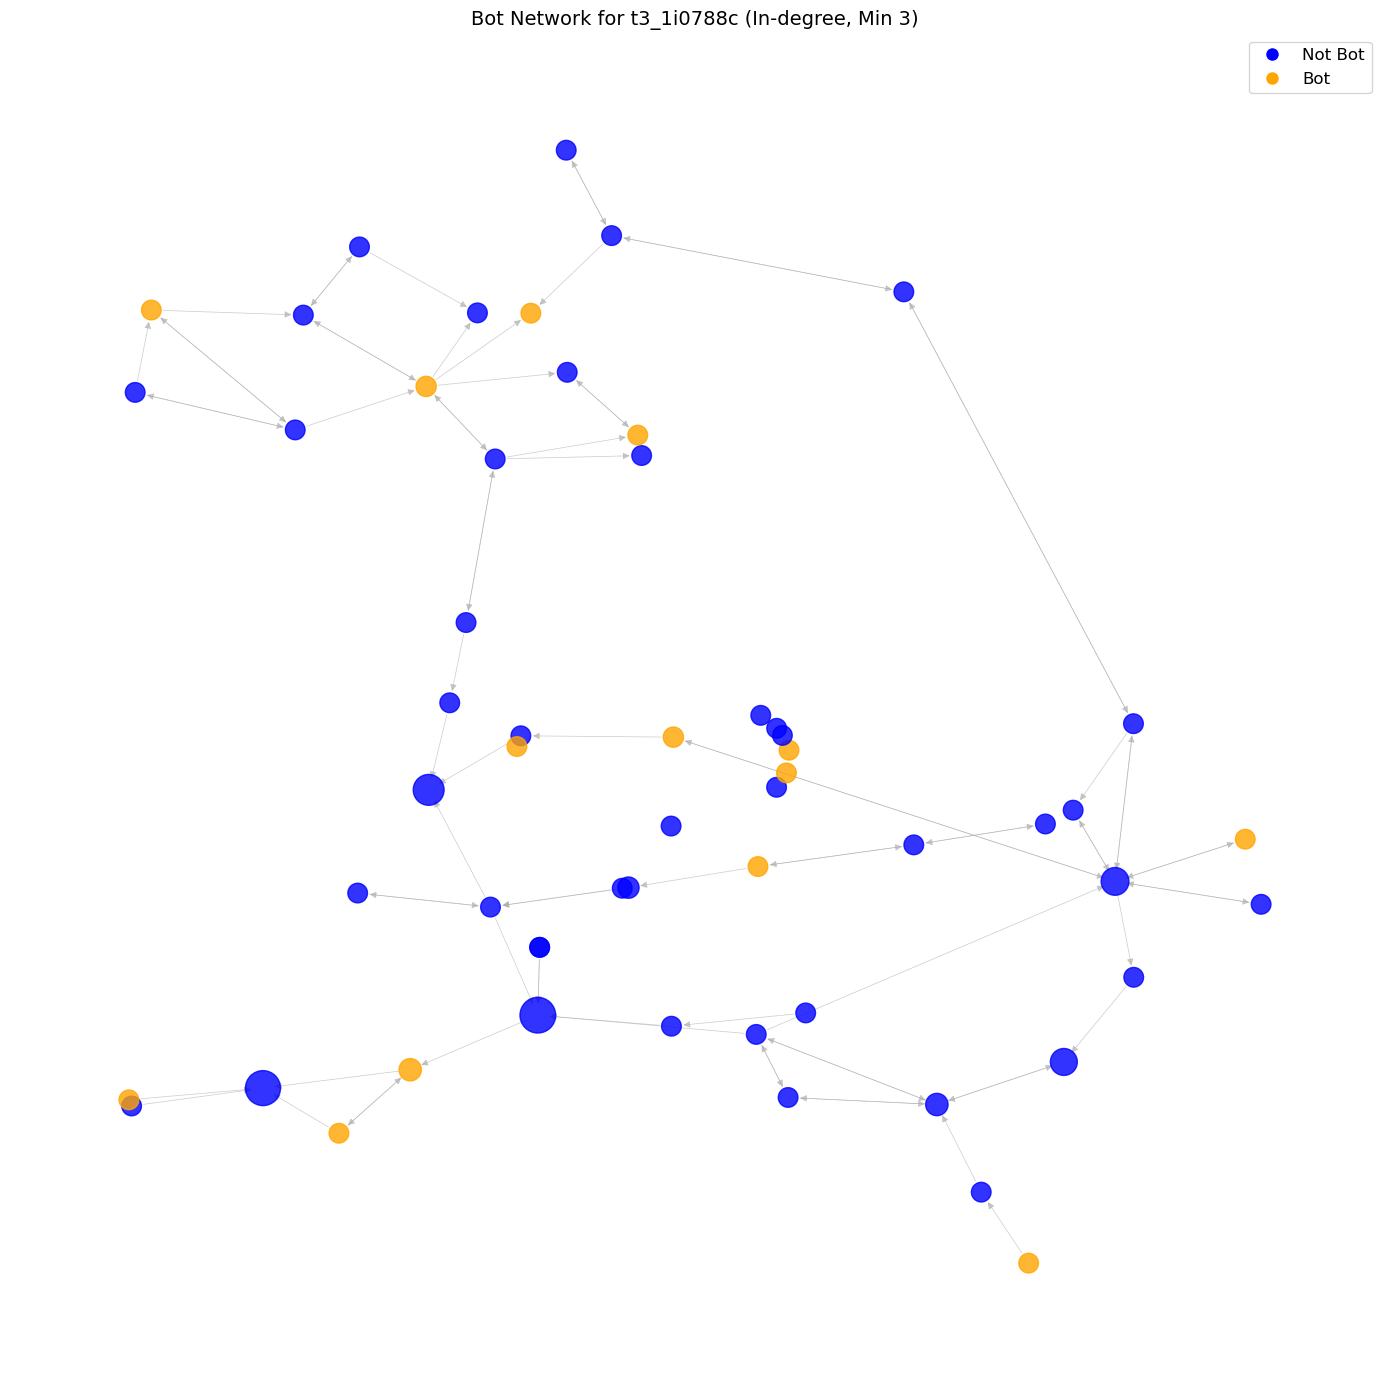

Initial Dictionary:
{'t2_mm7m0ccve': 0.0, 't2_oxub5tnr': 0.0, 't2_1kbebmiu': 0.0, 't2_9ourbvb': 0.0, 't2_u67rd0zep': 0.0, 't2_29iwtb62': 0.0, 't2_1cdvprap1d': 0.0, 't2_v9d2cnx4': 0.0, 't2_nhku54oy5': 0.0021077988557663355, 't2_4140kyai': 0.023110508882866608, 't2_zyey9': 0.0, 't2_671ljczt': 0.0, 't2_smf1qihpc': 0.0, 't2_3iob4q00': 0.0, 't2_1hhsklhfbg': 0.0, 't2_brfo7sxm9': 0.0, 't2_et93i6rsc': 0.0, 't2_hpb0ovqr': 0.0, 't2_6pn4daxt': 0.0, 't2_gnutvhfm2': 0.0, 't2_5nuhx3x3': 0.00015055706112616682, 't2_q82wibl1': 0.0, 't2_5xml05w0': 0.0, 't2_vr3pgnhx': 0.0, 't2_2frt7jv9': 0.0, 't2_4uvx1': 0.00015055706112616682, 't2_84vc0uib': 0.00015055706112616682, 't2_3mf2mdgo': 0.00030111412225233364, 't2_7gztzgdq': 0.0, 't2_d28i12dy8': 0.0, 't2_hihf392kq': 0.0, 't2_1hl98tzaiu': 0.001656127672387835, 't2_d64sw952': 0.0, 't2_4doo7aux': 0.0, 't2_hfvm9wsf': 0.0, 't2_h1zdnt741': 0.001806684733514002, 't2_85yx80jj': 0.00030111412225233364, 't2_1hzvzxepdw': 0.037789822342667874, 't2_3xgc7p6b': 0.0, 't2_by3

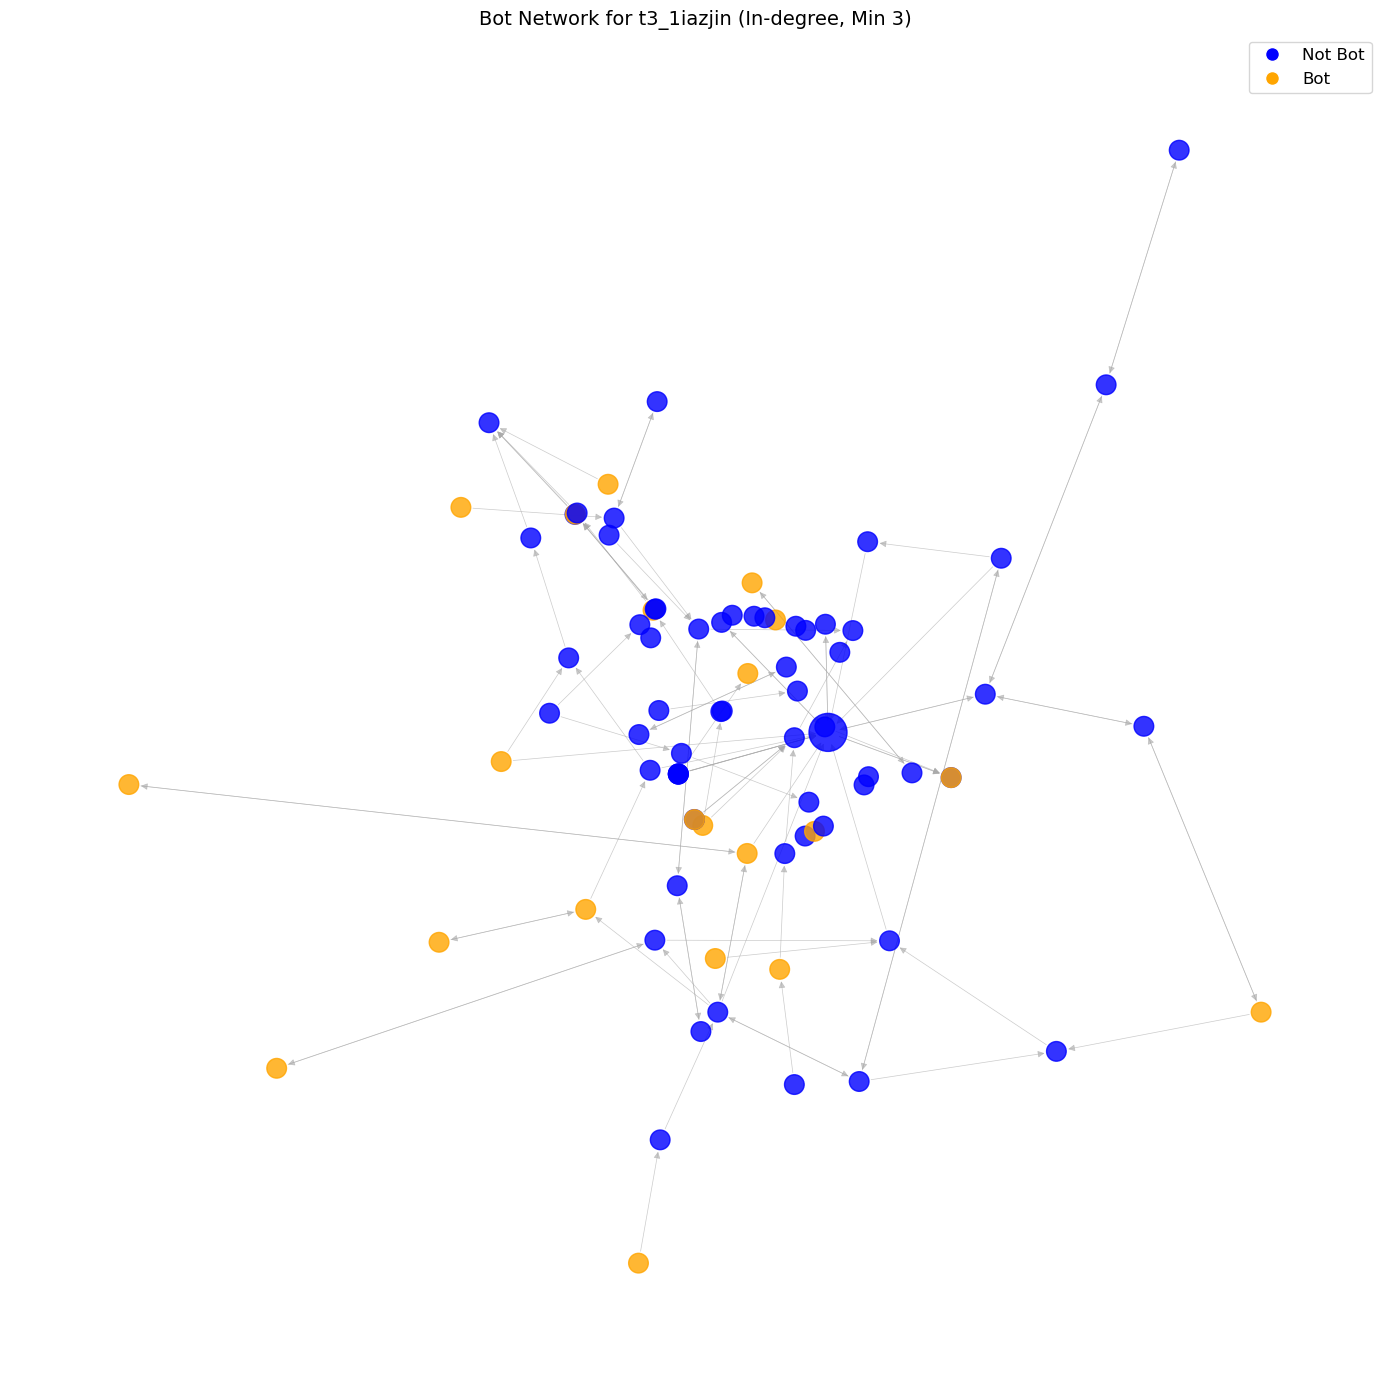

In [36]:
for post in posts:
    G, plot = plot_network_degree(post, post_node_edge_dict, thr_70, min_degree = 3, degree_type= "in")
    top_betweenness(G)
    plot.show()

### Using Total Degree

Initial Dictionary:
{'t2_12i5fn4j0r': 0.0, 't2_vubljqn9': 0.0, 't2_adxr5': 0.01832945134575569, 't2_ojs8w74': 0.0, 't2_na5dsk0f': 0.0, 't2_4dfhg': 0.004431935817805383, 't2_keblrri9t': 0.021713250517598343, 't2_67wqo': 0.002562111801242236, 't2_4wbuk': 0.0, 't2_xkmak': 0.0, 't2_u3kqaqz1': 0.0, 't2_7p3pi': 0.0, 't2_3m0ag9v5': 0.0, 't2_1e10jvxmbw': 0.0, 't2_44xc7': 0.0, 't2_9450jcss': 0.0, 't2_4zx6r': 0.0, 't2_167b1szk0w': 0.0, 't2_554eu2un': 5.822981366459627e-05, 't2_1fdpzy7i': 0.0, 't2_60ak8shl': 0.0, 't2_bmpme': 0.0, 't2_6bcb2': 0.0020833333333333337, 't2_4clzu': 0.0, 't2_7auzcfic': 0.0, 't2_bwa6vw5i': 0.0, 't2_cfqh5aii': 0.0, 't2_7x56c9im': 7.763975155279503e-05, 't2_c8qzk': 0.0001940993788819876, 't2_2b9lkg6o': 0.0, 't2_18t9pc780c': 0.0, 't2_lz4ripwsr': 0.0, 't2_aoaof092': 0.0, 't2_mu8yiaeu': 0.0, 't2_4bvy7ob6': 0.006890527950310559, 't2_e7xob': 0.0, 't2_9aqyl': 0.0, 't2_6cd3c': 0.0, 't2_3ffrpq4j': 0.0, 't2_5v94u': 0.00015527950310559007, 't2_ql7hqb7c': 0.0014751552795031057, 't2_a

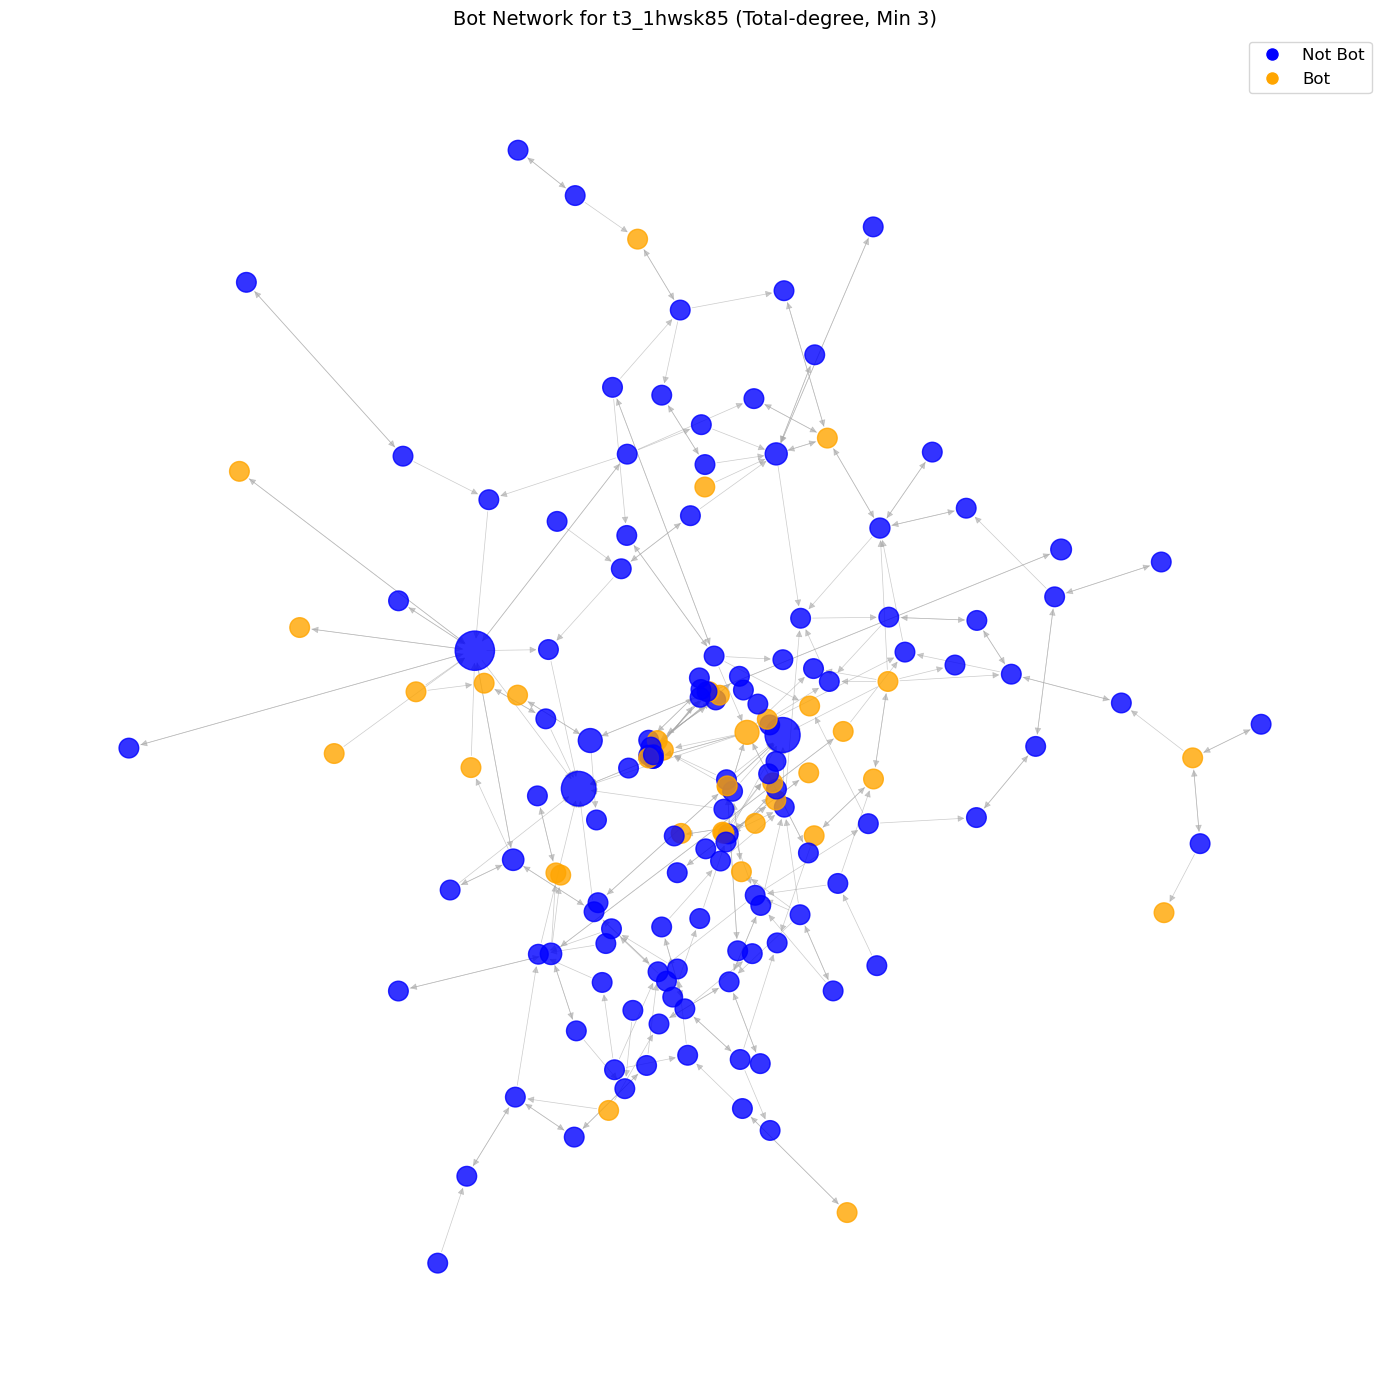

Initial Dictionary:
{'t2_13ukpn': 0.0, 't2_im1ux': 0.0, 't2_121wgh': 0.0, 't2_1ucdyz24': 0.007403971689685976, 't2_gurm88im9': 0.0, 't2_68petbf': 0.0009276437847866418, 't2_by2pkeg5': 0.018518518518518517, 't2_3m3eahlf': 0.0, 't2_4t6f7tlv': 0.0, 't2_mk4ltkhj': 0.0, 't2_txctg': 0.0, 't2_5bquyiq5': 0.0, 't2_16wk09zwh7': 0.0, 't2_76bjyurw': 0.0, 't2_158fcprtpm': 0.0, 't2_cf2dslix': 0.0, 't2_16ghse': 0.0, 't2_17alfddkwx': 0.0, 't2_8l0g7jqf': 0.01535765821480107, 't2_k51bnotc': 0.04323850752422181, 't2_kvi5dqy4v': 0.0, 't2_navwx': 0.00910465196179482, 't2_5orwrgxy': 0.001494537208822923, 't2_ctj1o': 0.002576788291074005, 't2_3n7890fz': 0.0, 't2_q3kxp': 0.0021645021645021645, 't2_11ky1yeyhs': 0.0, 't2_39zsy1nh': 0.010925582354153782, 't2_12kwn5r226': 0.024273345701917127, 't2_54win': 0.0, 't2_kkfdksyz': 0.0, 't2_1as7lwoaq2': 0.0, 't2_ypo0enu': 0.00010307153164296021, 't2_rjhap3jtt': 0.0, 't2_shau5s28': 0.024891774891774892, 't2_efq79jx9s': 0.00025767882910740053, 't2_e4dih': 0.0, 't2_cdgngjr

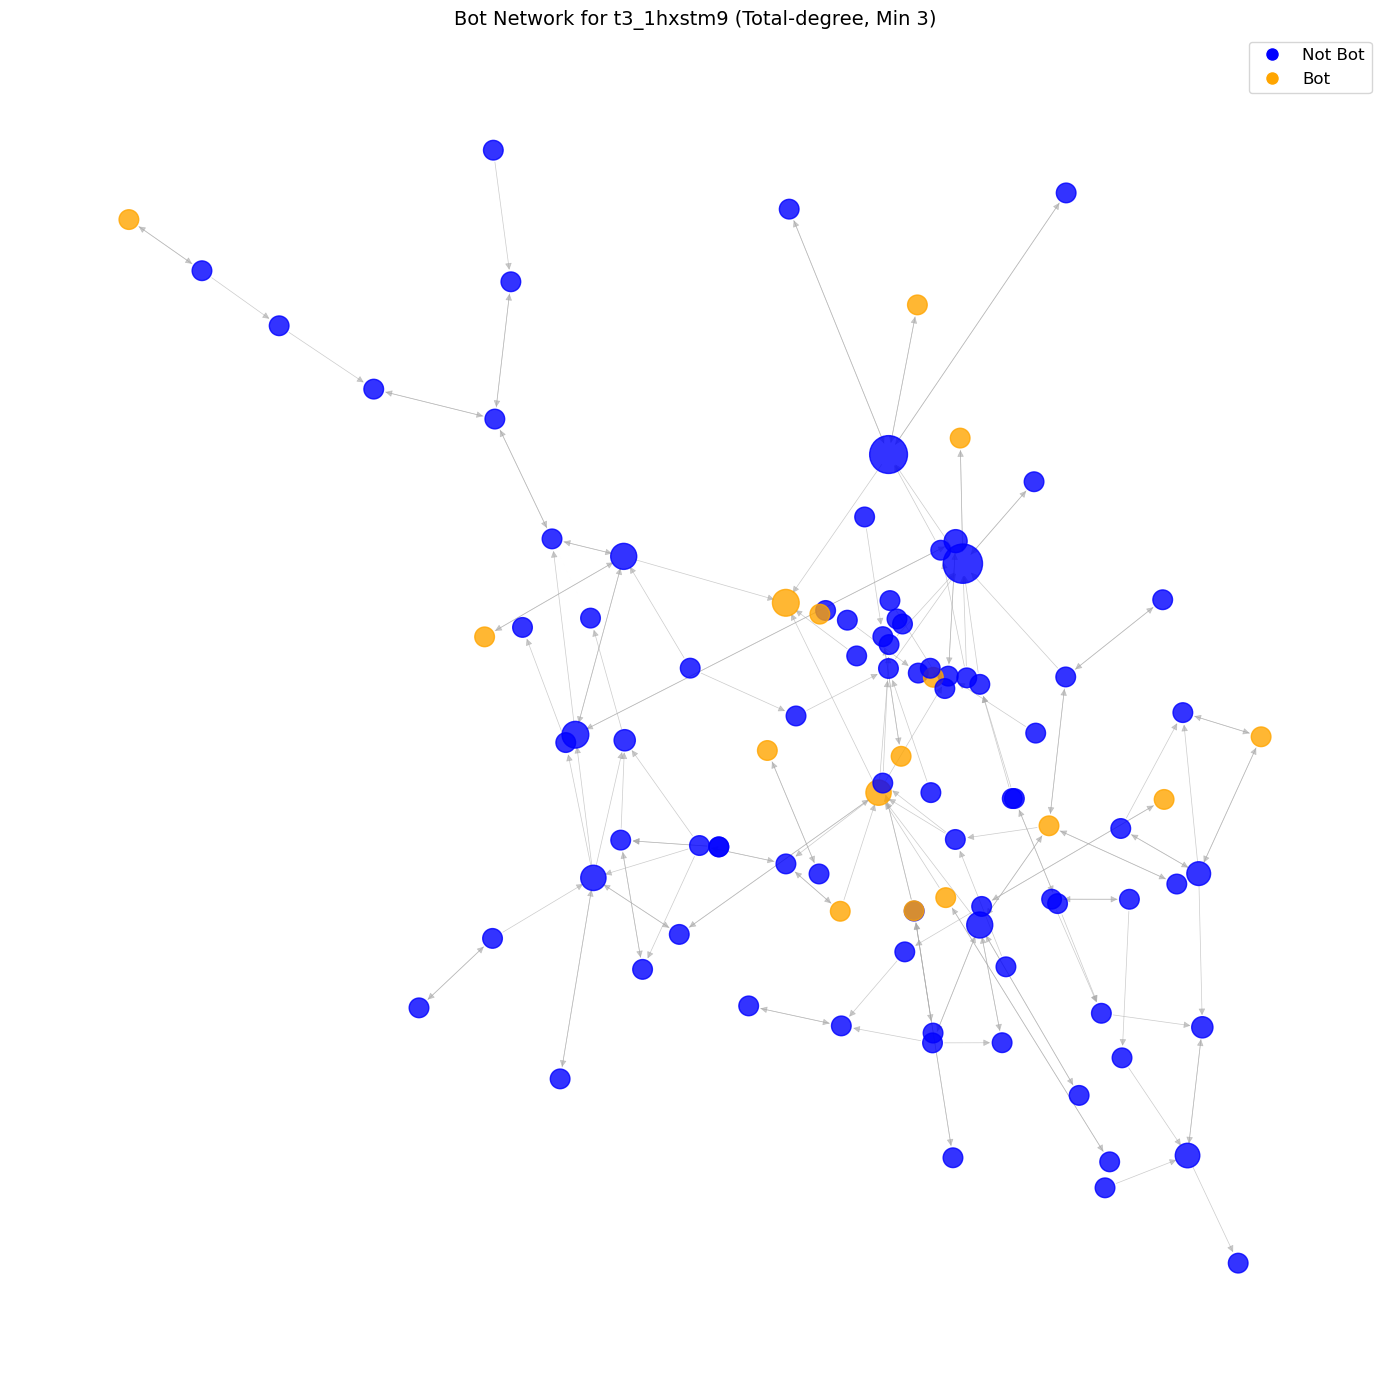

Initial Dictionary:
{'t2_lst66ur1': 0.0, 't2_17f9e0pzj5': 0.0, 't2_16f1is': 0.0, 't2_160u2g': 0.0, 't2_32gkguod': 0.07539118065433856, 't2_893lfmel': 0.0, 't2_5h7n767h': 0.0, 't2_tkfvnsmlc': 0.0, 't2_vxzt02yo': 0.0, 't2_oxvof62q': 0.0, 't2_ckx6uty6o': 0.0, 't2_15lwqo': 0.0, 't2_32nncwf3': 0.0, 't2_pnxbp': 0.0, 't2_23vu8zqi': 0.0, 't2_11g53qyg5d': 0.0, 't2_2o0twc1y': 0.0, 't2_e4hx2eo1': 0.0, 't2_13f7blo': 0.0, 't2_5u9ojax3': 0.0, 't2_1cvz2xniyy': 0.0, 't2_8w1xbb9w': 0.0, 't2_po1bhazf': 0.0, 't2_fldaoaui': 0.0, 't2_14vkd1': 0.0, 't2_10llalem2y': 0.0, 't2_kh4a1': 0.0, 't2_89nj2zyv': 0.0, 't2_vcqav1k5': 0.0, 't2_49r1wxydc': 0.0, 't2_985ae448': 0.0, 't2_tsw917m0x': 0.0, 't2_1banhkxbgq': 0.0, 't2_ts3xkfio1': 0.0, 't2_1epclhfffo': 0.8890469416785207, 't2_1dyh3sfq6v': 0.0, 't2_5cbea': 0.0, 't2_zvke2iudo': 0.0, 't2_6f54jnmo': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_1epclhfffo  : 0.8890469416785207   human
t2_32gkguod  : 0.07539118065433856   human
t2_lst66ur1  : 0.0   human
t2

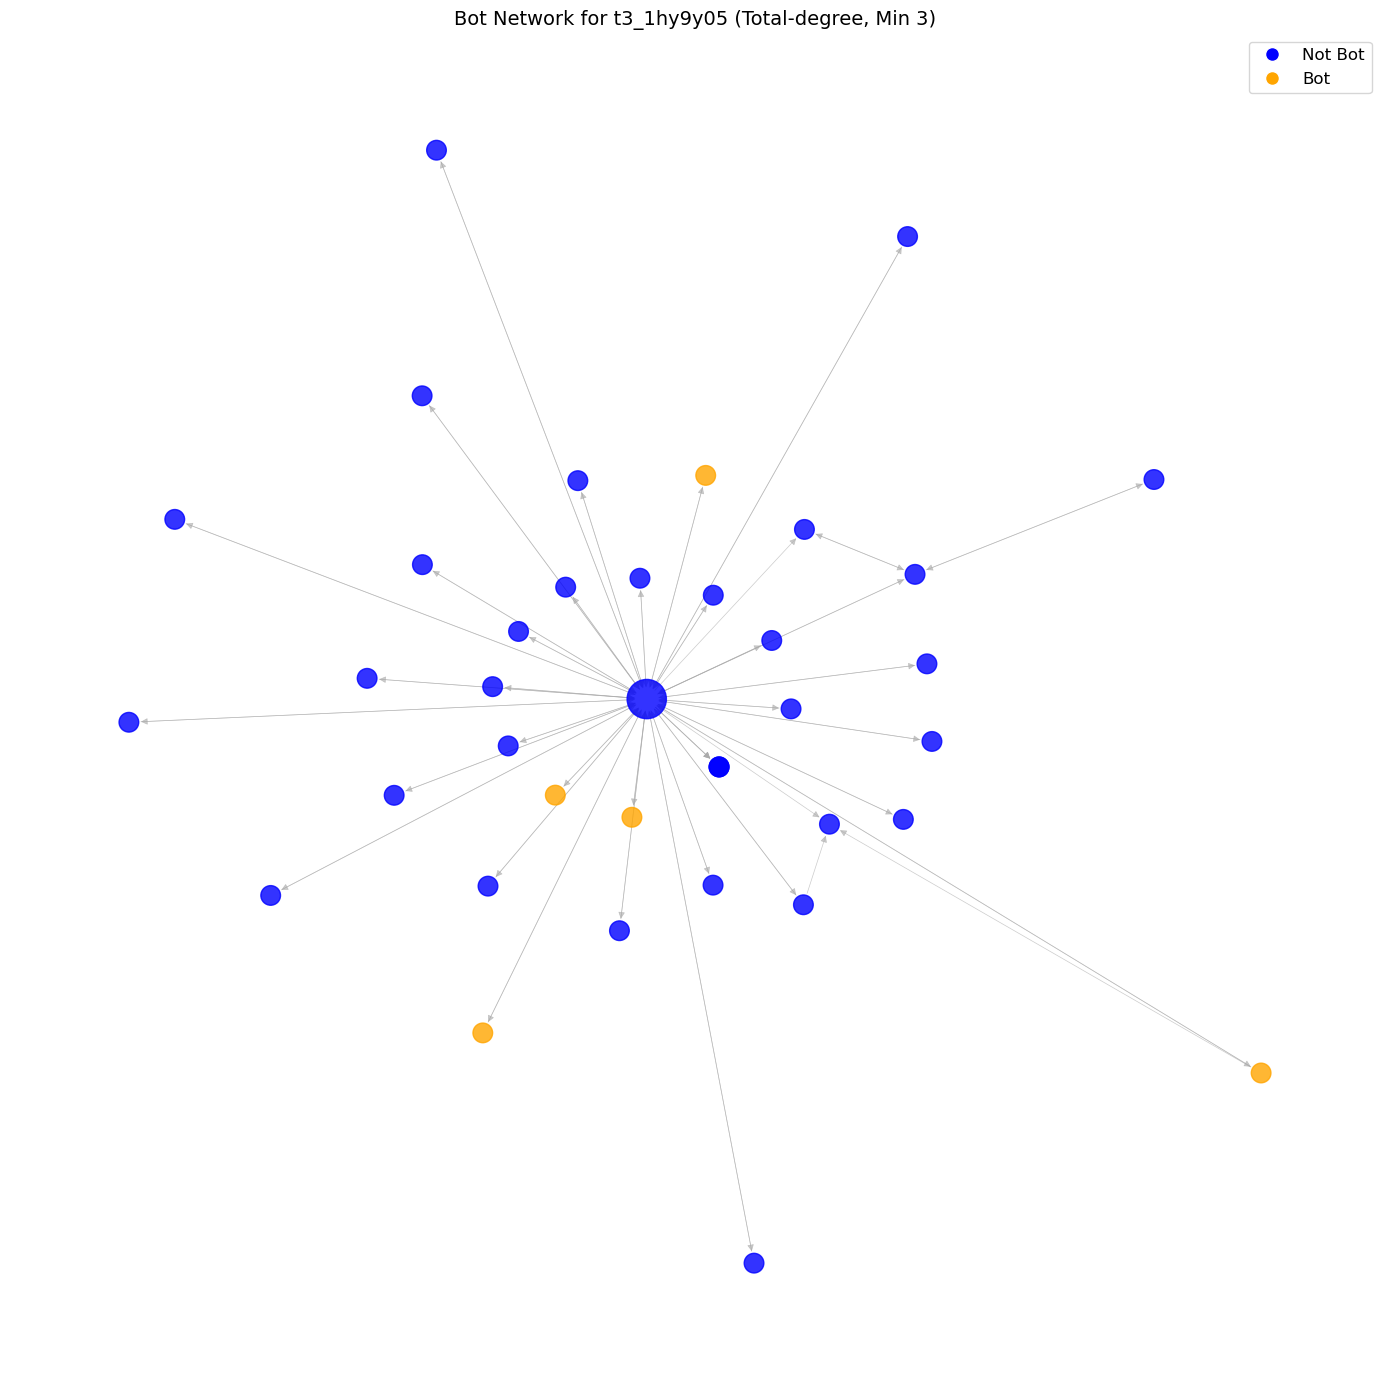

Initial Dictionary:
{'t2_ecc7w': 0.07649696048632215, 't2_1l0vba': 0.0, 't2_12qxit': 0.0, 't2_3v43v': 0.0, 't2_9q1uyk0x': 0.13129601485984466, 't2_avixr': 0.0, 't2_650y4': 0.0, 't2_767ka': 0.01658476865923674, 't2_fhm4r4mx': 0.0, 't2_d54dq': 0.0, 't2_rekwy': 0.005167173252279635, 't2_em8gh': 0.0, 't2_alr25': 0.0, 't2_bob60jxc': 0.0, 't2_uiuvv': 0.0, 't2_hn17g': 0.025268490374873352, 't2_l4k8xo8q': 0.0, 't2_y7fx6': 0.0008654170888213442, 't2_p7mnzeamj': 0.0, 't2_k9kk5': 0.026450523471800064, 't2_qfdyi': 0.000303951367781155, 't2_e8xa8nuu': 0.0, 't2_cpe7p': 0.0, 't2_gn65nija': 0.0, 't2_15hs5t': 0.0, 't2_3718c': 0.024164133738601823, 't2_114bhb': 0.0, 't2_4znad': 0.0, 't2_17574wy7up': 0.0, 't2_qg7iec8r': 0.0, 't2_gve93q7i': 0.0, 't2_4r7pz': 0.15049138804457948, 't2_a8hy2szz': 0.021048632218844985, 't2_g0rtv': 0.02589243498817967, 't2_trqpd': 0.058508949679162446, 't2_snaps': 0.01386693684566025, 't2_ojxfx': 0.057479736575481256, 't2_elee5': 0.17383400878081737, 't2_sk4kqgj3': 0.0395719351

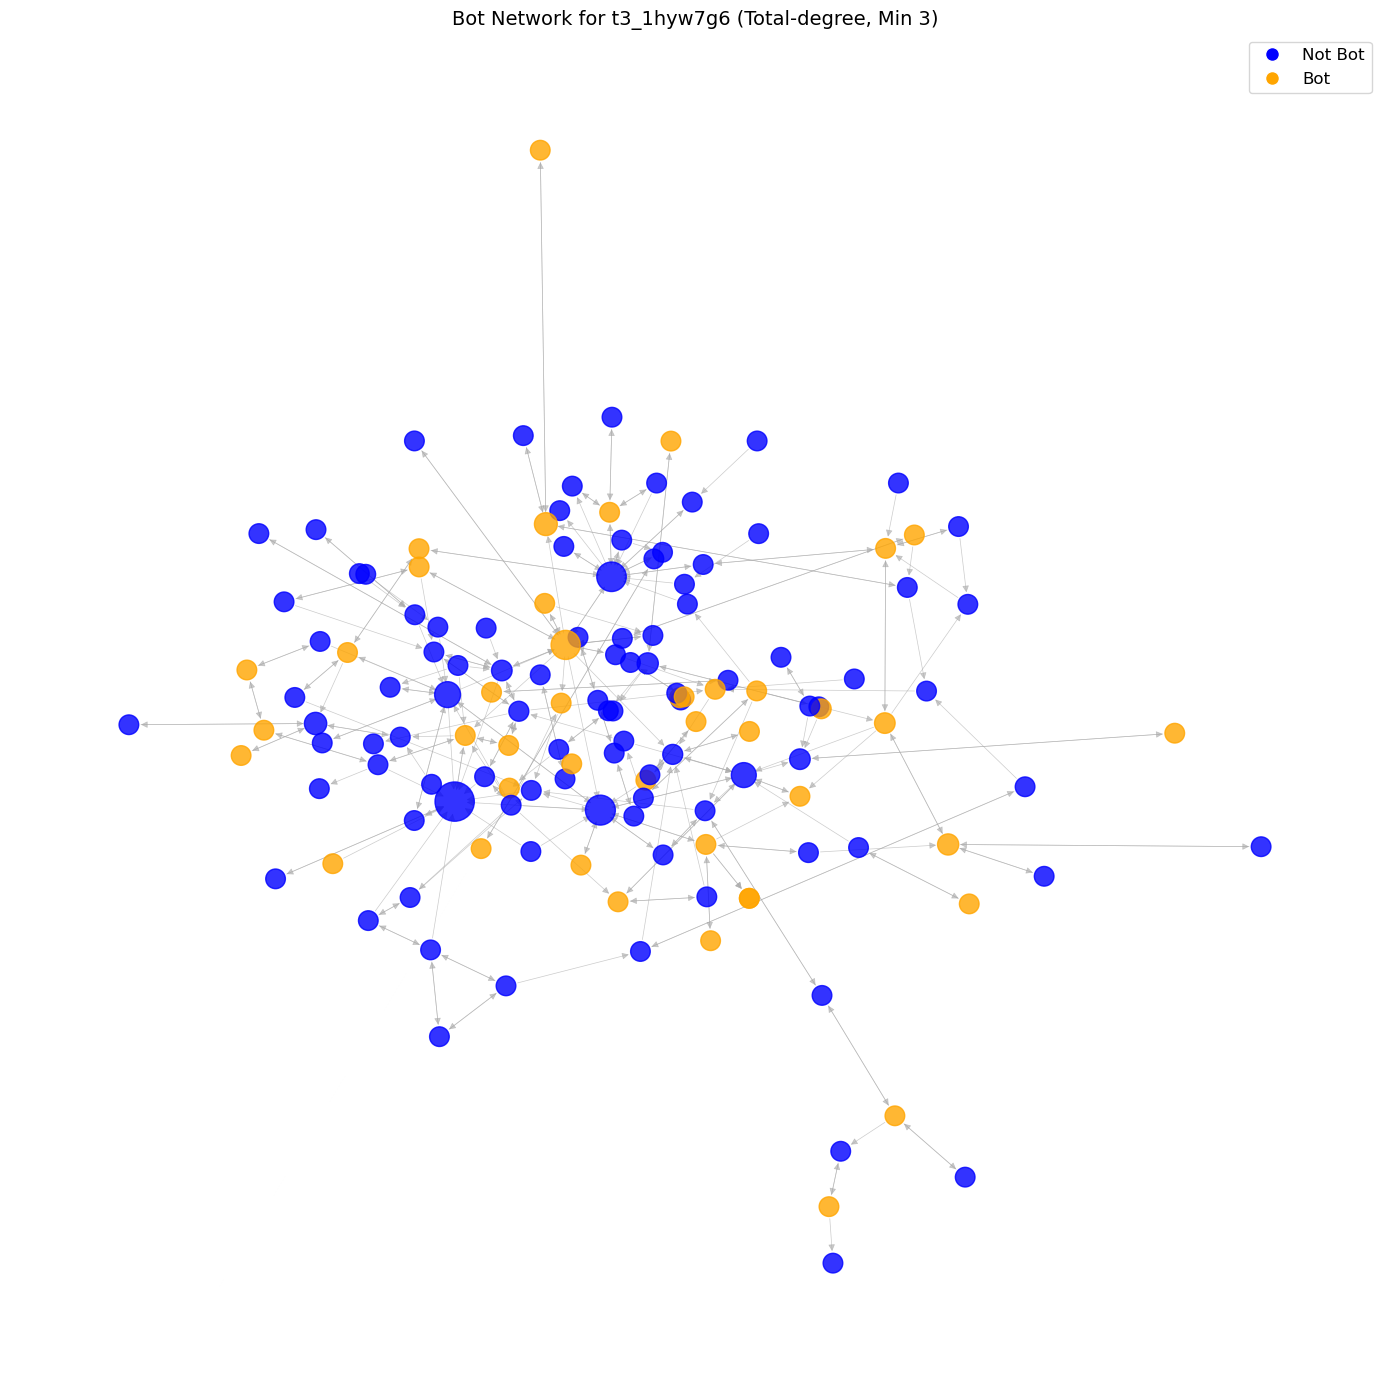

Initial Dictionary:
{'t2_plvww': 0.0, 't2_6ukxd': 0.0, 't2_k0sbp8pz': 0.0, 't2_7wmiopsf4': 0.0018115942028985507, 't2_f8v6n0zj': 0.0018115942028985507, 't2_15s5hcu81d': 0.0, 't2_afxzr': 0.0, 't2_4yfgdsif': 0.0, 't2_cr1jnuzwh': 0.0, 't2_m2a6mv0p': 0.0, 't2_vwz95wiss': 0.0, 't2_4m8s2t37': 0.0, 't2_70lq9': 0.0, 't2_vkqcq6c2': 0.0, 't2_b0gpp': 0.0, 't2_st01pgrii': 0.0, 't2_1bq06wodv4': 0.0, 't2_1hmea6vy': 0.007246376811594203, 't2_1cl9ixrfi9': 0.0, 't2_bdd6l': 0.0, 't2_drjxotfm4': 0.007246376811594203, 't2_ego4s': 0.0, 't2_lf58eu5l': 0.007246376811594203, 't2_jzlikmmoa': 0.0, 't2_e8igtvtx': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_1hmea6vy  : 0.007246376811594203   human
t2_drjxotfm4  : 0.007246376811594203   human
t2_lf58eu5l  : 0.007246376811594203   human
t2_7wmiopsf4  : 0.0018115942028985507   human
t2_f8v6n0zj  : 0.0018115942028985507   human
t2_plvww  : 0.0   human
t2_6ukxd  : 0.0   human
t2_k0sbp8pz  : 0.0   bot
t2_15s5hcu81d  : 0.0   human
t2_afxzr  : 0.0   human


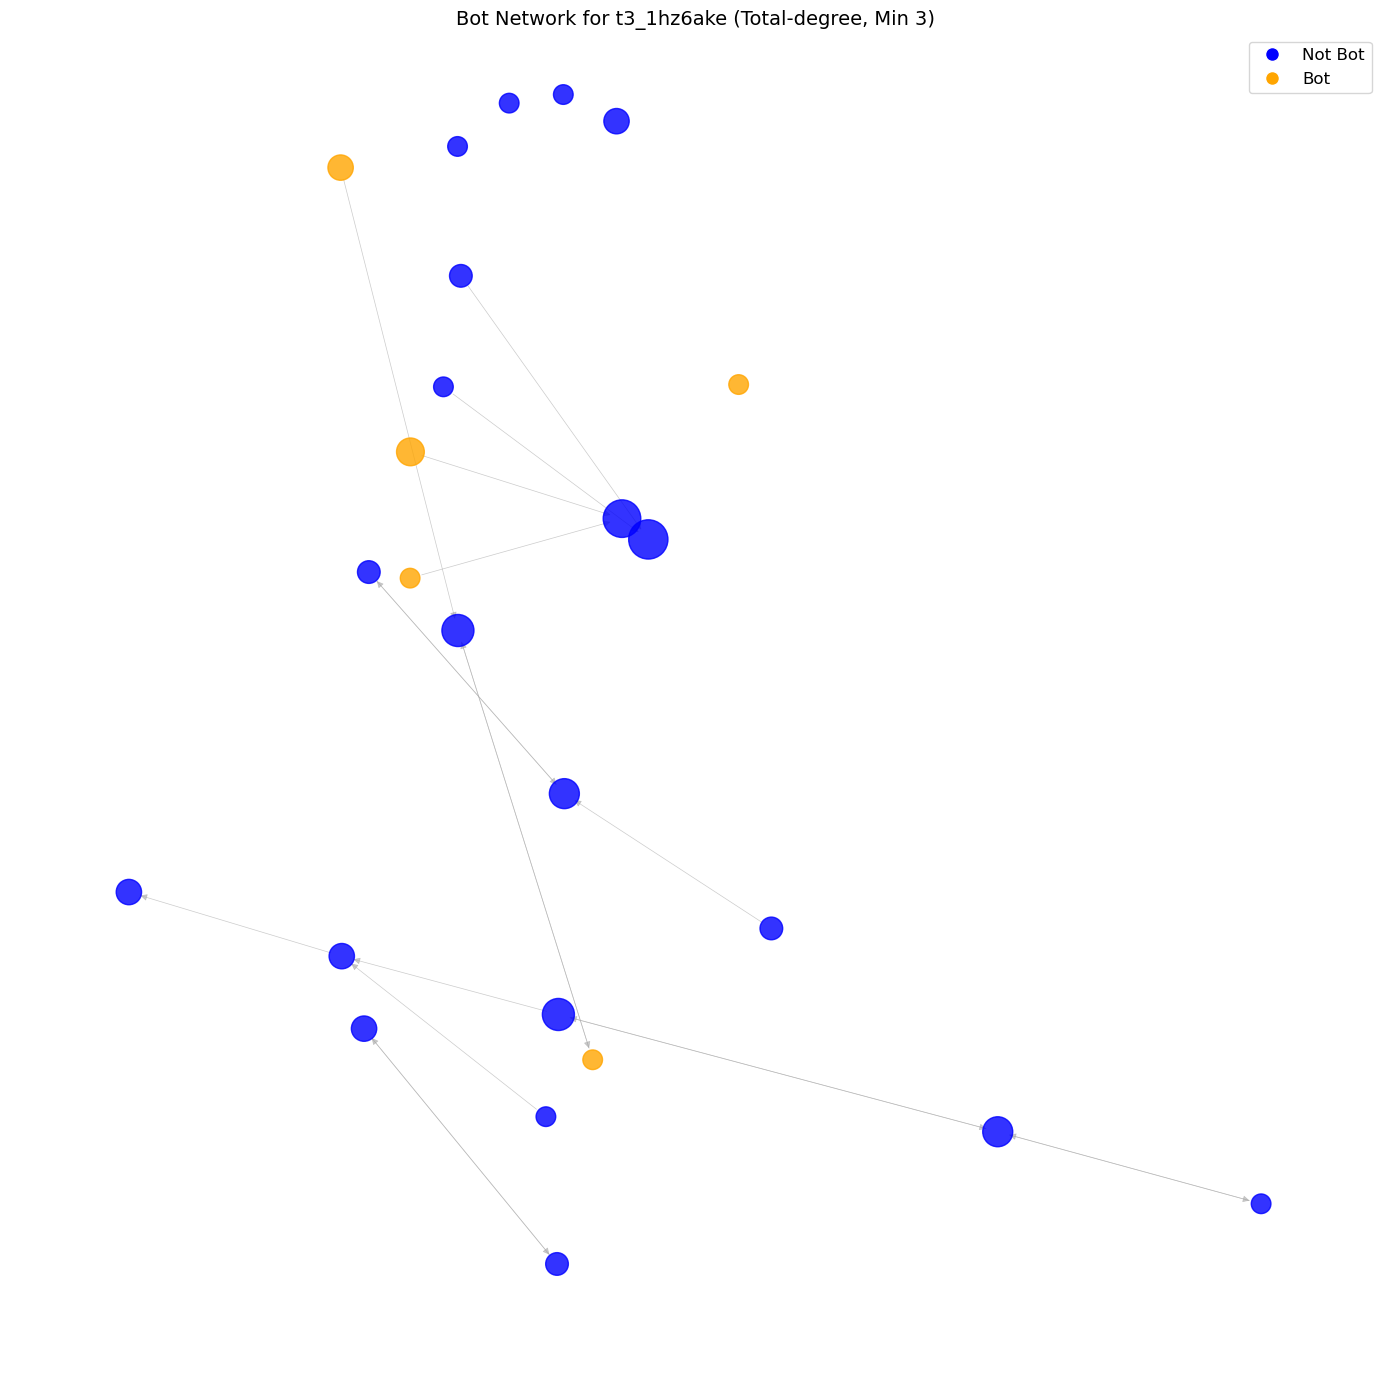

Initial Dictionary:
{'t2_2hm6l94u': 0.11333084391336817, 't2_11lqath1sd': 0.0, 't2_6jjfisov': 0.0, 't2_ywpe6': 0.0, 't2_mrac3': 0.0, 't2_fye6mmnl': 0.0, 't2_ijns0q0bv': 0.02100448095593727, 't2_dcwr0xg9': 0.0, 't2_r4zx1zd1': 0.20070948469006722, 't2_ovfjc': 0.0, 't2_4jpseeo4': 0.0, 't2_jw21j': 0.0, 't2_z99j654jx': 0.0, 't2_bx2uh56w': 0.0, 't2_40u7q': 0.01549663928304705, 't2_hyr5mz8kr': 0.007188200149365199, 't2_q6m1fcsv5': 0.0028939507094846903, 't2_ki4a6': 0.0, 't2_4om8rmo': 0.0, 't2_pff1o4ge': 0.0, 't2_5rxuf68s': 0.0, 't2_xbibc': 0.0, 't2_3h0n6uu8': 0.0, 't2_or709': 0.0, 't2_5gf92jwj': 0.0, 't2_7026dpfn': 0.0, 't2_frbnqafk': 0.0, 't2_hrki590i': 0.0, 't2_xjabn': 0.0039052775703261144, 't2_1d3nnfsf': 0.0320823998008464, 't2_n6ieyids': 0.0, 't2_elvszk': 0.0, 't2_9gv15v8v': 0.07617625093353249, 't2_b2js3nmeo': 0.0, 't2_14m542msld': 0.0, 't2_1ccl3or4mk': 0.0, 't2_16bej2xoi4': 0.0, 't2_3rva17ms': 0.002800597460791636, 't2_awk13': 0.010362210604929051, 't2_k36l1ydf': 0.022591486183719194, 

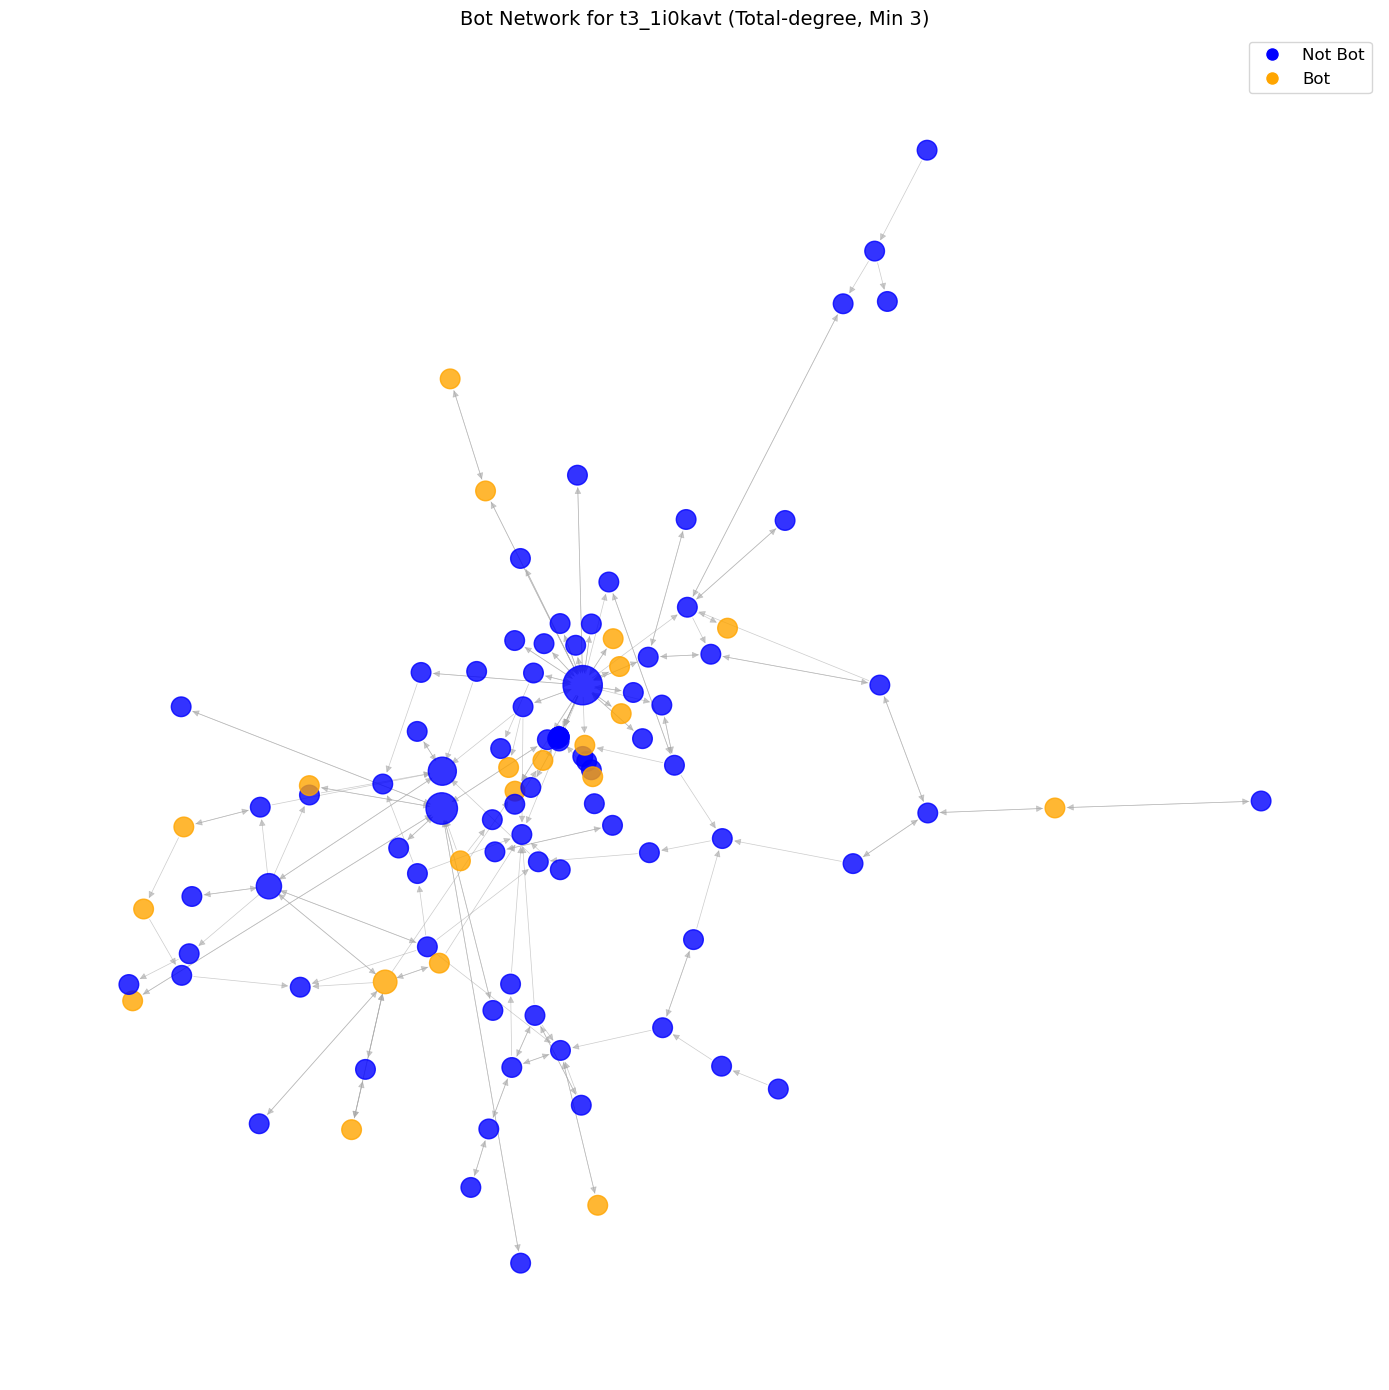

Initial Dictionary:
{'t2_9a7co': 0.0, 't2_o1jtvc6rk': 0.07117735293569606, 't2_8kmztost': 0.04044850653101534, 't2_prtspyjr': 0.010625710399314288, 't2_od2zf4y0e': 0.010243725194253452, 't2_59fn4lsf': 0.006002291911230365, 't2_371x7bqn': 0.0, 't2_e3hu1js0': 0.0045977975292078935, 't2_116bx9614x': 0.0196209961428811, 't2_4dfhg': 0.002040359997763989, 't2_fo1g3b0k': 0.0, 't2_7sd48mkay': 0.0010900553412711723, 't2_11dj8d': 0.0, 't2_2u42pgmd': 0.0, 't2_6gyep': 0.0, 't2_176do4': 0.0, 't2_n2zus1uh': 0.0, 't2_17f4c9aq74': 0.0, 't2_18pfn343z4': 0.017676132446382324, 't2_1f3nvmbc98': 0.00041925205433506624, 't2_o487gsll8': 0.0, 't2_5h7me': 0.0, 't2_95ph63qo': 0.00027950136955671084, 't2_b6m9o7sip': 0.0008664542456258036, 't2_xdexb': 0.0, 't2_1626pr': 0.00036335178042372406, 't2_vn4n524': 6.987534238917771e-05, 't2_67h9ybx6': 0.004541897255296551, 't2_tfnzr8xu5': 0.0, 't2_y3zv6rsps': 2.7950136955671083e-05, 't2_jwnz8dmt': 0.0, 't2_8rjfdrn6': 0.0, 't2_afwuz': 2.7950136955671083e-05, 't2_fo9mq1t':

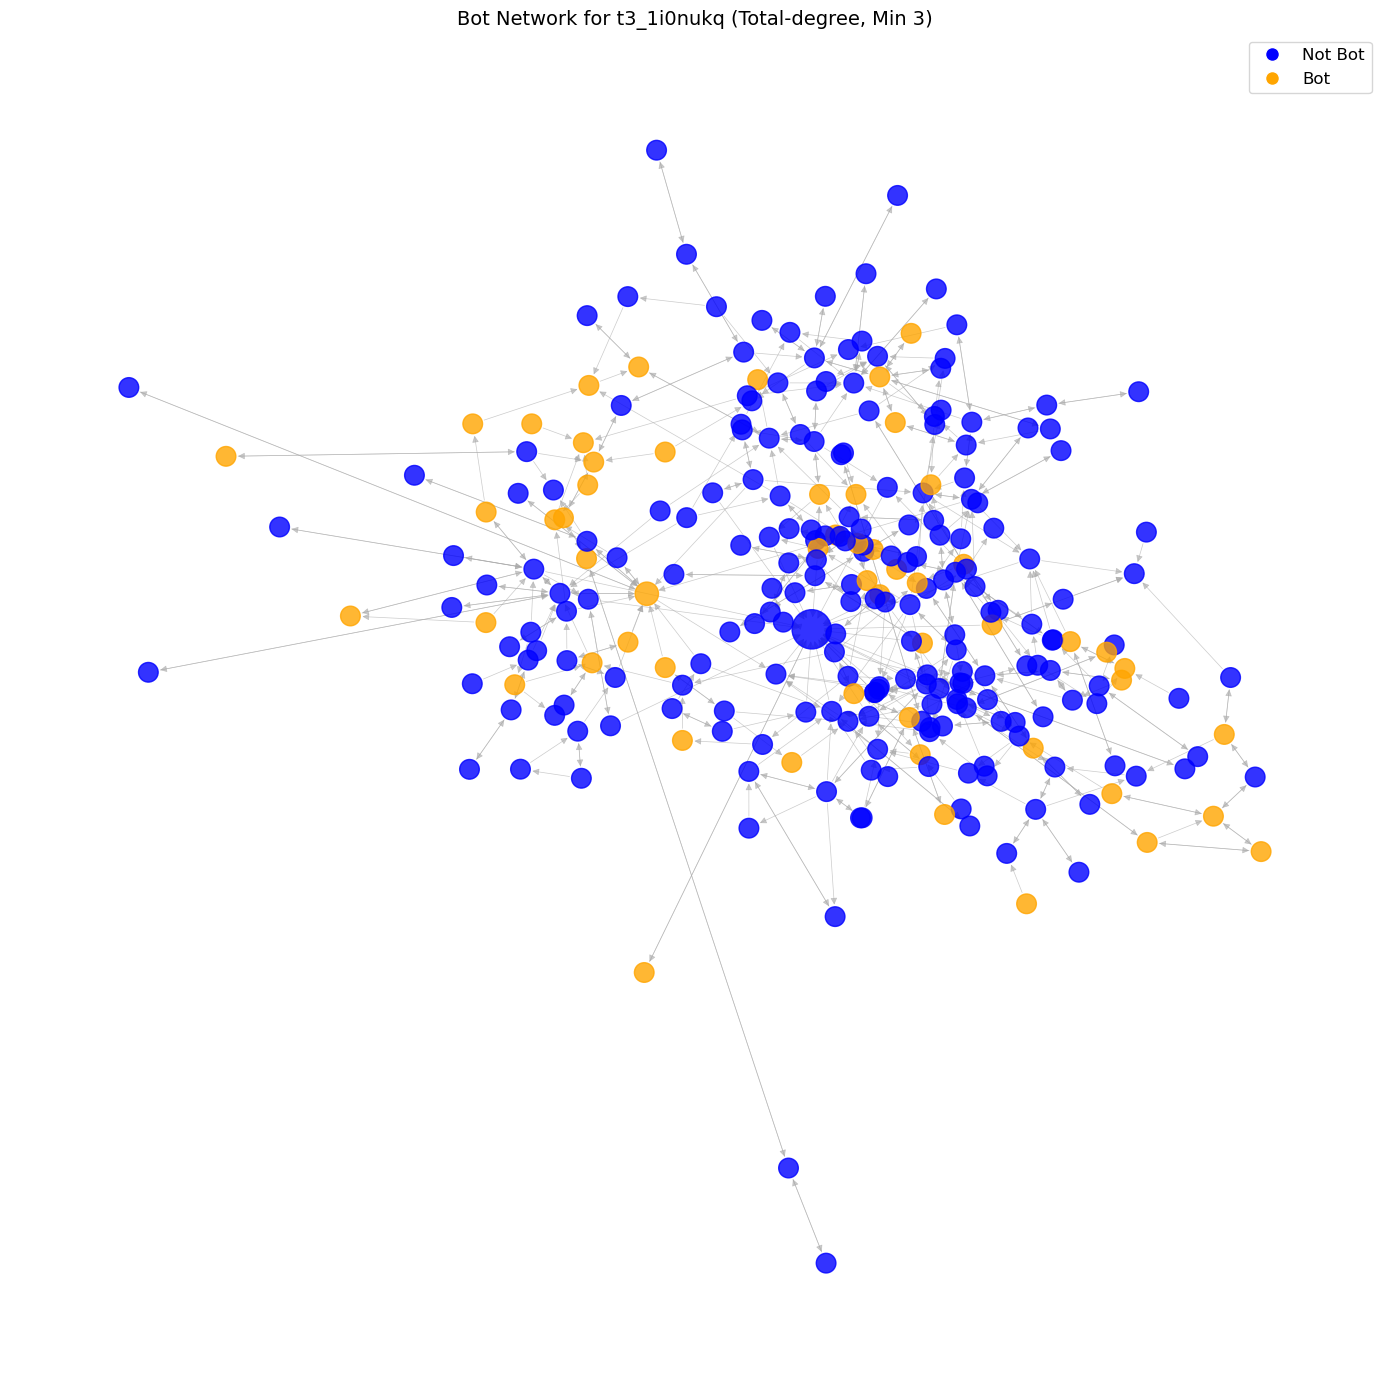

Initial Dictionary:
{'t2_1h42onjnug': 0.0, 't2_dr7y0h07': 0.0, 't2_4ldtogws': 0.0, 't2_prbvrxr': 0.0, 't2_rpb21mm8': 0.0, 't2_bf0260og': 0.0, 't2_9uty86gt': 0.0, 't2_8670sjn7k': 0.0, 't2_ykxsgeko1': 0.010752688172043012, 't2_ubkeg7w': 0.0, 't2_vdflmzxvk': 0.002150537634408602, 't2_3g55k': 0.0, 't2_8nsw3umv': 0.02903225806451613, 't2_3cvd5cm3': 0.007526881720430107, 't2_2lypx848': 0.0, 't2_zz7py6crl': 0.004301075268817204, 't2_c2yfjz2p': 0.0, 't2_31nm3': 0.004301075268817204, 't2_drttiuk5': 0.0, 't2_v369lq2ht': 0.0064516129032258064, 't2_kjr85zcqy': 0.0032258064516129032, 't2_xthom': 0.06236559139784946, 't2_wj2tpwrhc': 0.008602150537634409, 't2_i6ye1drf': 0.002150537634408602, 't2_54x3au7f': 0.0, 't2_4eopssp4': 0.008602150537634409, 't2_12r7awdlwt': 0.0, 't2_qmtmjq8y': 0.021505376344086023, 't2_7xfnym9d': 0.0, 't2_elqjxo7cg': 0.0, 't2_ls2jm5s0': 0.0, 't2_1cwoaroqv9': 0.0} 

Dictionary with 10 highest values:
Keys: Values
t2_xthom  : 0.06236559139784946   human
t2_8nsw3umv  : 0.02903225

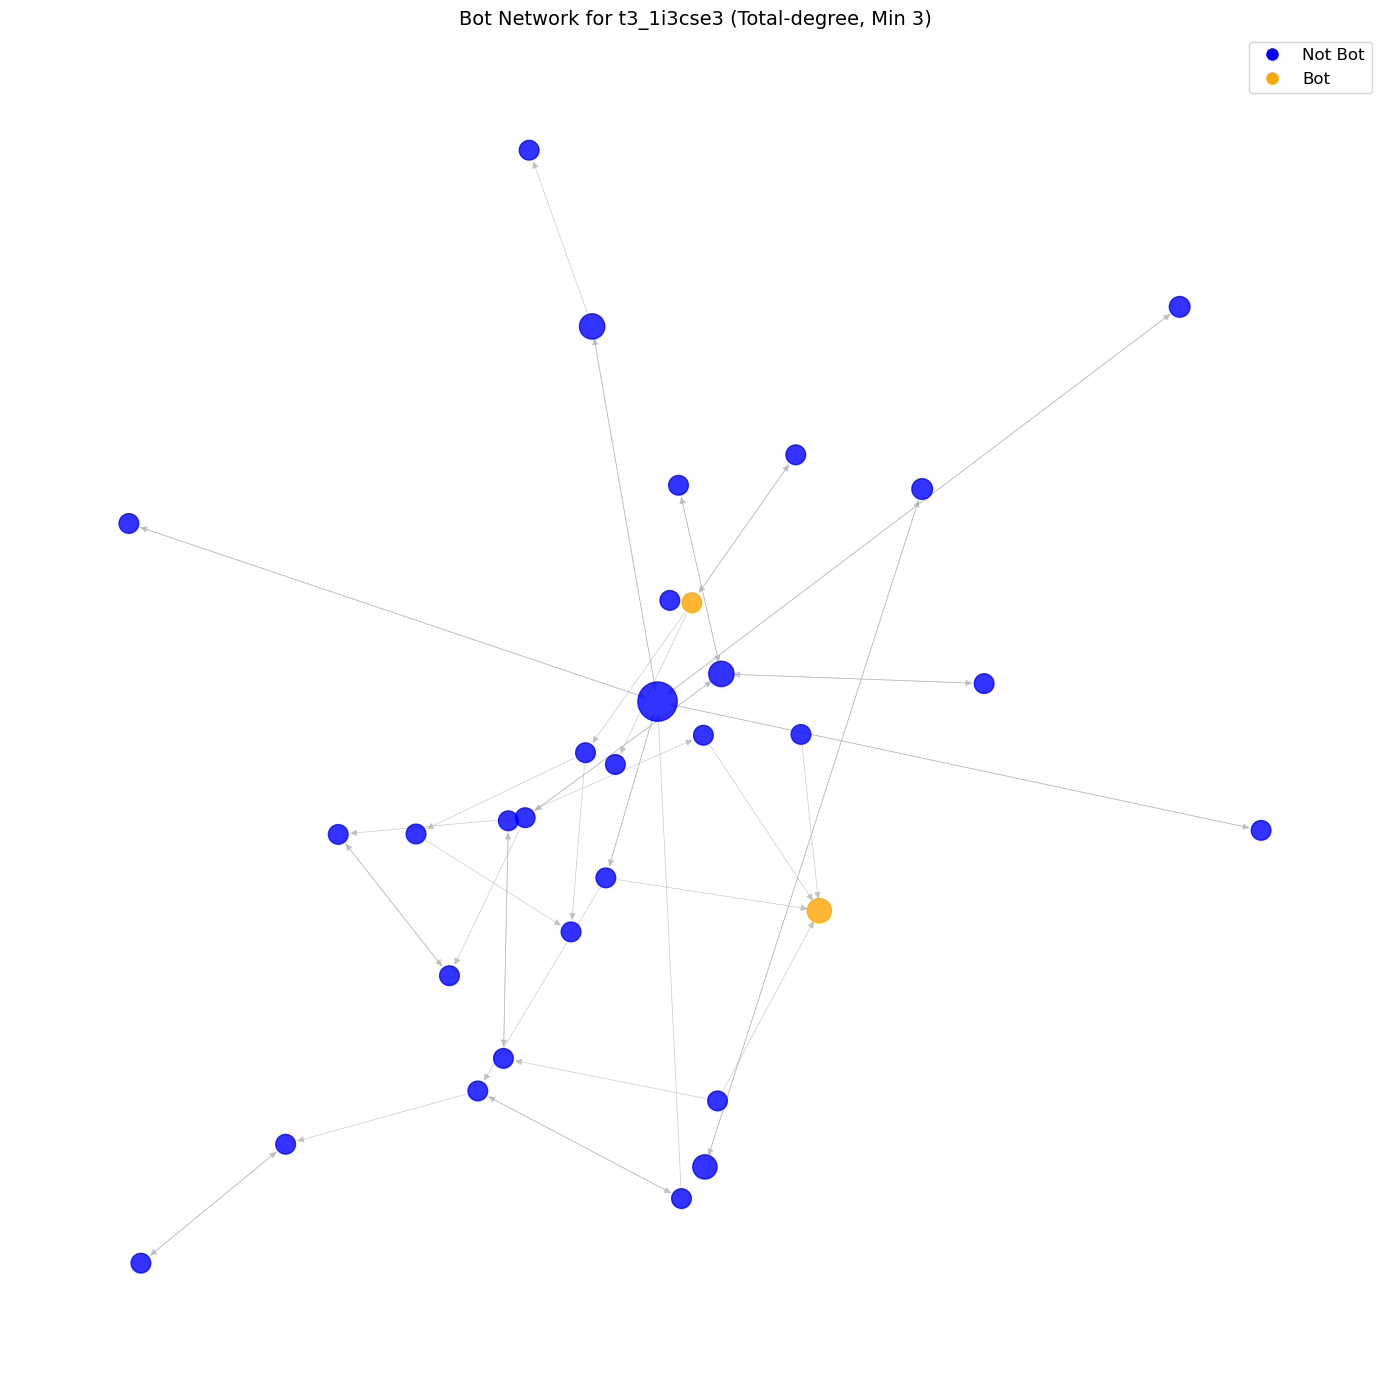

Initial Dictionary:
{'t2_h9aqbsp1': 0.0, 't2_6ulap': 0.0, 't2_1fwpskfj3y': 0.001278772378516624, 't2_7emuegbu': 0.0, 't2_obz7t6y7': 0.0, 't2_vlayp58o': 0.011935208866155157, 't2_5s58msd': 0.0, 't2_syd5q': 0.0, 't2_5rnlo': 0.006606990622335891, 't2_n3q0vl0s': 0.0, 't2_1f2goz6': 0.0, 't2_a93pu': 0.0008525149190110827, 't2_4ratgjqk': 0.0, 't2_86y99zkn': 0.0, 't2_oahgo7ga': 0.017902813299232736, 't2_h4she3vn': 0.0, 't2_9ow0iuoh': 0.0, 't2_2qghqjiy': 0.0, 't2_sfpiyt3cx': 0.00042625745950554135, 't2_kqts1h4l': 0.0, 't2_dn20dl20': 0.0, 't2_kr0qv': 0.0, 't2_2d32lww6': 0.0, 't2_vn4n524': 0.0, 't2_1ljx6geo': 0.0, 't2_i1ro3': 0.0, 't2_lnrevma7g': 0.0, 't2_14nsg93yu8': 0.0008525149190110827, 't2_1fy5txfi4d': 0.0008525149190110827, 't2_6pi9m': 0.000639386189258312, 't2_gz1ngbm3': 0.0, 't2_tj33gfvh': 0.011935208866155157, 't2_lcr8as6': 0.001278772378516624, 't2_v8n37ug': 0.0014919011082693947, 't2_2z43dwgj': 0.0159846547314578, 't2_nhz72w1t': 0.0, 't2_8l5oztgr': 0.0017050298380221654, 't2_aojxxp4jk'

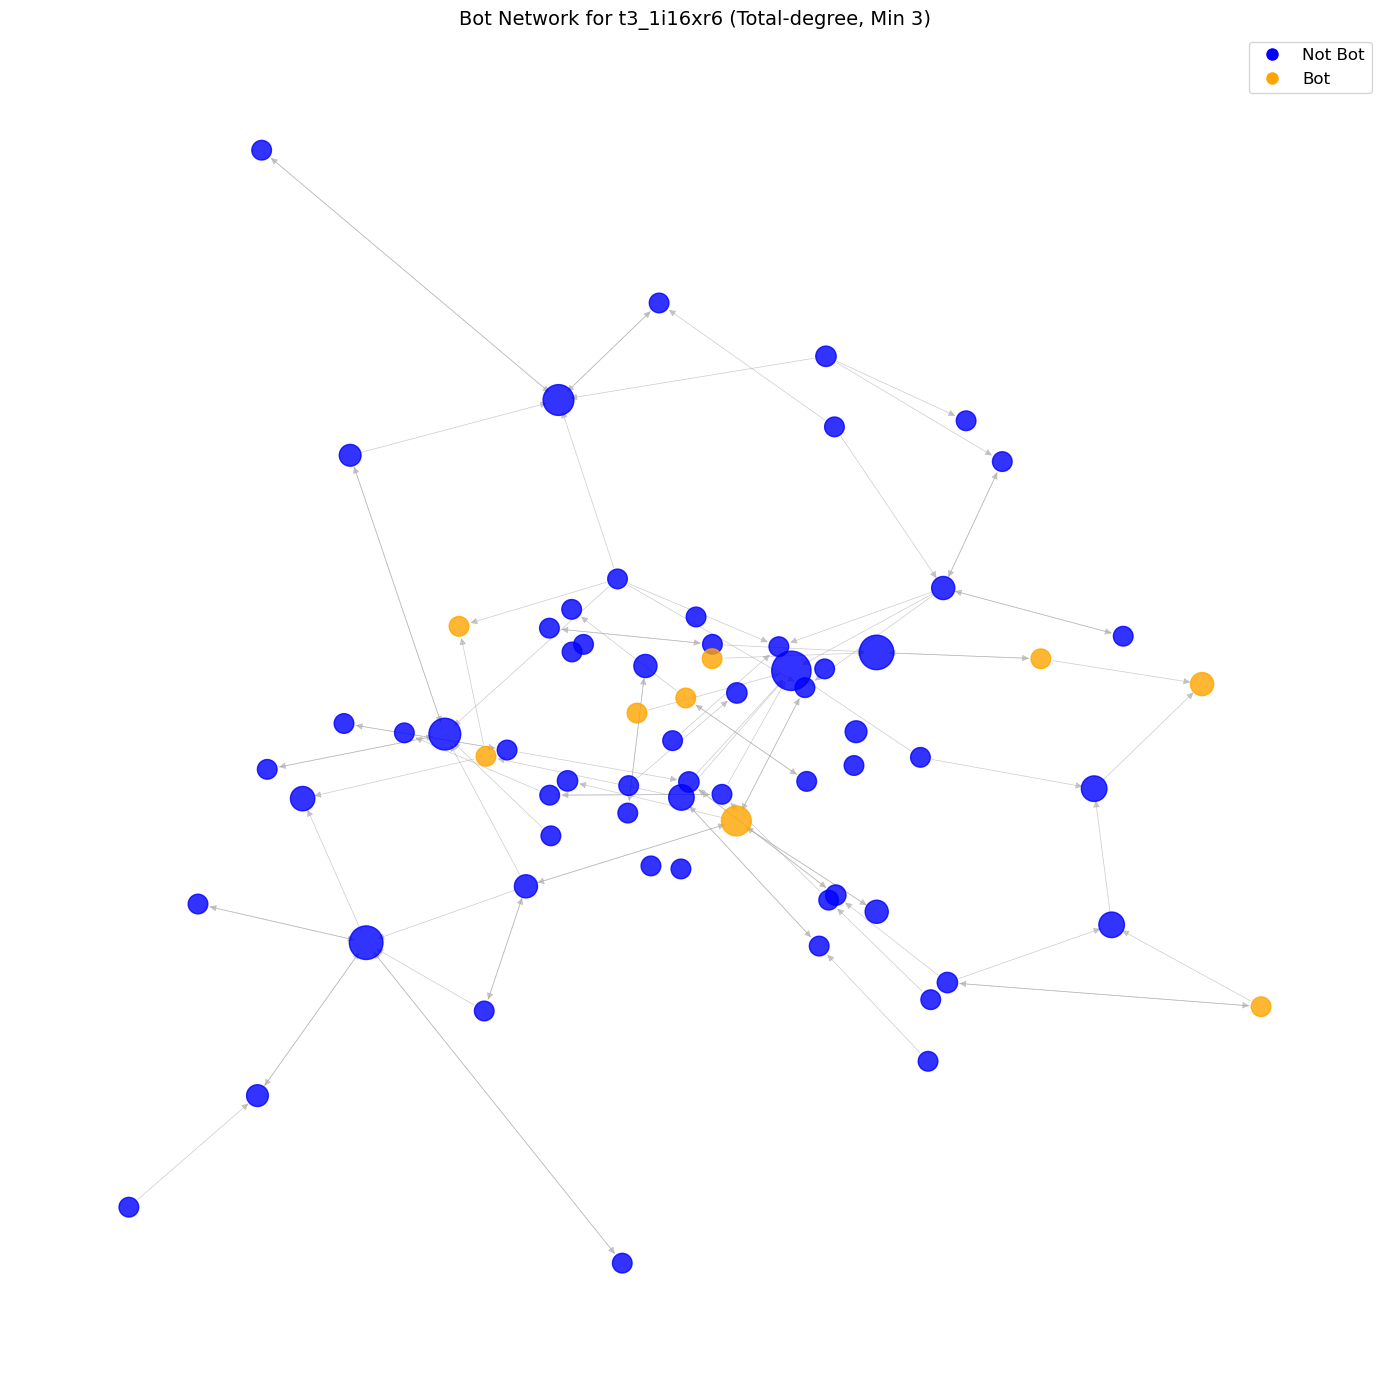

Initial Dictionary:
{'t2_wkhi0': 0.0, 't2_50qwilia': 0.0, 't2_g1wkr9ko': 0.10125492125984252, 't2_8srss1tc': 0.0, 't2_7ux5p': 0.0, 't2_68mk8': 0.0, 't2_rtcbcez3': 0.0, 't2_144qck6tre': 0.0, 't2_qpcs3vvhd': 0.0002768208661417323, 't2_9h50mel': 0.0, 't2_tp9fy': 0.019162155511811024, 't2_s3f499yjv': 0.0, 't2_lfhd09gr': 0.0, 't2_rfpnw99': 0.0014148622047244095, 't2_i1c74g9s': 0.0, 't2_alv7u7l0t': 0.0014661253280839894, 't2_108c2006ct': 0.0, 't2_1cka95kca2': 0.0, 't2_qcbf1af59': 0.0, 't2_3nknl7nc': 0.0, 't2_3osxtypq': 0.0, 't2_6fakh1fv': 0.0, 't2_bvhdc9': 0.0, 't2_i55iyso9': 0.0, 't2_1nz7g7rq': 0.0054133858267716535, 't2_86n4bwo0': 0.0, 't2_giu07df5': 0.11343503937007873, 't2_3x70qiba': 0.0, 't2_4gf6gb1x': 0.0, 't2_17ghiv': 0.0, 't2_kwbjdmb': 0.0, 't2_uooembys': 0.0, 't2_sgr66up0q': 0.0, 't2_2my704l6': 0.0, 't2_9dk4i94a': 0.0, 't2_fefk65ma': 0.0, 't2_r6n1nyol': 0.0, 't2_mvv97pk': 0.0, 't2_zvukcyjpm': 0.0, 't2_c5n01mxj': 0.0, 't2_v0yfjlo0': 0.0179318405511811, 't2_wb682': 3.075787401574803e-

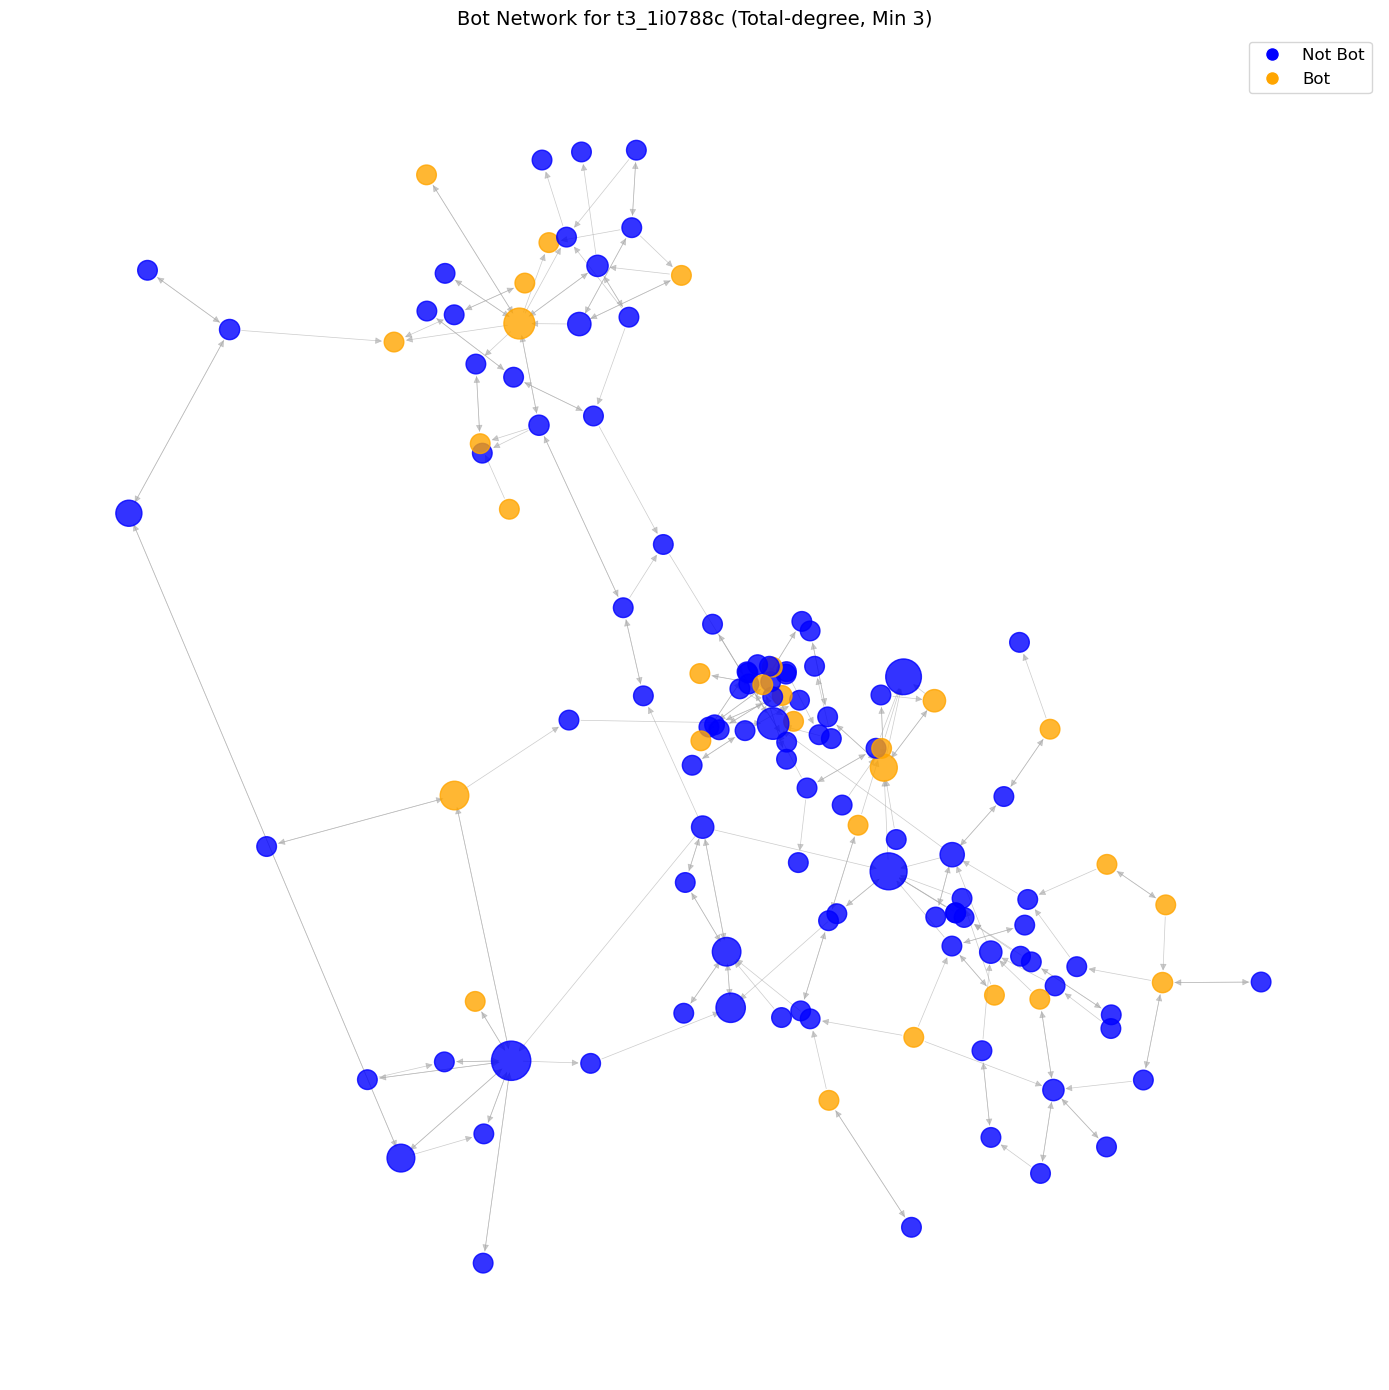

Initial Dictionary:
{'t2_mm7m0ccve': 2.4629328604502242e-05, 't2_oxub5tnr': 0.0, 't2_1kbebmiu': 0.0, 't2_9ourbvb': 0.0016501650165016502, 't2_u67rd0zep': 0.0, 't2_29iwtb62': 0.0036451406334663317, 't2_1cdvprap1d': 0.0, 't2_v9d2cnx4': 0.0, 't2_nhku54oy5': 0.017819319245357373, 't2_4140kyai': 0.08145411556080982, 't2_sz3xedst': 0.0, 't2_ruj6avkh': 0.0, 't2_5uvd2idm': 0.0, 't2_zyey9': 0.0, 't2_w0eb509c': 0.0, 't2_671ljczt': 4.9258657209004484e-05, 't2_smf1qihpc': 0.0, 't2_c9aojh9p': 0.0, 't2_1anqfaaqto': 0.0, 't2_3iob4q00': 0.0, 't2_1hhsklhfbg': 0.0, 't2_brfo7sxm9': 2.4629328604502242e-05, 't2_et93i6rsc': 2.4629328604502242e-05, 't2_hpb0ovqr': 0.0, 't2_6pn4daxt': 0.0, 't2_gnutvhfm2': 0.0, 't2_5etovt5jw': 0.0033988473474213096, 't2_5nuhx3x3': 0.0003940692576720359, 't2_mzow4uf8': 0.0, 't2_ygnrp69ts': 0.0, 't2_q82wibl1': 0.0, 't2_5xml05w0': 0.00024629328604502243, 't2_2lmouueb': 0.0016747943451061525, 't2_vr3pgnhx': 0.005664745579035515, 't2_2frt7jv9': 0.0018471996453376682, 't2_khnoctqa': 

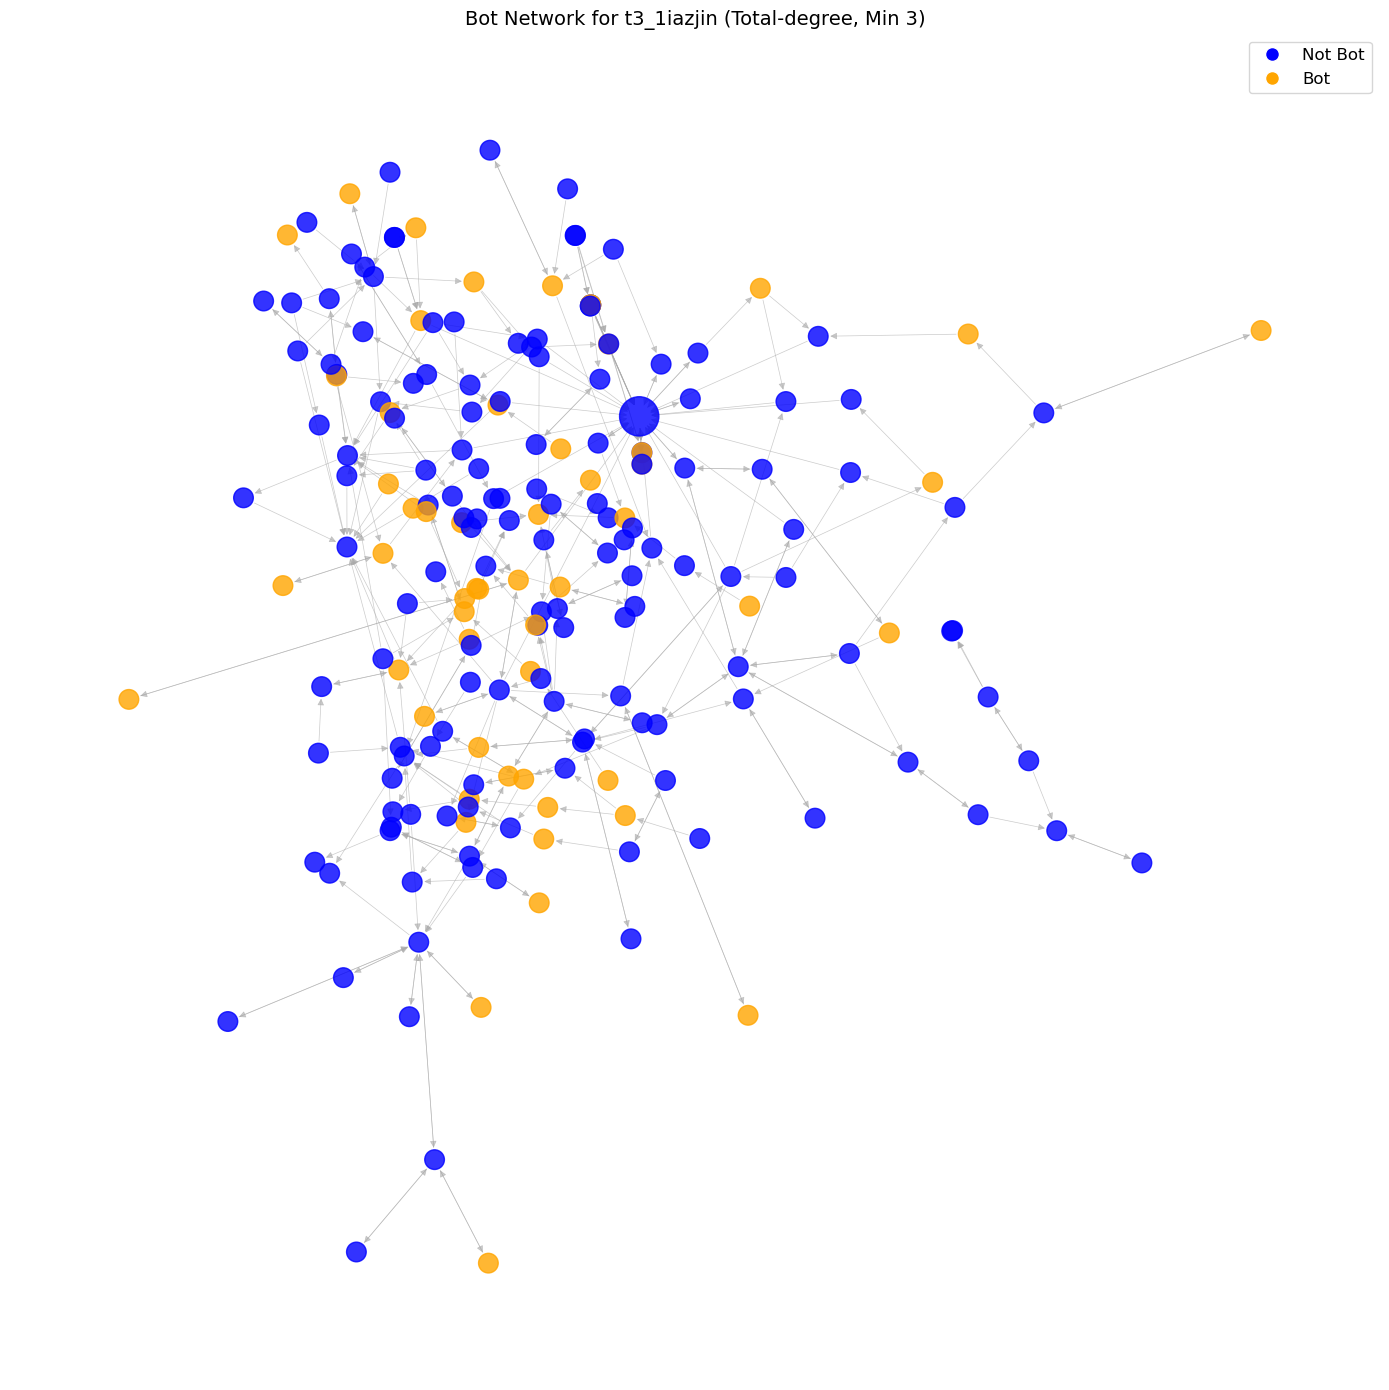

In [37]:
for post in posts:
    G, plot = plot_network_degree(post, post_node_edge_dict, thr_70, min_degree = 3, degree_type = "total")
    top_betweenness(G)
    plot.show()

## 5.Plot Complete Posts Networks

We also want to plot some graphs for the complete network of all posts we have:

we follow the same logic as we deal with single post using 

In [38]:
complete_dict = dict()
for post_id in ['complete']:
    complete_dict[post_id] = {}
    complete_dict[post_id]['user'], complete_dict[post_id]['edge'] = compute_node_edge(post_id)

Initial Dictionary:
{'t2_nhku54oy5': 0.0, 't2_giu07df5': 0.0, 't2_r1z0gncq2': 0.0, 't2_1hl98tzaiu': 0.0, 't2_1ahncy8klp': 0.0, 't2_8kmztost': 0.00011086474501108647, 't2_8l0g7jqf': 0.0, 't2_1hzvzxepdw': 0.0, 't2_6a5uuf48': 0.0, 't2_x0fd57exc': 0.0, 't2_o1jtvc6rk': 0.0, 't2_od2zf4y0e': 0.0, 't2_1g364i6w6d': 0.0, 't2_7at8m7d4w': 7.390983000739098e-05, 't2_x5ly14bip': 0.0, 't2_qp7al': 0.0, 't2_7wtd1': 0.0, 't2_7utg0iix': 0.0, 't2_yeri7mt': 0.0, 't2_5pvpqo0b': 0.0, 't2_ec39o': 0.0, 't2_537n5': 0.0, 't2_qk7cf14q': 0.0, 't2_1597cldnbe': 0.0, 't2_6l4z3': 0.0, 't2_93aqu': 0.0, 't2_158fcprtpm': 0.00014781966001478197, 't2_4bvy7ob6': 0.0, 't2_bno90': 0.0, 't2_13tggbemg0': 0.0, 't2_2hm6l94u': 0.0, 't2_r4zx1zd1': 0.0, 't2_k36l1ydf': 0.0, 't2_1fjwneinop': 7.390983000739098e-05, 't2_rg4zxpty': 0.0, 't2_1epclhfffo': 0.0, 't2_xthom': 0.0, 't2_ecc7w': 0.0, 't2_9q1uyk0x': 0.0, 't2_4r7pz': 0.0004434589800443459, 't2_elee5': 0.0008130081300813008, 't2_35umm': 0.0, 't2_cag3a': 0.0005543237250554324, 't2_8x

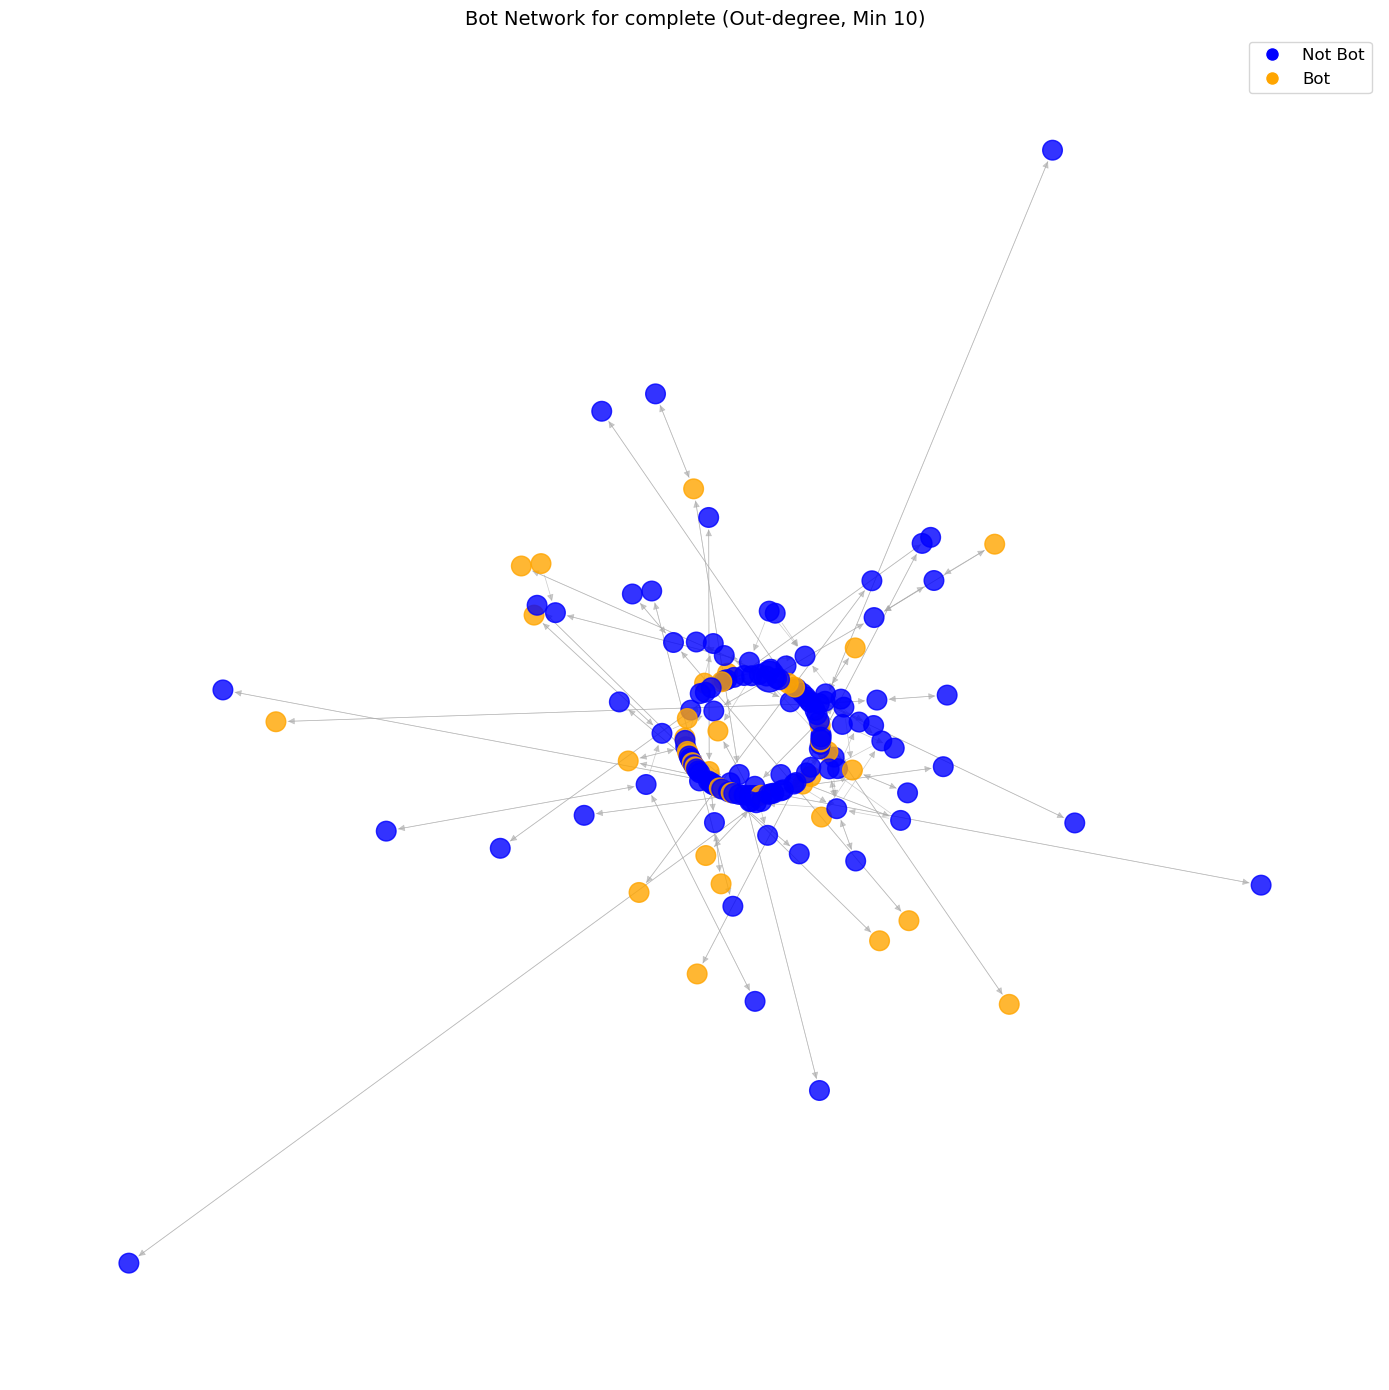

In [39]:
#filter using out degree
G, plot = plot_network_degree('complete', complete_dict, thr_70, min_degree = 10, degree_type="out")
top_betweenness(G)
plot.show()

Initial Dictionary:
{'t2_oxub5tnr': 0.0, 't2_1kbebmiu': 0.0, 't2_9ourbvb': 0.0, 't2_u67rd0zep': 0.0, 't2_29iwtb62': 0.0, 't2_v9d2cnx4': 0.0, 't2_nhku54oy5': 0.0, 't2_84vc0uib': 0.0, 't2_7gztzgdq': 0.0, 't2_r1z0gncq2': 0.0011163393671676188, 't2_1dny0xwwnr': 0.0, 't2_1ahncy8klp': 0.0, 't2_8kmztost': 2.400729821865847e-05, 't2_8l0g7jqf': 8.002432739552824e-06, 't2_1hzvzxepdw': 0.00012803892383284518, 't2_by3jz': 0.0, 't2_ydmsj': 8.002432739552824e-06, 't2_1bvxj0tvf0': 0.0, 't2_rsw5ru7gs': 3.2009730958211295e-05, 't2_33kodkn7': 4.001216369776412e-05, 't2_qogoq9df': 0.0, 't2_19wxndl740': 0.0, 't2_1hq1grhz': 0.0, 't2_1esq4hfq0d': 0.0, 't2_9a7co': 0.0, 't2_o1jtvc6rk': 0.0, 't2_prtspyjr': 0.0, 't2_od2zf4y0e': 0.0, 't2_e3hu1js0': 0.0, 't2_116bx9614x': 0.0, 't2_4dfhg': 0.0, 't2_18pfn343z4': 4.001216369776412e-05, 't2_7jzye': 0.0, 't2_1g364i6w6d': 0.0, 't2_5881n': 1.6004865479105648e-05, 't2_mii9l08v': 8.002432739552824e-06, 't2_7at8m7d4w': 8.002432739552824e-06, 't2_x5ly14bip': 1.60048654791056

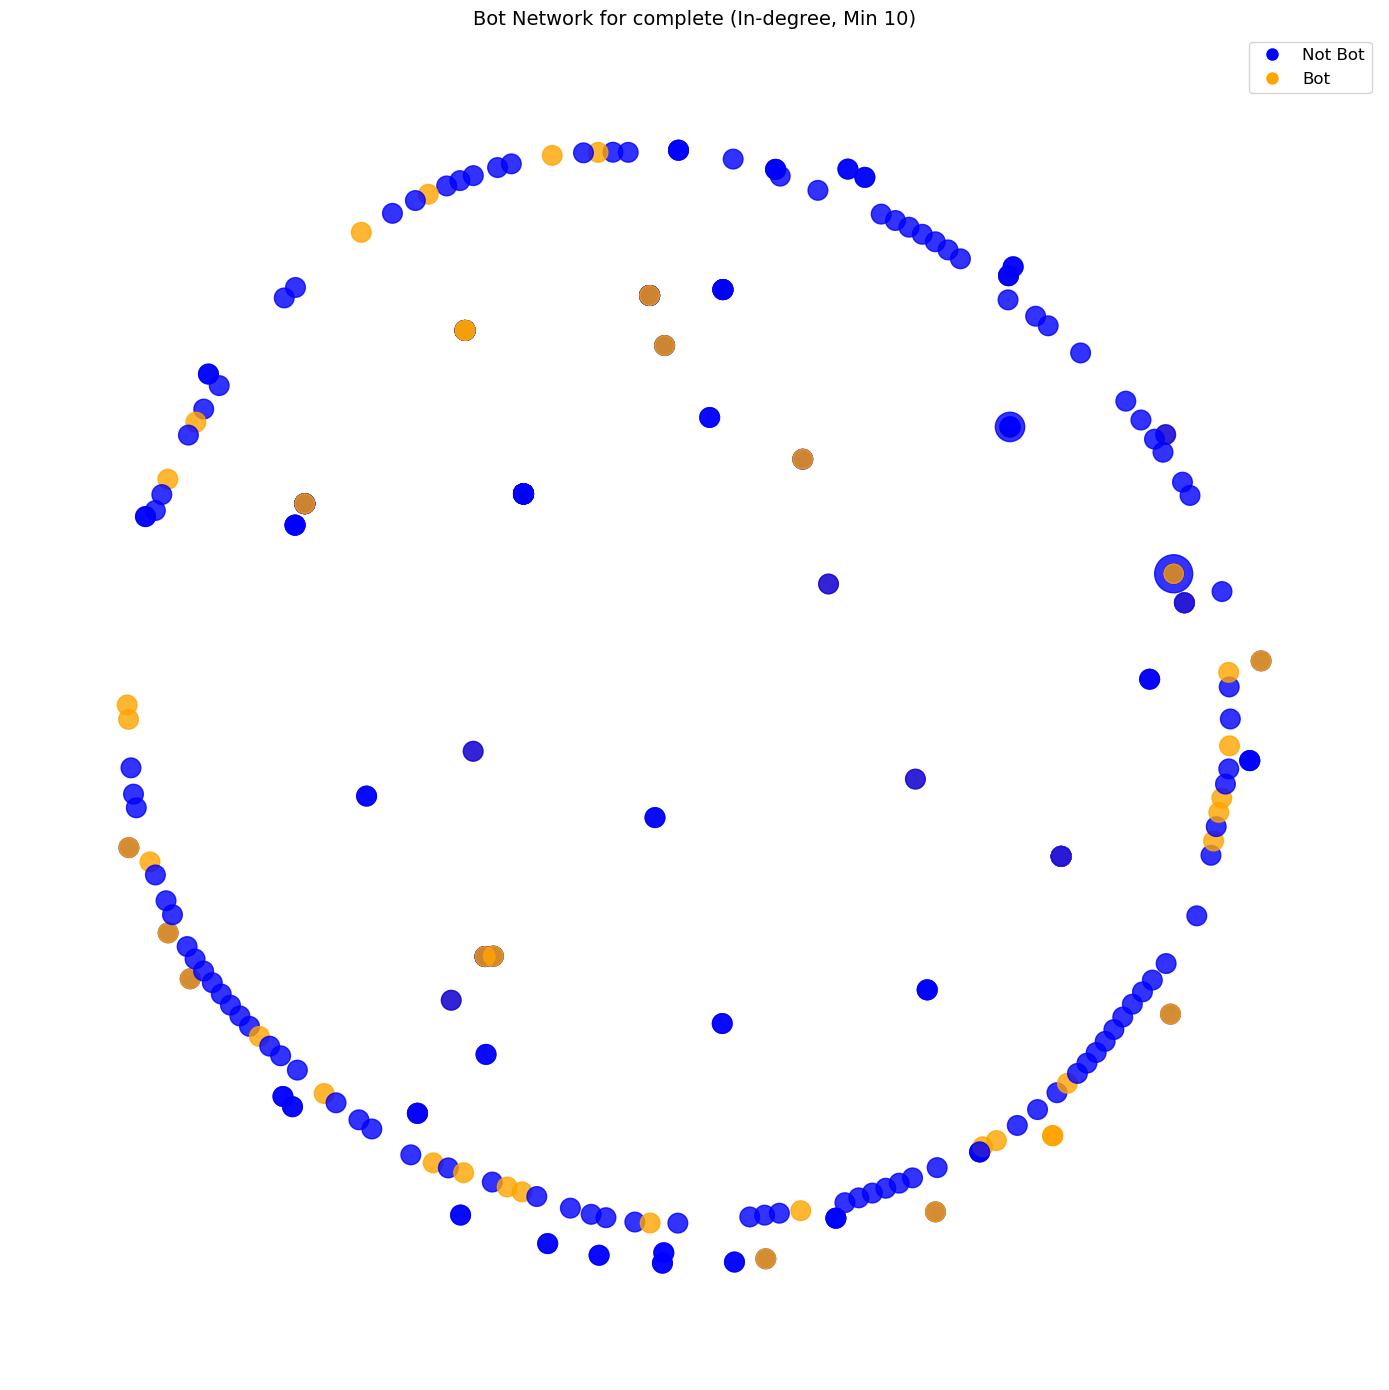

In [40]:
G, plot = plot_network_degree('complete', complete_dict, thr_70, min_degree = 10, degree_type = "in")
top_betweenness(G)
plot.show()

Initial Dictionary:
{'t2_mm7m0ccve': 2.253769097378734e-05, 't2_oxub5tnr': 0.0, 't2_1kbebmiu': 0.0, 't2_9ourbvb': 0.0, 't2_u67rd0zep': 0.0, 't2_29iwtb62': 0.0, 't2_v9d2cnx4': 0.0, 't2_nhku54oy5': 1.3257465278698435e-06, 't2_4140kyai': 5.568135417053343e-05, 't2_3iob4q00': 0.0, 't2_70v8vmo': 0.0006071919097643884, 't2_et93i6rsc': 0.0, 't2_vr3pgnhx': 9.280225695088904e-06, 't2_84vc0uib': 0.0, 't2_giu07df5': 2.651493055739687e-05, 't2_7gztzgdq': 0.0, 't2_r1z0gncq2': 0.0027114388945748665, 't2_1dny0xwwnr': 1.3257465278698435e-05, 't2_1hl98tzaiu': 4.640112847544452e-06, 't2_1ahncy8klp': 0.00018162727431816856, 't2_8kmztost': 5.568135417053343e-05, 't2_8l0g7jqf': 1.3257465278698435e-06, 't2_10ucv9vg3l': 0.0, 't2_15q7epcd': 0.0, 't2_5fonf': 4.242388889183499e-05, 't2_1hzvzxepdw': 0.00012859741320337483, 't2_3xgc7p6b': 0.0, 't2_by3jz': 0.0, 't2_ydmsj': 1.3257465278698435e-06, 't2_5t9cgirlu': 0.0, 't2_2uu6xvlx': 0.0, 't2_v7fgpnq4': 0.0, 't2_1bvxj0tvf0': 0.0, 't2_rsw5ru7gs': 2.7840677085266714e-

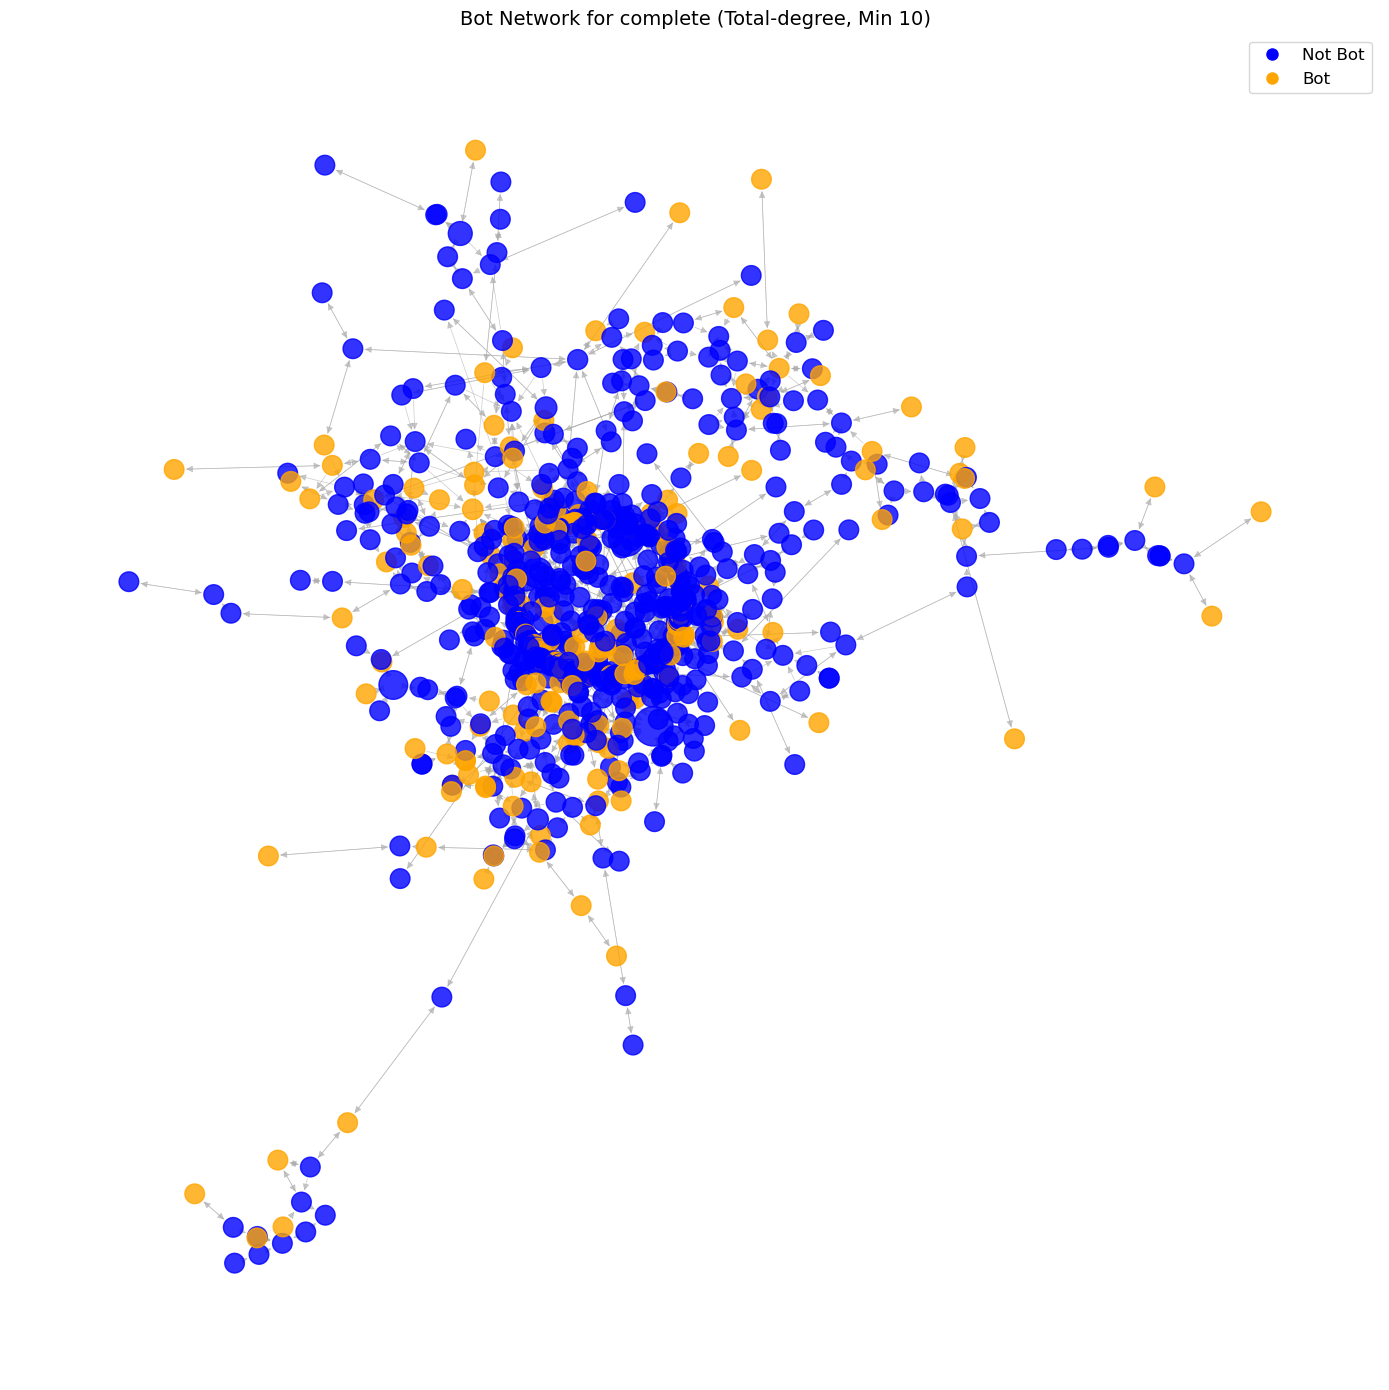

In [41]:
G, plot = plot_network_degree('complete', complete_dict, thr_70, min_degree = 10, degree_type = "total")
top_betweenness(G)
plot.show()

## 6.Posts Network

we want to create a network of all posts using the shared users as edge

In [42]:
with open('networkdata/reddit_reply_to_complete_by_post.json') as f:
    post_data = json.load(f)

In [43]:
with open('reddit_posts_cleaned.json') as f:
    post_df = json.load(f)

In [44]:
from itertools import combinations

In [45]:
post_lst = post_data.keys()

In [46]:
#creates all possible pairs of posts without repetition

combos = list(combinations(post_lst, 2))

In [47]:
len(combos)

13203

In [48]:
edge_attrs = dict()
weighted_lst = []
for tpl in combos:
    #Find Common Users Between the Two Posts
    common_users = set(post_data[tpl[0]]).intersection(post_data[tpl[1]])
    accumulated_bot_prob = 0

    #Calculate the Total Bot Probability of Shared Users
    for user in common_users:
        if user in bot_df.index:
            accumulated_bot_prob += bot_df.loc[user]['botprobability']
    common_user_count = len(common_users)
    if common_user_count != 0:
        edge_attrs.setdefault((tpl[0], tpl[1]), dict())
        #Adds an edge with a weight (based on shared users) to weighted_lst
        weighted_lst.append((tpl[0], tpl[1], common_user_count))
        #Add edge attributes with the average bot probability for shared users
        average_shared_bot_prob = accumulated_bot_prob / common_user_count
        edge_attrs[(tpl[0], tpl[1])]['avg_bot_prob'] = average_shared_bot_prob

In [49]:
len(edge_attrs)

1792

In [50]:
## add node attributes with post topics
node_attr = dict()
for dictionary in post_df:
    node_attr[dictionary['name']] = dict()
    node_attr[dictionary['name']]['topic'] = dictionary['topic']

In [51]:
# initialize the post graph object using post edge list
G_post = nx.Graph()
G_post.add_nodes_from(post_lst)
G_post.add_weighted_edges_from(weighted_lst)
nx.set_edge_attributes(G_post, edge_attrs)
nx.set_node_attributes(G_post, node_attr)

In [52]:
G_post.nodes['t3_1i0nukq']["topic"]

'climate change'

In [53]:
# calculates the average bot probability for each post based on the users who interacted
filtered = dict()
for post in post_lst:
    val = 0
    for user in post_data[post]:
        val += thr_70.get(user, 0.5) 
    filtered[post] = val / len(post_data[post])
nx.set_node_attributes(G_post, filtered, 'bot_prob')

In [54]:
#normalize degree for each node

min_degree = 1
# Calculate total degrees
total_degrees = dict(G_post.degree())
    
# Filter nodes based on total degree
nodes_to_remove = [node for node, degree in total_degrees.items() if degree < min_degree]
G_post.remove_nodes_from(nodes_to_remove)
    
max_total_degree = max(total_degrees.values())
    
# Normalize node sizes based on total degree
min_size = 200  # Minimum node size
normalized_total_degrees = {node: max(min_size, (deg / max_total_degree) * 800)
                            for node, deg in total_degrees.items()}

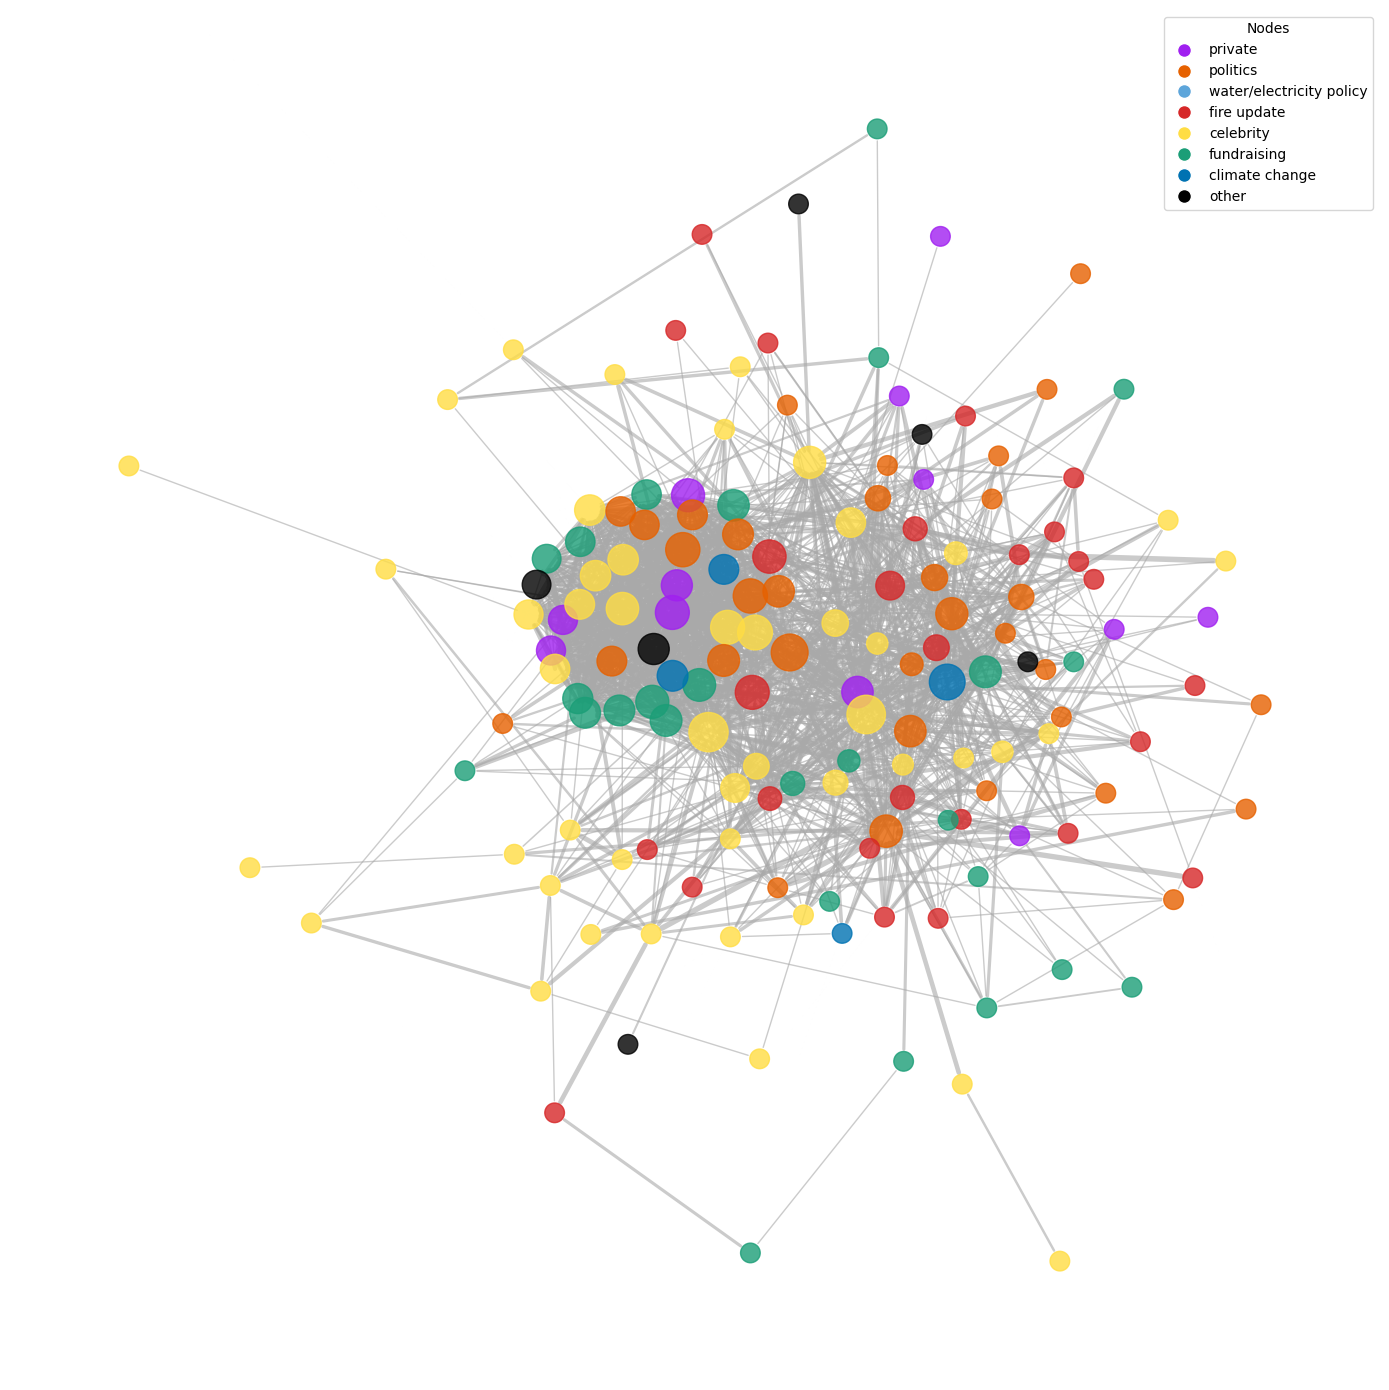

In [55]:
# Create the plot
plt.figure(figsize=(14, 14))  # Larger figure for better visibility
    
# Choose layout with more space
pos = nx.kamada_kawai_layout(G_post, scale = 10)

color_map = {
    'private': '#A020F0',  # Vibrant Purple
    'politics': '#E66100',  # Deep Orange
    'water/electricity policy': '#5DA5DA',  # Strong Blue
    'fire update': '#D62728',  # Bold Red
    'celebrity': '#FFDD44',  # Strong Yellow
    'fundraising': '#1B9E77',  # Teal Green
    'climate change': '#0072B2',  # Deep Blue
    'other': '#000000'  # Black
}

colors = [color_map[G_post.nodes[node]['topic']] for node in G_post]
labels = nx.get_node_attributes(G, 'topic') 

# Draw the edges first
nx.draw_networkx_edges(G_post, 
                        pos=pos, 
                        edge_color="darkgrey", 
                        width=[normalized_total_degrees.get(node, 0) / 200 for node in G_post.nodes()],
                        alpha=0.6, 
                        arrows=True)  # Draw arrows to indicate direction
    
# Draw the nodes
nx.draw_networkx_nodes(G_post,
                        pos=pos,
                        node_color=colors,
                        node_size= [normalized_total_degrees.get(node, 0) for node in G_post.nodes()],
                        alpha=0.8)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=node) for node, color in color_map.items()]
plt.legend(handles=legend_handles, title="Nodes", loc="upper right", frameon=True)

plt.axis('off')
plt.tight_layout()
plt.show()
    

we use community detection to find clusterings in the post network

In [56]:
from networkx.algorithms import community

In [57]:
def find_community(graph,k):
    """
    Uses networkx.algorithms.community.k_clique_communities to detect k-clique communities.
    k: defines the minimum clique size required for a community.
    """
    return list(community.k_clique_communities(graph,k))

for k in range(2,10):
        print ("############# k-Clique: %d ################" % k)
        rst_com = find_community(G_post,k)
        print ("Count of Community being found：%d" % len(rst_com))
        print(rst_com)

############# k-Clique: 2 ################
Count of Community being found：2
[frozenset({'t3_1i57xek', 't3_1i4bq0r', 't3_1hzxrwb', 't3_1i4oxwy', 't3_1i9ptbh', 't3_1ies7ut', 't3_1hxp6dt', 't3_1hxdb4b', 't3_1i21g0o', 't3_1i9rhvs', 't3_1i36jqq', 't3_1ii07qf', 't3_1i2467n', 't3_1hxavqr', 't3_1hy9y05', 't3_1ia0gnz', 't3_1hxpcnz', 't3_1hwr0fg', 't3_1i0u2w3', 't3_1i16xr6', 't3_1hxnqo3', 't3_1i0d0i9', 't3_1hyk2ha', 't3_1i2oiq2', 't3_1hw8wni', 't3_1hx8l58', 't3_1hzyp4e', 't3_1hx7sz7', 't3_1i9w3no', 't3_1hynqmt', 't3_1i4dvxt', 't3_1i5p8m4', 't3_1hxlaux', 't3_1hzlvh4', 't3_1i3cse3', 't3_1i0kavt', 't3_1hxeqkl', 't3_1i0u1cd', 't3_1i0xtei', 't3_1i0ie0y', 't3_1i0k30k', 't3_1hyw7g6', 't3_1hwsk85', 't3_1hy9zkk', 't3_1hxkzua', 't3_1ieulw7', 't3_1hz3nl8', 't3_1iem0yi', 't3_1i1a8fr', 't3_1hzwvsy', 't3_1hwvjv9', 't3_1i3oyye', 't3_1i0nxw8', 't3_1i8tynz', 't3_1hyzspk', 't3_1hwt3a2', 't3_1i4yfr2', 't3_1hxgl79', 't3_1hwry9x', 't3_1i0i8hj', 't3_1i5uyi8', 't3_1i2xo3j', 't3_1i1ciqm', 't3_1i00tjx', 't3_1i49buz', 't

In [58]:
import seaborn as sns

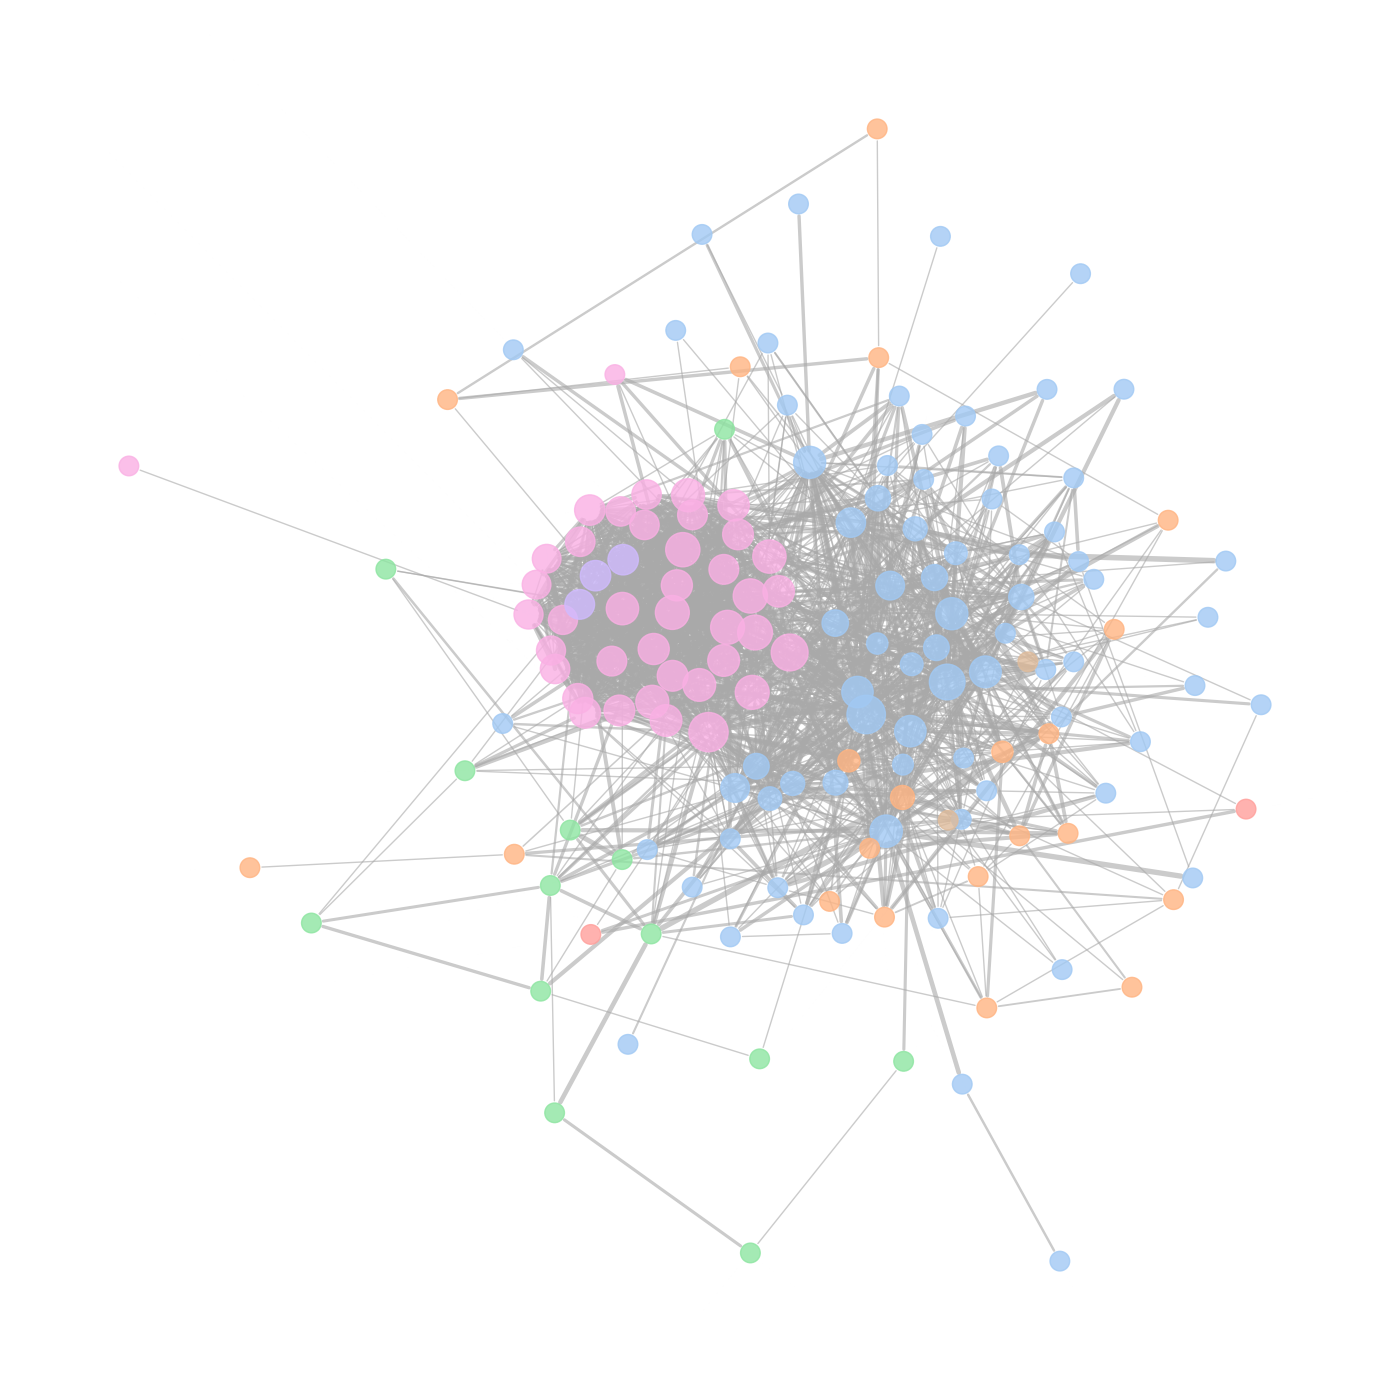

In [59]:
colors = list(sns.color_palette("pastel").as_hex())
#applies the Louvain algorithm to detect communities in a graph.
lst_m = community.louvain_communities(G_post)

#set black as default color
color_map_b = {}
keys = G_post.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values

#Assign Colors to Each Community
counter = 0
for c in lst_m:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1
# Create the plot
plt.figure(figsize=(14, 14))  # Larger figure for better visibility
    
# Choose layout with more space
pos = nx.kamada_kawai_layout(G_post)
    
    # Draw the edges first
nx.draw_networkx_edges(G_post, 
                        pos=pos, 
                        edge_color="darkgrey", 
                        width=[normalized_total_degrees.get(node, 0) / 200 for node in G_post.nodes()],
                        alpha=0.6, 
                        arrows=True)  # Draw arrows to indicate direction
    
    # Draw the nodes
nx.draw_networkx_nodes(G_post,
                        pos=pos,
                        node_size= [normalized_total_degrees.get(node, 0) for node in G_post.nodes()],
                        alpha=0.8, node_color=dict(color_map_b).values())

plt.axis('off')
plt.tight_layout()
plt.show()

## 7.Descriptive Measures

In [60]:
def create_network(post_id, dictionary, bot_classification):
    """
    initialize a network using edge list
    """
    user_lst = dictionary[post_id]['user']
    weight_list = dictionary[post_id]['edge']

    # Create directed network graph from node list and weighted edge list
    graph = nx.DiGraph()
    graph.add_nodes_from(user_lst)
    graph.add_weighted_edges_from(weight_list) # Create a directed graph
    add_bot_attr(graph, bot_classification)

    #G.remove_edges_from(list(G.selfloop_edges()))
    graph.remove_edges_from([(u, v) for u, v in graph.edges() if u == v])

    return graph

In [61]:
def compute_descriptive(graph, post_id):
    """
    compute all descriptive measures for a given graph object
    """
    # Calculate node in-degrees and out-degrees
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    #max in-degree and out-degree
    max_in_degree = max(in_degrees.values())
    max_out_degree = max(out_degrees.values())
    reciprocity = nx.reciprocity(graph)
    assortativity = nx.attribute_assortativity_coefficient(graph, 'botornot')
    transitivity = nx.transitivity(graph)
    avg_clustering = nx.average_clustering(graph)


    return [post_id, max_in_degree, max_out_degree, reciprocity, assortativity,
            transitivity, avg_clustering]
    

In [62]:
# generate a dataframe combining the descriptive measuare for all posts
descriptive_stats = []
for post in posts:
    G = create_network(post, post_node_edge_dict, thr_70)
    row = compute_descriptive(G, post)
    descriptive_stats.append(row)

descriptive_df = pd.DataFrame(descriptive_stats, columns = ['post', 'max_in_degree', 'max_out_degree', 'reciprocity', 'assortativity',
                                                            'transitivity', 'avg_clustering'])

In [63]:
descriptive_df

post  max_in_degree  max_out_degree  reciprocity  assortativity  \
0   t3_1hwsk85             41              10     0.301370      -0.073982   
1   t3_1hxstm9             38              10     0.324201      -0.056608   
2   t3_1hy9y05             40             122     0.439306      -0.074534   
3   t3_1hyw7g6             49              14     0.451128       0.094708   
4   t3_1hz6ake             11               3     0.212389      -0.049072   
5   t3_1i0kavt             30              54     0.400000       0.123002   
6   t3_1i0nukq            131              14     0.311330       0.100039   
7   t3_1i3cse3             10               5     0.339623      -0.112390   
8   t3_1i16xr6             24               6     0.269113       0.006781   
9   t3_1i0788c             28              12     0.365462      -0.017069   
10  t3_1iazjin            231              16     0.173272       0.018004   

    transitivity  avg_clustering  
0       0.019578        0.005354  
1       0.037500        0.015964  
2       0.000541        0.011112  
3       0.042254        0.027777  
4       0.000000        0.000000  
5       0.006540        0.014686  
6       0.043575        0.013306  
7       0.039474        0.008996  
8       0.029167        0.009182  
9       0.039185        0.009253  
10      0.025100        0.002715

In [64]:
G = create_network('complete', complete_dict, thr_70)

In [65]:
# apply the descriptive measures to the network with replies of all posts

whole_network_stats = compute_descriptive(G, 'complete')
whole_network_stats.extend([nx.betweenness_centrality(G, normalized=True, weight= None, endpoints=False, seed=0), nx.degree_centrality(G)])

In [101]:
#calculates the proportion of bots among nodes with normalized betweenness centrality greater than zero

total = 0
bot_count = 0
bot_betweenness = []
human_betweenness = []
for key, value in whole_network_stats[7].items():
    if value > 0:
        total += 1
        if key in thr_70:
            if thr_70[key]:
                bot_count += 1
                bot_betweenness.append(value)
            else:
                human_betweenness.append(value)
bot_count / total

0.2411918663176968

In [67]:
def bot_proportion(network_stats, thr_70, value_thre):
    """
    Computes bot/human between centrality df and the proportion of bots above a given betweenness centrality.
    """
    total = 0
    bot_count = 0
    bot_betweenness = []
    human_betweenness = []

    for key, value in network_stats[7].items():
        if value > value_thre:  # Consider only nodes with nonzero betweenness
            total += 1
            if key in thr_70:
                if thr_70[key]:  # If the node is a bot
                    bot_count += 1
                    bot_betweenness.append(value)
                else:  # If the node is a human
                    human_betweenness.append(value)

    # Avoid division by zero
    bot_ratio = bot_count / total if total > 0 else 0

    return bot_ratio

In [68]:
import seaborn as sns

In [91]:
# calculate using between centrality threshold 0

bot_proportion(whole_network_stats, thr_70, 0)

human_betweenness_data = pd.DataFrame(human_betweenness, columns=['betweenness'])
human_betweenness_data['humanorbot'] = 'human'
bot_betweenness_data = pd.DataFrame(bot_betweenness, columns=['betweenness'])
bot_betweenness_data['humanorbot'] = 'bot'
betweenness_data = pd.concat([human_betweenness_data, bot_betweenness_data]).reset_index()
del betweenness_data['index']

In [93]:
betweenness_data[:10]

betweenness humanorbot
0  1.380677e-05      human
1  1.083883e-04      human
2  5.302015e-05      human
3  8.690846e-05      human
4  1.569945e-03      human
5  3.098136e-06      human
6  4.645269e-08      human
7  2.580705e-09      human
8  2.580705e-09      human
9  5.840531e-03      human

In [94]:
betweenness_data['betweenness'] =(betweenness_data['betweenness']-betweenness_data['betweenness'].mean())/betweenness_data['betweenness'].std()

In [95]:
betweenness_data[:10]

betweenness humanorbot
0    -0.185939      human
1     0.125470      human
2    -0.056829      human
3     0.054748      human
4     4.937622      human
5    -0.221197      human
6    -0.231244      human
7    -0.231389      human
8    -0.231389      human
9    18.998461      human

<Axes: xlabel='betweenness', ylabel='Count'>

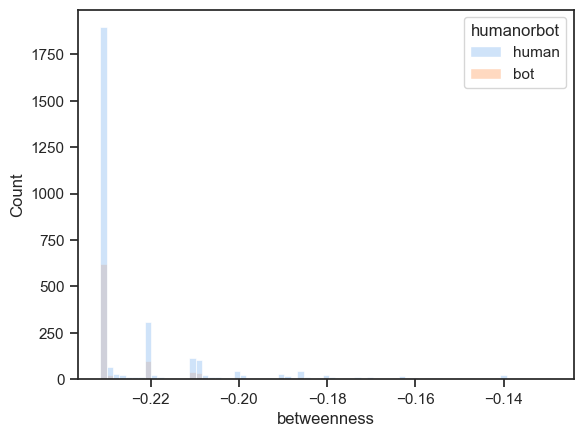

In [96]:
# Calculate quartiles and IQR
Q1 = betweenness_data['betweenness'].quantile(0.25)
Q3 = betweenness_data['betweenness'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_data = betweenness_data[(betweenness_data['betweenness'] >= lower_bound) & (betweenness_data['betweenness'] <= upper_bound)]

# Create histplot without outliers
sns.histplot(filtered_data, x="betweenness", hue="humanorbot")

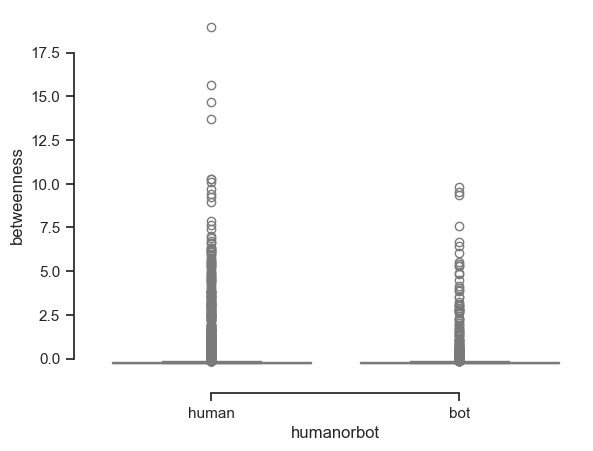

In [97]:
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x ='humanorbot', y="betweenness",
            data=betweenness_data)
sns.despine(offset=10, trim=True)

In [98]:
#change the threshold to 0.002
bot_proportion(whole_network_stats, thr_70, 0.002)

human_betweenness_data = pd.DataFrame(human_betweenness, columns=['betweenness'])
human_betweenness_data['humanorbot'] = 'human'
bot_betweenness_data = pd.DataFrame(bot_betweenness, columns=['betweenness'])
bot_betweenness_data['humanorbot'] = 'bot'
betweenness_data = pd.concat([human_betweenness_data, bot_betweenness_data]).reset_index()
del betweenness_data['index']

In [99]:
betweenness_data['betweenness'] =(betweenness_data['betweenness']-betweenness_data['betweenness'].mean())/betweenness_data['betweenness'].std()

<Axes: xlabel='betweenness', ylabel='Count'>

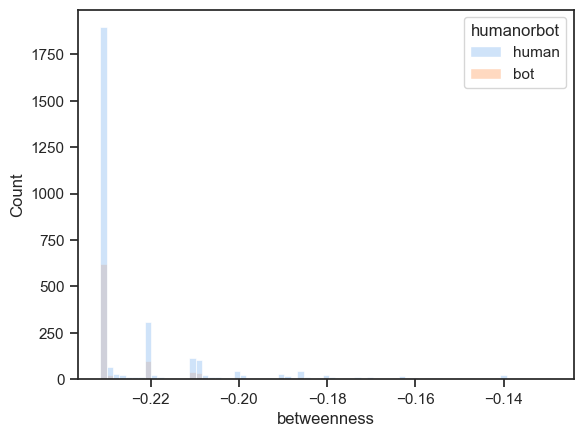

In [100]:
# Calculate quartiles and IQR
Q1 = betweenness_data['betweenness'].quantile(0.25)
Q3 = betweenness_data['betweenness'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_data = betweenness_data[(betweenness_data['betweenness'] >= lower_bound) & (betweenness_data['betweenness'] <= upper_bound)]

# Create histplot without outliers
sns.histplot(filtered_data, x="betweenness", hue="humanorbot")

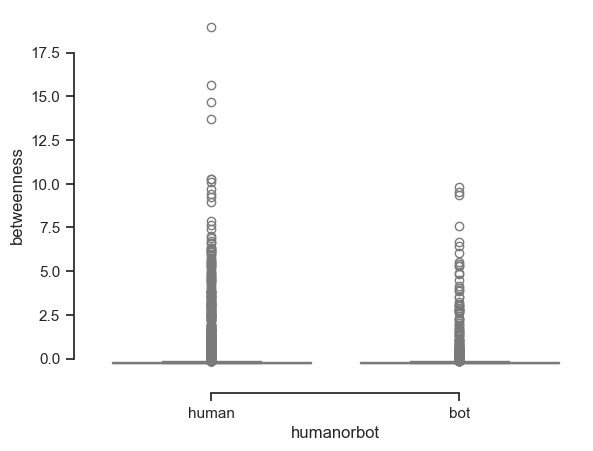

In [86]:
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x ='humanorbot', y="betweenness",
            data=betweenness_data)
sns.despine(offset=10, trim=True)

### End 